This script reproduces the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) by the HDDM (0.9.*) in this docker image.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.9.8


## Loading data

In [3]:
data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


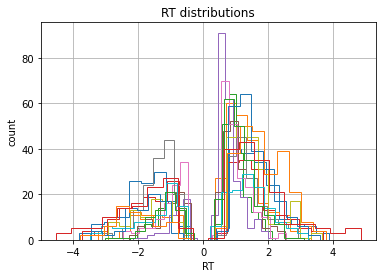

In [4]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [5]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

Note that there will be a lot of warnings about data type and `frame.append` method, but it still works. Also, the latest HDDM has changes a lot for the `HDDMnn` function, when running the older function `HDDM`, it will remind you that  `No model attribute --> setting up standard HDDM` `Set model to ddm`.This is normal.

In [6]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
#m1 = hddm.HDDM(data)
m1 = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                        informative = True,
                        is_group_model = True)
# find a good starting point which helps with the convergence.
m1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m1.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 181.6 sec

In [7]:
stats = m1.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97683,0.0912808,1.80111,1.91835,1.97587,2.03108,2.17002,0.0028391
a_std,0.33939,0.0833858,0.2223,0.282401,0.324566,0.375665,0.552822,0.00317517
a_subj.0,2.20084,0.0622396,2.07979,2.1604,2.19993,2.24185,2.32482,0.0021487
a_subj.1,2.1178,0.0651611,1.99593,2.07231,2.11793,2.16064,2.24992,0.00221903


Plotting a
Plotting a_std
Plotting v
Plotting t


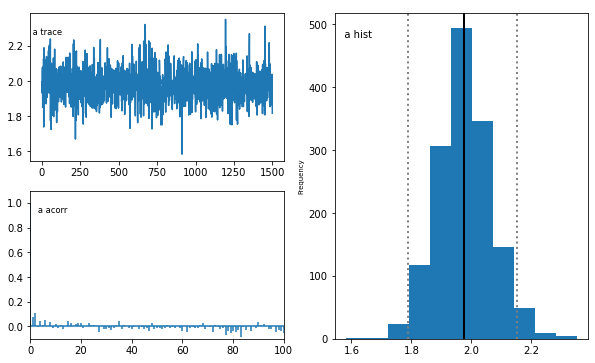

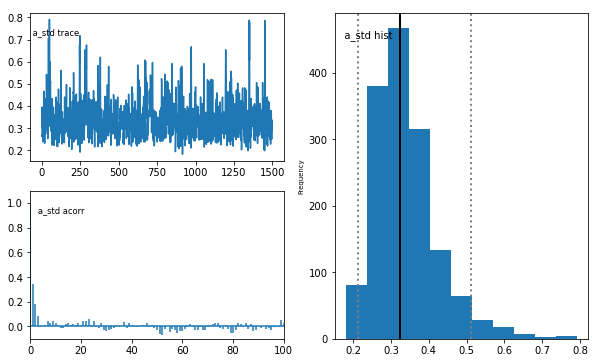

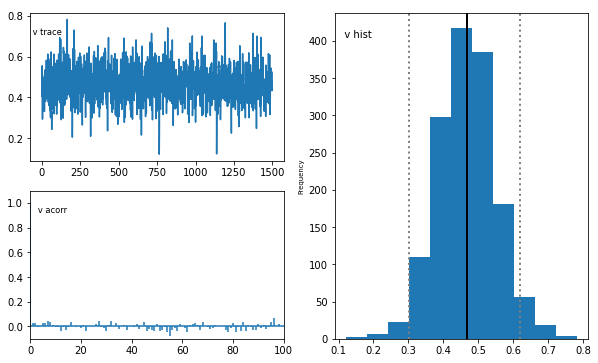

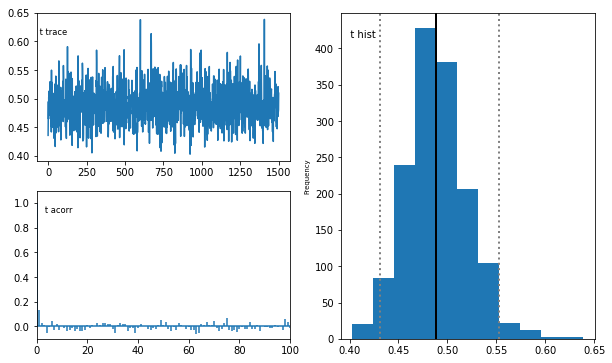

In [8]:
m1.plot_posteriors(['a', 't', 'v', 'a_std'])

## Calculate Gelman_rubin r hat.

The original tutorial used `for` loop:

In [ ]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

Here, we replace the `for` loop with parallel processing:

In [9]:
# parallel processing related packages
from p_tqdm import p_map
from functools import partial

In [10]:
def ms1(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m1"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    #m = hddm.HDDM(data)
    m = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                        informative = True,
                        is_group_model = True)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [11]:
samples = 5000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 1000    
thin = 1
chains = 4

In [12]:
models_1 = p_map(partial(ms1, data=data, samples=samples, burn=burn),
                 range(chains)) # progess bar is a mess ;(

running model0
No model attribute --> setting up standard HDDM

  0%|          | 0/4 [00:00<?, ?it/s]


Set model to ddm
running model1
No model attribute --> setting up standard HDDM
Set model to ddm
running model2
No model attribute --> setting up standard HDDM
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


                   0%                  ] 43 of 5000 complete in 5.0 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 11 of 5000 complete in 1.2 sec[                  0%                  ] 11 of 5000 complete in 1.2 sec[                  0%                  ] 11 of 5000 complete in 1.2 sec[                  0%                  ] 11 of 5000 complete in 1.2 sec[                  0%                  ] 16 of 5000 complete in 1.7 sec[                  0%                  ] 16 of 5000 complete in 1.7 sec  [                  0%                  ] 16 of 5000 complete in 1.8 sec[                  0%                  ] 16 of 5000 complete in 1.7 sec[                  0%                  ] 21 of 5000 complete in 2.2 sec[                  0%                  ] 21 of 5000 complete in 2.2 sec[      

 -                 5%                  ] 259 of 5000 complete in 29.7 sec[-                 2%                  ] 146 of 5000 complete in 16.7 sec[-                 2%                  ] 148 of 5000 complete in 17.0 sec[-                 3%                  ] 150 of 5000 complete in 17.1 sec[-                 2%                  ] 147 of 5000 complete in 17.1 sec[-                 2%                  ] 149 of 5000 complete in 17.3 sec[-                 3%                  ] 151 of 5000 complete in 17.6 sec[-                 3%                  ] 153 of 5000 complete in 17.6 sec  [-                 3%                  ] 150 of 5000 complete in 17.7 sec[-                 3%                  ] 152 of 5000 complete in 17.8 sec[-                 3%                  ] 154 of 5000 complete in 18.1 sec[-                 3%                  ] 157 of 5000 complete in 18.2 sec[-                 3%                  ] 156 of 5000 complete in 18.3 sec[-                 3%                  ] 154 of 5

 [--                5%                  ] 285 of 5000 complete in 32.6 sec[--                5%                  ] 285 of 5000 complete in 32.5 sec[--                5%                  ] 292 of 5000 complete in 32.8 sec[--                5%                  ] 289 of 5000 complete in 33.0 sec[--                5%                  ] 290 of 5000 complete in 33.0 sec[--                5%                  ] 290 of 5000 complete in 33.1 sec[--                5%                  ] 297 of 5000 complete in 33.4 sec[--                5%                  ] 294 of 5000 complete in 33.5 sec[--                5%                  ] 295 of 5000 complete in 33.6 sec[--                5%                  ] 295 of 5000 complete in 33.7 sec[--                6%                  ] 302 of 5000 complete in 33.9 sec[--                6%                  ] 300 of 5000 complete in 34.1 sec[--                6%                  ] 301 of 5000 complete in 34.2 sec[--                6%                  ] 301 of 50

 [---               8%                  ] 425 of 5000 complete in 48.1 sec[---               8%                  ] 429 of 5000 complete in 48.3 sec[---               8%                  ] 429 of 5000 complete in 48.3 sec[---               8%                  ] 432 of 5000 complete in 48.5 sec[---               8%                  ] 431 of 5000 complete in 48.7 sec[---               8%                  ] 435 of 5000 complete in 48.9 sec[---               8%                  ] 435 of 5000 complete in 49.0 sec[---               8%                  ] 437 of 5000 complete in 49.1 sec[---               8%                  ] 435 of 5000 complete in 49.2 sec[---               8%                  ] 439 of 5000 complete in 49.4 sec[---               8%                  ] 439 of 5000 complete in 49.5 sec[---               8%                  ] 442 of 5000 complete in 49.7 sec[---               8%                  ] 439 of 5000 complete in 49.8 sec[---               8%                  ] 444 of 50

 -----            13%                  ] 658 of 5000 complete in 72.4 secc[----             11%                  ] 585 of 5000 complete in 64.0 sec[----             11%                  ] 583 of 5000 complete in 64.1 sec[----             11%                  ] 586 of 5000 complete in 64.1 sec[----             11%                  ] 584 of 5000 complete in 64.5 sec[----             11%                  ] 590 of 5000 complete in 64.5 sec[----             11%                  ] 588 of 5000 complete in 64.6 sec[----             11%                  ] 591 of 5000 complete in 64.7 sec[----             11%                  ] 589 of 5000 complete in 65.1 sec[----             11%                  ] 595 of 5000 complete in 65.1 sec[----             11%                  ] 593 of 5000 complete in 65.1 sec[----             11%                  ] 596 of 5000 complete in 65.2 sec[----             11%                  ] 594 of 5000 complete in 65.6 sec  [----             11%                  ] 598 of 

 ------           16%                  ] 817 of 5000 complete in 89.9 secc[-----            14%                  ] 719 of 5000 complete in 79.8 sec[-----            14%                  ] 727 of 5000 complete in 80.0 sec[-----            14%                  ] 727 of 5000 complete in 80.0 sec[-----            14%                  ] 728 of 5000 complete in 80.2 sec[-----            14%                  ] 725 of 5000 complete in 80.4 sec [-----            14%                  ] 732 of 5000 complete in 80.6 sec[-----            14%                  ] 733 of 5000 complete in 80.8 sec[-----            14%                  ] 730 of 5000 complete in 81.0 sec  [-----            14%                  ] 737 of 5000 complete in 81.1 sec[-----            14%                  ] 737 of 5000 complete in 81.1 sec[-----            14%                  ] 738 of 5000 complete in 81.3 sec[-----            14%                  ] 735 of 5000 complete in 81.5 sec[-----            14%                  ] 741 of

 -------          19%                  ] 995 of 5000 complete in 109.1 sec[------           17%                  ] 869 of 5000 complete in 95.4 sec[------           17%                  ] 870 of 5000 complete in 95.6 sec[------           17%                  ] 865 of 5000 complete in 95.9 sec[------           17%                  ] 872 of 5000 complete in 96.0 sec[------           17%                  ] 874 of 5000 complete in 96.0 sec[------           17%                  ] 875 of 5000 complete in 96.1 sec[------           17%                  ] 870 of 5000 complete in 96.4 sec[------           17%                  ] 877 of 5000 complete in 96.5 sec[------           17%                  ] 880 of 5000 complete in 96.6 sec[------           17%                  ] 880 of 5000 complete in 96.7 sec[------           17%                  ] 875 of 5000 complete in 97.0 sec[------           17%                  ] 882 of 5000 complete in 97.1 sec[------           17%                  ] 885 of 50

 --------         22%                  ] 1121 of 5000 complete in 122.8 secc[-------          20%                  ] 1010 of 5000 complete in 110.8 sec[-------          20%                  ] 1002 of 5000 complete in 111.0 sec[-------          20%                  ] 1011 of 5000 complete in 111.3 sec  [-------          20%                  ] 1017 of 5000 complete in 111.3 sec[-------          20%                  ] 1015 of 5000 complete in 111.3 sec[-------          20%                  ] 1007 of 5000 complete in 111.5 sec[-------          20%                  ] 1021 of 5000 complete in 111.8 sec[-------          20%                  ] 1016 of 5000 complete in 111.9 sec[-------          20%                  ] 1020 of 5000 complete in 112.0 sec[-------          20%                  ] 1011 of 5000 complete in 112.1 sec[-------          20%                  ] 1026 of 5000 complete in 112.4 sec  [-------          20%                  ] 1022 of 5000 complete in 112.5 sec[-------          20

 ---------        23%                  ] 1192 of 5000 complete in 130.6 secc[--------         23%                  ] 1152 of 5000 complete in 126.3 sec[--------         22%                  ] 1142 of 5000 complete in 126.4 sec [--------         23%                  ] 1156 of 5000 complete in 126.6 sec[--------         23%                  ] 1157 of 5000 complete in 126.9 sec[--------         22%                  ] 1147 of 5000 complete in 126.9 sec[--------         23%                  ] 1161 of 5000 complete in 127.1 sec[--------         23%                  ] 1151 of 5000 complete in 127.2 sec[--------         23%                  ] 1162 of 5000 complete in 127.4 sec[--------         23%                  ] 1152 of 5000 complete in 127.5 sec[--------         23%                  ] 1166 of 5000 complete in 127.7 sec[--------         23%                  ] 1156 of 5000 complete in 127.8 sec[--------         23%                  ] 1157 of 5000 complete in 128.0 sec[--------         23%  

 ----------       26%                  ] 1333 of 5000 complete in 145.5 secc[---------        25%                  ] 1285 of 5000 complete in 141.7 sec [---------        25%                  ] 1277 of 5000 complete in 141.8 sec[---------        25%                  ] 1296 of 5000 complete in 141.9 sec  [---------        26%                  ] 1302 of 5000 complete in 142.3 sec[---------        25%                  ] 1281 of 5000 complete in 142.3 sec[---------        25%                  ] 1290 of 5000 complete in 142.4 sec[---------        26%                  ] 1300 of 5000 complete in 142.5 sec[---------        26%                  ] 1308 of 5000 complete in 142.9 sec[---------        25%                  ] 1287 of 5000 complete in 142.9 sec[---------        25%                  ] 1296 of 5000 complete in 143.0 sec[---------        26%                  ] 1306 of 5000 complete in 143.0 sec[---------        26%                  ] 1313 of 5000 complete in 143.4 sec[---------        25%

 -----------      29%                  ] 1493 of 5000 complete in 167.6 secc[----------       28%                  ] 1402 of 5000 complete in 157.5 sec[----------       28%                  ] 1422 of 5000 complete in 157.6 sec[----------       28%                  ] 1413 of 5000 complete in 157.8 sec[----------       28%                  ] 1428 of 5000 complete in 157.9 sec[----------       28%                  ] 1406 of 5000 complete in 158.0 sec[----------       28%                  ] 1426 of 5000 complete in 158.1 sec[----------       28%                  ] 1417 of 5000 complete in 158.3 sec[----------       28%                  ] 1433 of 5000 complete in 158.5 sec[----------       28%                  ] 1411 of 5000 complete in 158.6 sec[----------       28%                  ] 1431 of 5000 complete in 158.7 sec[----------       28%                  ] 1422 of 5000 complete in 158.8 sec[----------       28%                  ] 1438 of 5000 complete in 159.0 sec[----------       28%   

 ------------     32%                  ] 1618 of 5000 complete in 184.0 secc [-----------      30%                  ] 1539 of 5000 complete in 173.5 sec[-----------      30%                  ] 1546 of 5000 complete in 173.6 sec[-----------      30%                  ] 1521 of 5000 complete in 174.0 sec[-----------      30%                  ] 1531 of 5000 complete in 174.1 sec[-----------      30%                  ] 1542 of 5000 complete in 174.1 sec[-----------      30%                  ] 1549 of 5000 complete in 174.3 sec[-----------      30%                  ] 1524 of 5000 complete in 174.5 sec[-----------      30%                  ] 1535 of 5000 complete in 174.7 sec[-----------      30%                  ] 1546 of 5000 complete in 174.7 sec[-----------      31%                  ] 1553 of 5000 complete in 174.8 sec[-----------      30%                  ] 1528 of 5000 complete in 175.1 sec[-----------      30%                  ] 1539 of 5000 complete in 175.3 sec[-----------      31%  

 ------------     33%                  ] 1681 of 5000 complete in 191.8 secc[------------     32%                  ] 1631 of 5000 complete in 189.2 sec[------------     33%                  ] 1651 of 5000 complete in 189.3 sec[------------     33%                  ] 1661 of 5000 complete in 189.5 sec[------------     32%                  ] 1643 of 5000 complete in 189.7 sec[------------     32%                  ] 1635 of 5000 complete in 189.7 sec[------------     33%                  ] 1655 of 5000 complete in 189.9 sec[------------     33%                  ] 1665 of 5000 complete in 190.1 sec[------------     32%                  ] 1646 of 5000 complete in 190.2 sec[------------     32%                  ] 1638 of 5000 complete in 190.3 sec[------------     33%                  ] 1659 of 5000 complete in 190.4 sec[------------     33%                  ] 1670 of 5000 complete in 190.6 sec[------------     33%                  ] 1651 of 5000 complete in 190.8 sec[------------     32%   

 --------------   37%                  ] 1864 of 5000 complete in 213.9 secc[-------------    35%                  ] 1757 of 5000 complete in 204.9 sec[-------------    35%                  ] 1786 of 5000 complete in 204.9 sec[-------------    35%                  ] 1778 of 5000 complete in 205.0 sec[-------------    35%                  ] 1769 of 5000 complete in 205.3 sec[-------------    35%                  ] 1762 of 5000 complete in 205.5 sec[-------------    35%                  ] 1791 of 5000 complete in 205.4 sec[-------------    35%                  ] 1783 of 5000 complete in 205.6 sec[-------------    35%                  ] 1773 of 5000 complete in 205.8 sec[-------------    35%                  ] 1766 of 5000 complete in 206.0 sec[-------------    35%                  ] 1796 of 5000 complete in 206.0 sec[-------------    35%                  ] 1788 of 5000 complete in 206.2 sec[-------------    35%                  ] 1778 of 5000 complete in 206.3 sec[-------------    35%   

 ---------------  40%                  ] 2003 of 5000 complete in 233.2 secc[--------------   37%                  ] 1889 of 5000 complete in 220.7 sec[--------------   38%                  ] 1922 of 5000 complete in 220.8 sec[--------------   38%                  ] 1913 of 5000 complete in 220.8 sec[--------------   38%                  ] 1902 of 5000 complete in 221.0 sec[--------------   37%                  ] 1894 of 5000 complete in 221.3 sec[--------------   38%                  ] 1927 of 5000 complete in 221.3 sec[--------------   38%                  ] 1918 of 5000 complete in 221.4 sec[--------------   38%                  ] 1907 of 5000 complete in 221.5 sec[--------------   37%                  ] 1898 of 5000 complete in 221.8 sec[--------------   38%                  ] 1931 of 5000 complete in 221.9 sec[--------------   38%                  ] 1922 of 5000 complete in 221.9 sec[--------------   38%                  ] 1911 of 5000 complete in 222.1 sec[--------------   38%   

 [---------------  40%                  ] 2015 of 5000 complete in 236.4 sec[---------------  40%                  ] 2022 of 5000 complete in 236.4 sec[---------------  40%                  ] 2043 of 5000 complete in 236.6 sec[---------------  40%                  ] 2027 of 5000 complete in 236.9 sec[---------------  40%                  ] 2019 of 5000 complete in 236.9 sec[---------------  40%                  ] 2026 of 5000 complete in 237.1 sec[---------------  40%                  ] 2046 of 5000 complete in 237.2 sec[---------------  40%                  ] 2031 of 5000 complete in 237.5 sec[---------------  40%                  ] 2023 of 5000 complete in 237.6 sec[---------------  40%                  ] 2029 of 5000 complete in 237.6 sec[---------------  40%                  ] 2049 of 5000 complete in 237.8 sec[---------------  40%                  ] 2035 of 5000 complete in 238.1 sec[---------------  40%                  ] 2027 of 5000 complete in 238.1 sec[---------------  40%   

 ---------------- 43%                  ] 2197 of 5000 complete in 260.7 secc[---------------- 42%                  ] 2145 of 5000 complete in 251.9 sec[---------------- 42%                  ] 2138 of 5000 complete in 252.1 sec[---------------- 42%                  ] 2141 of 5000 complete in 252.2 sec[---------------- 42%                  ] 2148 of 5000 complete in 252.4 sec[---------------- 42%                  ] 2149 of 5000 complete in 252.5 sec[---------------- 42%                  ] 2143 of 5000 complete in 252.7 sec[---------------- 42%                  ] 2145 of 5000 complete in 252.7 sec[---------------- 43%                  ] 2153 of 5000 complete in 253.0 sec[---------------- 43%                  ] 2153 of 5000 complete in 253.0 sec[---------------- 42%                  ] 2148 of 5000 complete in 253.2 sec[---------------- 43%                  ] 2150 of 5000 complete in 253.3 sec[---------------- 43%                  ] 2158 of 5000 complete in 253.6 sec[---------------- 43%   

 [-----------------44%                  ] 2243 of 5000 complete in 268.3 sec[-----------------44%                  ] 2240 of 5000 complete in 268.3 sec[-----------------45%                  ] 2255 of 5000 complete in 268.8 sec[-----------------45%                  ] 2250 of 5000 complete in 268.9 sec[-----------------44%                  ] 2245 of 5000 complete in 268.9 sec[-----------------44%                  ] 2242 of 5000 complete in 269.0 sec[-----------------45%                  ] 2257 of 5000 complete in 269.4 sec[-----------------45%                  ] 2252 of 5000 complete in 269.4 sec[-----------------44%                  ] 2247 of 5000 complete in 269.4 sec[-----------------44%                  ] 2245 of 5000 complete in 269.6 sec[-----------------45%                  ] 2262 of 5000 complete in 269.9 sec[-----------------45%                  ] 2257 of 5000 complete in 270.0 sec[-----------------45%                  ] 2252 of 5000 complete in 270.0 sec[-----------------44%   

 -----------------48%                  ] 2449 of 5000 complete in 295.2 secc[-----------------47%                  ] 2368 of 5000 complete in 284.1 sec[-----------------47%                  ] 2364 of 5000 complete in 284.1 sec[-----------------47%                  ] 2354 of 5000 complete in 284.4 sec[-----------------47%                  ] 2378 of 5000 complete in 284.6 sec[-----------------47%                  ] 2372 of 5000 complete in 284.6 sec[-----------------47%                  ] 2368 of 5000 complete in 284.6 sec[-----------------47%                  ] 2358 of 5000 complete in 285.0 sec[-----------------47%                  ] 2382 of 5000 complete in 285.2 sec[-----------------47%                  ] 2376 of 5000 complete in 285.2 sec[-----------------47%                  ] 2372 of 5000 complete in 285.2 sec[-----------------47%                  ] 2363 of 5000 complete in 285.5 sec[-----------------47%                  ] 2387 of 5000 complete in 285.7 sec[-----------------47%   

 -----------------51%                  ] 2577 of 5000 complete in 310.4 secc[-----------------49%                  ] 2477 of 5000 complete in 300.0 sec[-----------------49%                  ] 2492 of 5000 complete in 300.3 sec[-----------------50%                  ] 2500 of 5000 complete in 300.4 sec[-----------------49%                  ] 2489 of 5000 complete in 300.4 sec[-----------------49%                  ] 2482 of 5000 complete in 300.5 sec[-----------------49%                  ] 2497 of 5000 complete in 300.9 sec[-----------------50%                  ] 2505 of 5000 complete in 301.0 sec[-----------------49%                  ] 2494 of 5000 complete in 301.0 sec[-----------------49%                  ] 2487 of 5000 complete in 301.1 sec [-----------------50%                  ] 2502 of 5000 complete in 301.5 sec [-----------------50%                  ] 2510 of 5000 complete in 301.6 sec[-----------------49%                  ] 2499 of 5000 complete in 301.6 sec[-----------------49% 

 -----------------54%                  ] 2727 of 5000 complete in 327.6 secc[-----------------52%                  ] 2605 of 5000 complete in 315.6 sec[-----------------52%                  ] 2618 of 5000 complete in 315.9 sec[-----------------52%                  ] 2627 of 5000 complete in 316.0 sec[-----------------52%                  ] 2617 of 5000 complete in 316.1 sec[-----------------52%                  ] 2610 of 5000 complete in 316.1 sec[-----------------52%                  ] 2623 of 5000 complete in 316.4 sec[-----------------52%                  ] 2632 of 5000 complete in 316.5 sec[-----------------52%                  ] 2622 of 5000 complete in 316.7 sec[-----------------52%                  ] 2615 of 5000 complete in 316.7 sec[-----------------52%                  ] 2628 of 5000 complete in 316.9 sec[-----------------52%                  ] 2637 of 5000 complete in 317.1 sec[-----------------52%                  ] 2627 of 5000 complete in 317.2 sec[-----------------52%   

 -----------------56%-                 ] 2839 of 5000 complete in 341.9 secc[-----------------55%                  ] 2753 of 5000 complete in 330.8 sec[-----------------54%                  ] 2744 of 5000 complete in 330.9 sec[-----------------54%                  ] 2748 of 5000 complete in 331.2 sec[-----------------54%                  ] 2740 of 5000 complete in 331.2 sec[-----------------55%                  ] 2758 of 5000 complete in 331.4 sec[-----------------54%                  ] 2749 of 5000 complete in 331.5 sec[-----------------55%                  ] 2753 of 5000 complete in 331.7 sec[-----------------54%                  ] 2745 of 5000 complete in 331.7 sec[-----------------55%                  ] 2763 of 5000 complete in 331.9 sec[-----------------55%                  ] 2754 of 5000 complete in 332.0 sec[-----------------55%                  ] 2758 of 5000 complete in 332.3 sec[-----------------55%                  ] 2750 of 5000 complete in 332.3 sec[-----------------55%-  

 -----------------59%--                ] 2996 of 5000 complete in 357.8 secc[-----------------57%-                 ] 2882 of 5000 complete in 346.0 sec[-----------------57%-                 ] 2881 of 5000 complete in 346.1 sec[-----------------57%-                 ] 2876 of 5000 complete in 346.3 sec[-----------------57%-                 ] 2894 of 5000 complete in 346.4 sec[-----------------57%-                 ] 2887 of 5000 complete in 346.5 sec[-----------------57%-                 ] 2886 of 5000 complete in 346.6 sec  [-----------------57%-                 ] 2881 of 5000 complete in 346.8 sec[-----------------57%--                ] 2899 of 5000 complete in 346.9 sec[-----------------57%-                 ] 2892 of 5000 complete in 347.0 sec[-----------------57%-                 ] 2891 of 5000 complete in 347.2 sec[-----------------58%--                ] 2904 of 5000 complete in 347.5 sec[-----------------57%-                 ] 2886 of 5000 complete in 347.4 sec[-----------------57%-

 [-----------------60%--                ] 3014 of 5000 complete in 361.2 sec[-----------------60%--                ] 3016 of 5000 complete in 361.2 sec[-----------------60%--                ] 3005 of 5000 complete in 361.3 sec[-----------------60%---               ] 3030 of 5000 complete in 361.7 sec[-----------------60%--                ] 3019 of 5000 complete in 361.7 sec[-----------------60%--                ] 3021 of 5000 complete in 361.8 sec[-----------------60%--                ] 3010 of 5000 complete in 361.8 sec[-----------------60%--                ] 3024 of 5000 complete in 362.2 sec[-----------------60%---               ] 3035 of 5000 complete in 362.3 sec[-----------------60%--                ] 3026 of 5000 complete in 362.3 sec[-----------------60%--                ] 3015 of 5000 complete in 362.4 sec[-----------------60%---               ] 3029 of 5000 complete in 362.8 sec[-----------------60%---               ] 3040 of 5000 complete in 362.9 sec[-----------------60%---

 -----------------63%----              ] 3188 of 5000 complete in 380.9 secc[-----------------63%----              ] 3163 of 5000 complete in 376.5 sec[-----------------63%---               ] 3152 of 5000 complete in 376.5 sec[-----------------63%---               ] 3157 of 5000 complete in 376.7 sec[-----------------63%----              ] 3166 of 5000 complete in 376.9 sec[-----------------63%----              ] 3169 of 5000 complete in 377.0 sec[-----------------63%---               ] 3157 of 5000 complete in 377.0 sec[-----------------63%----              ] 3162 of 5000 complete in 377.2 sec[-----------------63%----              ] 3171 of 5000 complete in 377.5 sec[-----------------63%----              ] 3173 of 5000 complete in 377.5 sec[-----------------63%----              ] 3161 of 5000 complete in 377.6 sec[-----------------63%----              ] 3166 of 5000 complete in 377.7 sec[-----------------63%----              ] 3165 of 5000 complete in 378.1 sec[-----------------63%---

 -----------------66%-----             ] 3333 of 5000 complete in 397.8 secc[-----------------65%----              ] 3284 of 5000 complete in 391.8 sec[-----------------65%-----             ] 3296 of 5000 complete in 391.9 sec[-----------------66%-----             ] 3300 of 5000 complete in 392.0 sec[-----------------65%-----             ] 3292 of 5000 complete in 392.1 sec[-----------------65%----              ] 3289 of 5000 complete in 392.3 sec[-----------------66%-----             ] 3302 of 5000 complete in 392.5 sec[-----------------66%-----             ] 3305 of 5000 complete in 392.5 sec[-----------------65%-----             ] 3297 of 5000 complete in 392.6 sec[-----------------65%-----             ] 3294 of 5000 complete in 392.9 sec[-----------------66%-----             ] 3307 of 5000 complete in 393.1 sec[-----------------66%-----             ] 3310 of 5000 complete in 393.1 sec[-----------------66%-----             ] 3302 of 5000 complete in 393.2 sec[-----------------65%---

 -----------------71%-------           ] 3554 of 5000 complete in 421.5 secc[-----------------68%------            ] 3430 of 5000 complete in 407.3 sec[-----------------68%------            ] 3427 of 5000 complete in 407.3 sec[-----------------68%-----             ] 3421 of 5000 complete in 407.3 sec[-----------------68%------            ] 3436 of 5000 complete in 407.5 sec[-----------------68%------            ] 3434 of 5000 complete in 407.9 sec[-----------------68%------            ] 3431 of 5000 complete in 408.0 sec[-----------------68%------            ] 3425 of 5000 complete in 407.9 sec[-----------------68%------            ] 3440 of 5000 complete in 408.0 sec[-----------------68%------            ] 3439 of 5000 complete in 408.5 sec[-----------------68%------            ] 3436 of 5000 complete in 408.5 sec[-----------------68%------            ] 3430 of 5000 complete in 408.5 sec[-----------------68%------            ] 3445 of 5000 complete in 408.6 sec[-----------------68%---

 -----------------71%-------           ] 3585 of 5000 complete in 426.1 secc[-----------------71%-------           ] 3566 of 5000 complete in 422.7 sec[-----------------71%-------           ] 3557 of 5000 complete in 422.9 sec[-----------------71%-------           ] 3568 of 5000 complete in 423.1 sec[-----------------71%-------           ] 3566 of 5000 complete in 423.1 sec[-----------------71%-------           ] 3571 of 5000 complete in 423.2 sec[-----------------71%-------           ] 3562 of 5000 complete in 423.5 sec[-----------------71%-------           ] 3573 of 5000 complete in 423.6 sec[-----------------71%-------           ] 3571 of 5000 complete in 423.6 sec[-----------------71%-------           ] 3576 of 5000 complete in 423.7 sec[-----------------71%-------           ] 3567 of 5000 complete in 424.0 sec[-----------------71%-------           ] 3578 of 5000 complete in 424.1 sec[-----------------71%-------           ] 3576 of 5000 complete in 424.2 sec[-----------------71%---

 -----------------75%--------          ] 3783 of 5000 complete in 447.0 secc[-----------------74%--------          ] 3702 of 5000 complete in 438.0 sec[-----------------74%--------          ] 3704 of 5000 complete in 438.2 sec[-----------------73%--------          ] 3691 of 5000 complete in 438.2 sec[-----------------74%--------          ] 3705 of 5000 complete in 438.6 sec[-----------------74%--------          ] 3707 of 5000 complete in 438.5 sec[-----------------74%--------          ] 3709 of 5000 complete in 438.7 sec[-----------------73%--------          ] 3696 of 5000 complete in 438.7 sec[-----------------74%--------          ] 3710 of 5000 complete in 439.1 sec[-----------------74%--------          ] 3712 of 5000 complete in 439.1 sec[-----------------74%--------          ] 3714 of 5000 complete in 439.2 sec[-----------------74%--------          ] 3701 of 5000 complete in 439.3 sec[-----------------74%--------          ] 3715 of 5000 complete in 439.6 sec[-----------------74%---

 -----------------79%----------        ] 3961 of 5000 complete in 466.4 secc[-----------------76%---------         ] 3838 of 5000 complete in 453.1 sec[-----------------76%---------         ] 3842 of 5000 complete in 453.1 sec[-----------------76%---------         ] 3843 of 5000 complete in 453.4 sec[-----------------76%---------         ] 3831 of 5000 complete in 453.5 sec[-----------------76%---------         ] 3843 of 5000 complete in 453.6 sec[-----------------76%---------         ] 3847 of 5000 complete in 453.7 sec[-----------------76%---------         ] 3848 of 5000 complete in 454.0 sec[-----------------76%---------         ] 3836 of 5000 complete in 454.1 sec[-----------------76%---------         ] 3848 of 5000 complete in 454.2 sec[-----------------77%---------         ] 3852 of 5000 complete in 454.2 sec[-----------------77%---------         ] 3853 of 5000 complete in 454.5 sec[-----------------76%---------         ] 3841 of 5000 complete in 454.6 sec[-----------------77%---

 [-----------------79%----------        ] 3983 of 5000 complete in 468.5 sec[-----------------79%----------        ] 3981 of 5000 complete in 468.7 sec[-----------------79%----------        ] 3973 of 5000 complete in 468.8 sec[-----------------79%----------        ] 3986 of 5000 complete in 469.1 sec[-----------------79%----------        ] 3987 of 5000 complete in 469.1 sec[-----------------79%----------        ] 3985 of 5000 complete in 469.2 sec[-----------------79%----------        ] 3977 of 5000 complete in 469.4 sec[-----------------79%----------        ] 3991 of 5000 complete in 469.6 sec[-----------------79%----------        ] 3992 of 5000 complete in 469.6 sec[-----------------79%----------        ] 3990 of 5000 complete in 469.8 sec[-----------------79%----------        ] 3982 of 5000 complete in 469.9 sec[-----------------79%----------        ] 3996 of 5000 complete in 470.1 sec[-----------------79%----------        ] 3997 of 5000 complete in 470.1 sec[-----------------79%---

 -----------------84%------------      ] 4229 of 5000 complete in 495.6 secc[-----------------82%-----------       ] 4121 of 5000 complete in 483.7 sec[-----------------82%-----------       ] 4125 of 5000 complete in 483.8 sec[-----------------82%-----------       ] 4121 of 5000 complete in 483.8 sec[-----------------82%-----------       ] 4113 of 5000 complete in 483.9 sec[-----------------82%-----------       ] 4126 of 5000 complete in 484.2 sec[-----------------82%-----------       ] 4130 of 5000 complete in 484.3 sec[-----------------82%-----------       ] 4126 of 5000 complete in 484.4 sec[-----------------82%-----------       ] 4118 of 5000 complete in 484.5 sec[-----------------82%-----------       ] 4131 of 5000 complete in 484.8 sec[-----------------82%-----------       ] 4135 of 5000 complete in 484.9 sec[-----------------82%-----------       ] 4131 of 5000 complete in 484.9 sec[-----------------82%-----------       ] 4123 of 5000 complete in 485.0 sec[-----------------82%---

 [-----------------85%------------      ] 4263 of 5000 complete in 498.6 sec[-----------------84%------------      ] 4245 of 5000 complete in 498.7 sec[-----------------85%------------      ] 4259 of 5000 complete in 498.8 sec[-----------------85%------------      ] 4259 of 5000 complete in 499.0 sec[-----------------85%------------      ] 4268 of 5000 complete in 499.1 sec[-----------------85%------------      ] 4250 of 5000 complete in 499.3 sec[-----------------85%------------      ] 4264 of 5000 complete in 499.4 sec[-----------------85%------------      ] 4264 of 5000 complete in 499.5 sec[-----------------85%------------      ] 4273 of 5000 complete in 499.7 sec[-----------------85%------------      ] 4255 of 5000 complete in 499.8 sec[-----------------85%------------      ] 4269 of 5000 complete in 499.9 sec[-----------------85%------------      ] 4269 of 5000 complete in 500.0 sec[-----------------85%------------      ] 4278 of 5000 complete in 500.2 sec  [-----------------85%-

 [-----------------87%-------------     ] 4382 of 5000 complete in 513.2 sec[-----------------87%-------------     ] 4395 of 5000 complete in 513.4 sec[-----------------88%-------------     ] 4404 of 5000 complete in 513.4 sec[-----------------88%-------------     ] 4400 of 5000 complete in 513.7 sec[-----------------87%-------------     ] 4387 of 5000 complete in 513.7 sec[-----------------88%-------------     ] 4400 of 5000 complete in 513.9 sec[-----------------88%-------------     ] 4409 of 5000 complete in 514.0 sec[-----------------88%-------------     ] 4405 of 5000 complete in 514.2 sec[-----------------87%-------------     ] 4392 of 5000 complete in 514.2 sec[-----------------88%-------------     ] 4405 of 5000 complete in 514.4 sec[-----------------88%-------------     ] 4414 of 5000 complete in 514.5 sec[-----------------88%-------------     ] 4410 of 5000 complete in 514.8 sec[-----------------87%-------------     ] 4397 of 5000 complete in 514.8 sec[-----------------88%---

 [-----------------90%--------------    ] 4538 of 5000 complete in 528.1 sec[-----------------90%--------------    ] 4531 of 5000 complete in 528.2 sec[-----------------90%--------------    ] 4519 of 5000 complete in 528.2 sec[-----------------90%--------------    ] 4532 of 5000 complete in 528.4 sec[-----------------90%--------------    ] 4543 of 5000 complete in 528.6 sec[-----------------90%--------------    ] 4536 of 5000 complete in 528.7 sec[-----------------90%--------------    ] 4524 of 5000 complete in 528.8 sec[-----------------90%--------------    ] 4537 of 5000 complete in 529.0 sec[-----------------90%--------------    ] 4547 of 5000 complete in 529.2 sec[-----------------90%--------------    ] 4540 of 5000 complete in 529.3 sec[-----------------90%--------------    ] 4528 of 5000 complete in 529.3 sec[-----------------90%--------------    ] 4541 of 5000 complete in 529.5 sec[-----------------91%--------------    ] 4552 of 5000 complete in 529.7 sec[-----------------90%---

 -----------------93%---------------   ] 4698 of 5000 complete in 546.1 secc[-----------------93%---------------   ] 4668 of 5000 complete in 542.9 sec[-----------------93%---------------   ] 4677 of 5000 complete in 542.9 sec[-----------------93%---------------   ] 4672 of 5000 complete in 543.2 sec[-----------------93%---------------   ] 4661 of 5000 complete in 543.2 sec[-----------------93%---------------   ] 4673 of 5000 complete in 543.4 sec[-----------------93%---------------   ] 4682 of 5000 complete in 543.5 sec[-----------------93%---------------   ] 4677 of 5000 complete in 543.7 sec[-----------------93%---------------   ] 4666 of 5000 complete in 543.7 sec[-----------------93%---------------   ] 4678 of 5000 complete in 544.0 sec[-----------------93%---------------   ] 4687 of 5000 complete in 544.0 sec[-----------------93%---------------   ] 4683 of 5000 complete in 544.3 sec[-----------------93%---------------   ] 4672 of 5000 complete in 544.3 sec[-----------------93%---

 -----------------98%----------------- ] 4944 of 5000 complete in 572.3 secc  [-----------------95%----------------  ] 4798 of 5000 complete in 557.9 sec[-----------------96%----------------  ] 4809 of 5000 complete in 558.0 sec[-----------------96%----------------  ] 4821 of 5000 complete in 558.1 sec[-----------------96%----------------  ] 4814 of 5000 complete in 558.2 sec[-----------------96%----------------  ] 4814 of 5000 complete in 558.5 sec[-----------------96%----------------  ] 4803 of 5000 complete in 558.5 sec[-----------------96%----------------  ] 4826 of 5000 complete in 558.6 sec[-----------------96%----------------  ] 4819 of 5000 complete in 558.8 sec[-----------------96%----------------  ] 4819 of 5000 complete in 559.0 sec[-----------------96%----------------  ] 4808 of 5000 complete in 559.0 sec[-----------------96%----------------  ] 4831 of 5000 complete in 559.1 sec[-----------------96%----------------  ] 4824 of 5000 complete in 559.3 sec[-----------------96%-

 -----------------99%----------------- ] 4992 of 5000 complete in 580.4 secc[-----------------98%----------------- ] 4926 of 5000 complete in 572.8 sec[-----------------98%----------------- ] 4949 of 5000 complete in 572.9 sec[-----------------99%----------------- ] 4962 of 5000 complete in 572.9 sec[-----------------99%----------------- ] 4953 of 5000 complete in 573.1 sec[-----------------98%----------------- ] 4931 of 5000 complete in 573.3 sec[-----------------99%----------------- ] 4954 of 5000 complete in 573.4 sec[-----------------99%----------------- ] 4967 of 5000 complete in 573.5 sec[-----------------99%----------------- ] 4958 of 5000 complete in 573.6 sec[-----------------98%----------------- ] 4936 of 5000 complete in 573.9 sec[-----------------99%----------------- ] 4959 of 5000 complete in 574.0 sec[-----------------99%----------------- ] 4972 of 5000 complete in 574.0 sec[-----------------99%----------------- ] 4963 of 5000 complete in 574.2 sec[-----------------98%---

In [13]:
hddm.analyze.gelman_rubin(models_1)

{'a': 0.9999535820824393,
 'a_std': 0.9999425347090837,
 'a_subj.0': 0.9999695240969096,
 'a_subj.1': 1.0002545676313317,
 'a_subj.2': 1.0005001908459599,
 'a_subj.3': 1.0004801395508502,
 'a_subj.4': 1.0003200087940651,
 'a_subj.5': 0.999957474889441,
 'a_subj.6': 0.999911798850116,
 'a_subj.7': 1.0000396295508207,
 'a_subj.8': 0.9999415366303522,
 'a_subj.9': 1.0007163560834196,
 'a_subj.10': 1.0000005157834824,
 'a_subj.11': 1.0002232476670276,
 'a_subj.12': 1.0004110400381878,
 'a_subj.13': 0.9999583558004882,
 'v': 1.0002833545221355,
 'v_std': 0.9999260092414833,
 'v_subj.0': 1.0000865490307638,
 'v_subj.1': 1.0003784807695015,
 'v_subj.2': 1.0001947066603192,
 'v_subj.3': 1.0004486506994839,
 'v_subj.4': 0.9999884913065372,
 'v_subj.5': 1.0003769089463928,
 'v_subj.6': 1.0008075640045433,
 'v_subj.7': 1.0002606317350795,
 'v_subj.8': 0.9999830157352202,
 'v_subj.9': 1.0006233733863807,
 'v_subj.10': 1.0005031051331559,
 'v_subj.11': 1.0006449286255032,
 'v_subj.12': 0.9999053634

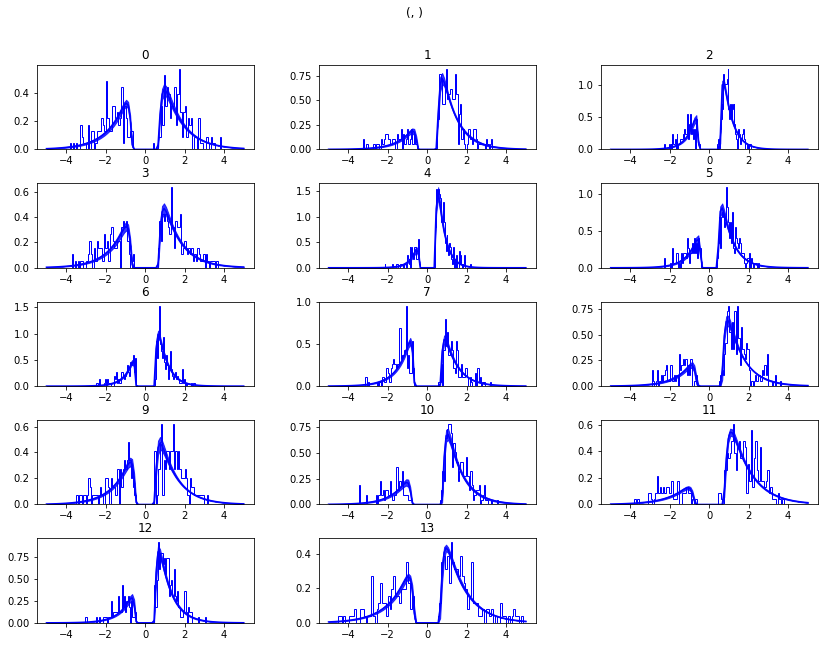

In [14]:
models_1[0].plot_posterior_predictive(figsize=(14, 10))

In [15]:
m_comb = kabuki.utils.concat_models(models_1) # combine four chains together

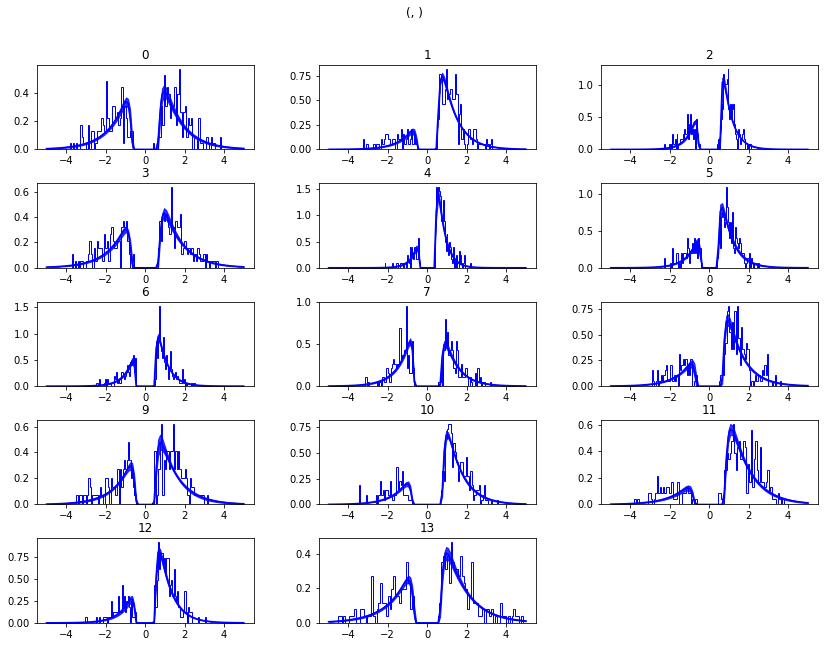

In [16]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

### Model 2: `v` depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [17]:
def ms2(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m2"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    # m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m = hddm.HDDM(data, include = ['v', 'a', 't', 'z'],
                   informative = True,
                   is_group_model = True,
                   depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # save the model data
    m.save(mname)
    
    return m

In [18]:
# note: the samples, burn, and chains can be changed too
models_2 = p_map(partial(ms2, data=data, samples=samples, burn=burn),
                 range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

running model0
No model attribute --> setting up standard HDDM
Set model to ddm
running model1
No model attribute --> setting up standard HDDM
running model2Set model to ddm

No model attribute --> setting up standard HDDM
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


                   0%                  ] 47 of 5000 complete in 11.9 sec[                  0%                  ] 3 of 5000 complete in 0.7 sec[                  0%                  ] 3 of 5000 complete in 0.7 sec [                  0%                  ] 3 of 5000 complete in 0.7 sec[                  0%                  ] 6 of 5000 complete in 1.3 sec[                  0%                  ] 6 of 5000 complete in 1.3 sec  [                  0%                  ] 6 of 5000 complete in 1.4 sec[                  0%                  ] 6 of 5000 complete in 1.4 sec[                  0%                  ] 8 of 5000 complete in 1.8 sec[                  0%                  ] 8 of 5000 complete in 1.8 sec[                  0%                  ] 8 of 5000 complete in 1.9 sec[                  0%                  ] 8 of 5000 complete in 1.9 sec[                  0%                  ] 10 of 5000 complete in 2.3 sec[                  0%                  ] 11 of 5000 complete in 2.5 sec[            

                   1%                  ] 97 of 5000 complete in 24.3 secc[                  1%                  ] 72 of 5000 complete in 18.1 sec[                  1%                  ] 72 of 5000 complete in 18.3 sec[                  1%                  ] 72 of 5000 complete in 18.4 sec[                  1%                  ] 73 of 5000 complete in 18.5 sec[                  1%                  ] 74 of 5000 complete in 18.6 sec[                  1%                  ] 74 of 5000 complete in 18.9 sec[                  1%                  ] 74 of 5000 complete in 19.0 sec[                  1%                  ] 75 of 5000 complete in 19.1 sec[                  1%                  ] 76 of 5000 complete in 19.2 sec[                  1%                  ] 77 of 5000 complete in 19.6 sec[                  1%                  ] 77 of 5000 complete in 19.7 sec[                  1%                  ] 78 of 5000 complete in 19.8 sec[                  1%                  ] 79 of 5000 complete in

 -                 4%                  ] 208 of 5000 complete in 51.7 secc[-                 2%                  ] 143 of 5000 complete in 35.8 sec[-                 2%                  ] 144 of 5000 complete in 35.8 sec[-                 2%                  ] 144 of 5000 complete in 36.1 sec[-                 2%                  ] 141 of 5000 complete in 36.2 sec[-                 2%                  ] 145 of 5000 complete in 36.3 sec[-                 2%                  ] 146 of 5000 complete in 36.4 sec[-                 2%                  ] 147 of 5000 complete in 36.8 sec[-                 2%                  ] 144 of 5000 complete in 36.9 sec[-                 2%                  ] 148 of 5000 complete in 37.0 sec[-                 2%                  ] 149 of 5000 complete in 37.1 sec[-                 3%                  ] 150 of 5000 complete in 37.5 sec[-                 2%                  ] 147 of 5000 complete in 37.6 sec[-                 3%                  ] 151 of 50

 -                 4%                  ] 238 of 5000 complete in 59.9 secc[-                 4%                  ] 218 of 5000 complete in 54.1 sec[-                 4%                  ] 215 of 5000 complete in 54.3 sec[-                 4%                  ] 218 of 5000 complete in 54.3 sec[-                 4%                  ] 218 of 5000 complete in 54.4 sec[-                 4%                  ] 220 of 5000 complete in 54.6 sec[-                 4%                  ] 218 of 5000 complete in 55.0 sec[-                 4%                  ] 221 of 5000 complete in 55.0 sec[-                 4%                  ] 221 of 5000 complete in 55.1 sec[-                 4%                  ] 223 of 5000 complete in 55.3 sec[-                 4%                  ] 220 of 5000 complete in 55.5 sec[-                 4%                  ] 223 of 5000 complete in 55.5 sec[-                 4%                  ] 224 of 5000 complete in 55.8 sec[-                 4%                  ] 225 of 50

 --                6%                  ] 332 of 5000 complete in 84.2 secc[--                5%                  ] 286 of 5000 complete in 71.7 sec[--                5%                  ] 288 of 5000 complete in 71.9 sec[--                5%                  ] 284 of 5000 complete in 72.0 sec[--                5%                  ] 287 of 5000 complete in 72.2 sec[--                5%                  ] 288 of 5000 complete in 72.2 sec[--                5%                  ] 290 of 5000 complete in 72.4 sec[--                5%                  ] 286 of 5000 complete in 72.5 sec[--                5%                  ] 289 of 5000 complete in 72.7 sec[--                5%                  ] 290 of 5000 complete in 72.8 sec[--                5%                  ] 288 of 5000 complete in 73.0 sec[--                5%                  ] 293 of 5000 complete in 73.1 sec[--                5%                  ] 292 of 5000 complete in 73.3 sec[--                5%                  ] 292 of 50

 ---               8%                  ] 430 of 5000 complete in 107.2 sec--                7%                  ] 351 of 5000 complete in 89.4 sec[--                7%                  ] 354 of 5000 complete in 89.4 sec[--                7%                  ] 360 of 5000 complete in 90.0 sec[--                7%                  ] 358 of 5000 complete in 90.0 sec[--                7%                  ] 354 of 5000 complete in 90.1 sec[--                7%                  ] 357 of 5000 complete in 90.1 sec [--                7%                  ] 361 of 5000 complete in 90.7 sec[--                7%                  ] 357 of 5000 complete in 90.8 sec[--                7%                  ] 360 of 5000 complete in 90.8 sec  [--                7%                  ] 364 of 5000 complete in 91.4 sec[--                7%                  ] 366 of 5000 complete in 91.4 sec[--                7%                  ] 363 of 5000 complete in 91.5 sec[--                7%                  ] 360 of 

 ---               9%                  ] 489 of 5000 complete in 121.9 secc[---               8%                  ] 441 of 5000 complete in 109.1 sec[---               8%                  ] 440 of 5000 complete in 109.2 sec[---               8%                  ] 434 of 5000 complete in 109.3 sec[---               8%                  ] 439 of 5000 complete in 109.7 sec[---               8%                  ] 443 of 5000 complete in 109.7 sec[---               8%                  ] 442 of 5000 complete in 109.9 sec[---               8%                  ] 436 of 5000 complete in 109.9 sec[---               8%                  ] 441 of 5000 complete in 110.2 sec[---               8%                  ] 445 of 5000 complete in 110.3 sec  [---               8%                  ] 439 of 5000 complete in 110.6 sec[---               8%                  ] 445 of 5000 complete in 110.6 sec[---               8%                  ] 444 of 5000 complete in 110.9 sec[---               8%              

 ----             11%                  ] 591 of 5000 complete in 144.9 secc[---              10%                  ] 511 of 5000 complete in 127.0 sec[---              10%                  ] 517 of 5000 complete in 127.4 sec[---              10%                  ] 516 of 5000 complete in 127.7 sec[---              10%                  ] 514 of 5000 complete in 127.8 sec[---              10%                  ] 510 of 5000 complete in 127.8 sec[---              10%                  ] 519 of 5000 complete in 127.9 sec[---              10%                  ] 519 of 5000 complete in 128.4 sec[---              10%                  ] 513 of 5000 complete in 128.5 sec[---              10%                  ] 517 of 5000 complete in 128.5 sec[---              10%                  ] 522 of 5000 complete in 128.6 sec[---              10%                  ] 522 of 5000 complete in 129.1 sec[---              10%                  ] 516 of 5000 complete in 129.2 sec[---              10%                

 -----            13%                  ] 666 of 5000 complete in 162.0 secc[----             11%                  ] 589 of 5000 complete in 145.7 sec[----             11%                  ] 591 of 5000 complete in 146.2 sec[----             11%                  ] 594 of 5000 complete in 146.2 sec[----             11%                  ] 597 of 5000 complete in 146.3 sec[----             11%                  ] 587 of 5000 complete in 146.4 sec  [----             11%                  ] 594 of 5000 complete in 146.9 sec[----             11%                  ] 597 of 5000 complete in 146.9 sec[----             12%                  ] 600 of 5000 complete in 146.9 sec[----             11%                  ] 590 of 5000 complete in 147.0 sec[----             11%                  ] 597 of 5000 complete in 147.5 sec [----             12%                  ] 600 of 5000 complete in 147.6 sec[----             11%                  ] 593 of 5000 complete in 147.6 sec[----             12%             

 -----            14%                  ] 734 of 5000 complete in 178.3 secc[-----            13%                  ] 680 of 5000 complete in 165.2 sec[-----            13%                  ] 675 of 5000 complete in 165.3 sec[-----            13%                  ] 680 of 5000 complete in 165.5 sec[-----            13%                  ] 673 of 5000 complete in 165.6 sec[-----            13%                  ] 678 of 5000 complete in 165.9 sec[-----            13%                  ] 683 of 5000 complete in 165.9 sec[-----            13%                  ] 675 of 5000 complete in 166.2 sec[-----            13%                  ] 683 of 5000 complete in 166.2 sec[-----            13%                  ] 680 of 5000 complete in 166.4 sec[-----            13%                  ] 685 of 5000 complete in 166.5 sec[-----            13%                  ] 678 of 5000 complete in 166.8 sec[-----            13%                  ] 686 of 5000 complete in 166.8 sec[-----            13%                

 ------           16%                  ] 804 of 5000 complete in 195.4 secc[-----            15%                  ] 757 of 5000 complete in 183.7 sec[-----            15%                  ] 750 of 5000 complete in 183.8 sec[-----            15%                  ] 758 of 5000 complete in 184.0 sec[-----            15%                  ] 755 of 5000 complete in 184.1 sec[-----            15%                  ] 760 of 5000 complete in 184.3 sec[-----            15%                  ] 753 of 5000 complete in 184.5 sec[-----            15%                  ] 761 of 5000 complete in 184.6 sec[-----            15%                  ] 757 of 5000 complete in 184.7 sec[-----            15%                  ] 763 of 5000 complete in 185.0 sec[-----            15%                  ] 756 of 5000 complete in 185.2 sec[-----            15%                  ] 764 of 5000 complete in 185.3 sec[-----            15%                  ] 760 of 5000 complete in 185.4 sec[-----            15%                

 [------           16%                  ] 835 of 5000 complete in 202.0 sec[------           16%                  ] 833 of 5000 complete in 202.1 sec[------           16%                  ] 831 of 5000 complete in 202.2 sec[------           16%                  ] 837 of 5000 complete in 202.5 sec[------           16%                  ] 841 of 5000 complete in 202.6 sec[------           16%                  ] 836 of 5000 complete in 202.8 sec[------           16%                  ] 834 of 5000 complete in 202.9 sec[------           16%                  ] 843 of 5000 complete in 203.1 sec[------           16%                  ] 839 of 5000 complete in 203.1 sec[------           16%                  ] 839 of 5000 complete in 203.5 sec[------           16%                  ] 837 of 5000 complete in 203.6 sec[------           16%                  ] 841 of 5000 complete in 203.7 sec[------           16%                  ] 846 of 5000 complete in 203.8 sec  [------           16%              

 -------          19%                  ] 970 of 5000 complete in 234.7 secc[------           18%                  ] 910 of 5000 complete in 219.7 sec[------           18%                  ] 904 of 5000 complete in 219.7 sec[------           17%                  ] 896 of 5000 complete in 220.1 sec[------           18%                  ] 902 of 5000 complete in 220.1 sec[------           18%                  ] 913 of 5000 complete in 220.4 sec[------           18%                  ] 907 of 5000 complete in 220.5 sec[------           17%                  ] 898 of 5000 complete in 220.7 sec[------           18%                  ] 905 of 5000 complete in 220.8 sec[------           18%                  ] 915 of 5000 complete in 220.9 sec[------           18%                  ] 910 of 5000 complete in 221.2 sec[------           18%                  ] 900 of 5000 complete in 221.3 sec[------           18%                  ] 908 of 5000 complete in 221.5 sec[------           18%                

 -------          20%                  ] 1022 of 5000 complete in 247.8 sec[-------          19%                  ] 976 of 5000 complete in 237.7 sec[-------          19%                  ] 982 of 5000 complete in 237.8 sec[-------          19%                  ] 954 of 5000 complete in 237.9 sec[-------          19%                  ] 984 of 5000 complete in 238.3 sec[-------          19%                  ] 984 of 5000 complete in 238.4 sec[-------          19%                  ] 979 of 5000 complete in 238.4 sec[-------          19%                  ] 956 of 5000 complete in 238.5 sec[-------          19%                  ] 986 of 5000 complete in 238.9 sec[-------          19%                  ] 986 of 5000 complete in 238.9 sec[-------          19%                  ] 982 of 5000 complete in 239.1 sec[-------          19%                  ] 958 of 5000 complete in 239.1 sec[-------          19%                  ] 988 of 5000 complete in 239.5 sec[-------          19%                

 --------         21%                  ] 1092 of 5000 complete in 265.8 secc[-------          21%                  ] 1051 of 5000 complete in 255.1 sec[-------          20%                  ] 1046 of 5000 complete in 255.2 sec[-------          20%                  ] 1008 of 5000 complete in 255.3 sec[-------          20%                  ] 1044 of 5000 complete in 255.5 sec[--------         21%                  ] 1054 of 5000 complete in 255.8 sec[-------          20%                  ] 1010 of 5000 complete in 255.9 sec[-------          20%                  ] 1049 of 5000 complete in 255.9 sec[-------          20%                  ] 1047 of 5000 complete in 256.3 sec[-------          21%                  ] 1051 of 5000 complete in 256.4 sec[--------         21%                  ] 1057 of 5000 complete in 256.5 sec[-------          20%                  ] 1012 of 5000 complete in 256.5 sec[-------          21%                  ] 1050 of 5000 complete in 257.0 sec[--------         21%   

 --------         23%                  ] 1158 of 5000 complete in 283.4 secc[--------         22%                  ] 1124 of 5000 complete in 273.0 sec[--------         22%                  ] 1116 of 5000 complete in 273.2 sec[--------         22%                  ] 1131 of 5000 complete in 273.3 sec[--------         21%                  ] 1068 of 5000 complete in 273.4 sec[--------         22%                  ] 1126 of 5000 complete in 273.6 sec[--------         22%                  ] 1118 of 5000 complete in 273.8 sec[--------         22%                  ] 1133 of 5000 complete in 273.8 sec[--------         21%                  ] 1070 of 5000 complete in 274.0 sec[--------         22%                  ] 1129 of 5000 complete in 274.3 sec[--------         22%                  ] 1136 of 5000 complete in 274.5 sec[--------         22%                  ] 1121 of 5000 complete in 274.5 sec[--------         21%                  ] 1072 of 5000 complete in 274.7 sec[--------         22%   

 [---------        23%                  ] 1192 of 5000 complete in 291.2 sec[--------         22%                  ] 1126 of 5000 complete in 291.3 sec[---------        24%                  ] 1205 of 5000 complete in 291.5 sec[---------        24%                  ] 1209 of 5000 complete in 291.8 sec[--------         22%                  ] 1128 of 5000 complete in 291.8 sec[---------        23%                  ] 1195 of 5000 complete in 291.9 sec[---------        24%                  ] 1208 of 5000 complete in 292.2 sec[--------         22%                  ] 1130 of 5000 complete in 292.4 sec[---------        24%                  ] 1212 of 5000 complete in 292.5 sec[---------        23%                  ] 1198 of 5000 complete in 292.6 sec[---------        24%                  ] 1211 of 5000 complete in 292.9 sec[--------         22%                  ] 1132 of 5000 complete in 292.9 sec[---------        24%                  ] 1201 of 5000 complete in 293.2 sec[---------        24%   

 ---------        26%                  ] 1302 of 5000 complete in 314.4 secc[---------        25%                  ] 1279 of 5000 complete in 308.8 sec[---------        25%                  ] 1268 of 5000 complete in 308.9 sec[---------        23%                  ] 1192 of 5000 complete in 309.1 sec[---------        25%                  ] 1280 of 5000 complete in 309.1 sec[---------        25%                  ] 1282 of 5000 complete in 309.5 sec[---------        25%                  ] 1271 of 5000 complete in 309.6 sec[---------        23%                  ] 1194 of 5000 complete in 309.6 sec[---------        25%                  ] 1283 of 5000 complete in 309.8 sec[---------        23%                  ] 1196 of 5000 complete in 310.2 sec[---------        25%                  ] 1285 of 5000 complete in 310.2 sec[---------        25%                  ] 1274 of 5000 complete in 310.3 sec[---------        25%                  ] 1286 of 5000 complete in 310.5 sec[---------        23%   

 ---------        25%                  ] 1265 of 5000 complete in 328.3 secc[---------        25%                  ] 1256 of 5000 complete in 326.3 sec[----------       27%                  ] 1354 of 5000 complete in 326.5 sec[----------       27%                  ] 1356 of 5000 complete in 326.9 sec  [----------       26%                  ] 1345 of 5000 complete in 327.0 sec[---------        25%                  ] 1259 of 5000 complete in 327.0 sec[----------       27%                  ] 1357 of 5000 complete in 327.2 sec[----------       27%                  ] 1359 of 5000 complete in 327.5 sec[---------        25%                  ] 1262 of 5000 complete in 327.6 sec[----------       26%                  ] 1348 of 5000 complete in 327.6 sec[----------       27%                  ] 1360 of 5000 complete in 327.9 sec[----------       27%                  ] 1362 of 5000 complete in 328.2 sec [----------       27%                  ] 1351 of 5000 complete in 328.3 sec[----------       27%

 -----------      29%                  ] 1467 of 5000 complete in 359.0 secc[----------       26%                  ] 1328 of 5000 complete in 343.9 sec  [----------       28%                  ] 1428 of 5000 complete in 344.5 sec[----------       28%                  ] 1428 of 5000 complete in 344.5 sec[----------       28%                  ] 1415 of 5000 complete in 344.5 sec[----------       26%                  ] 1331 of 5000 complete in 344.6 sec[----------       28%                  ] 1430 of 5000 complete in 345.1 sec [----------       28%                  ] 1430 of 5000 complete in 345.1 sec [----------       28%                  ] 1417 of 5000 complete in 345.1 sec[----------       26%                  ] 1333 of 5000 complete in 345.2 sec[----------       28%                  ] 1432 of 5000 complete in 345.7 sec[----------       28%                  ] 1432 of 5000 complete in 345.7 sec[----------       28%                  ] 1419 of 5000 complete in 345.7 sec[----------       26

 -----------      30%                  ] 1510 of 5000 complete in 367.4 secc[-----------      29%                  ] 1488 of 5000 complete in 361.5 sec[-----------      29%                  ] 1475 of 5000 complete in 361.6 sec[-----------      29%                  ] 1486 of 5000 complete in 361.9 sec[----------       27%                  ] 1393 of 5000 complete in 362.0 sec[-----------      29%                  ] 1490 of 5000 complete in 362.1 sec[-----------      29%                  ] 1477 of 5000 complete in 362.1 sec[----------       27%                  ] 1395 of 5000 complete in 362.5 sec[-----------      29%                  ] 1488 of 5000 complete in 362.5 sec[-----------      29%                  ] 1492 of 5000 complete in 362.6 sec[-----------      29%                  ] 1479 of 5000 complete in 362.6 sec[----------       27%                  ] 1397 of 5000 complete in 363.0 sec[-----------      29%                  ] 1490 of 5000 complete in 363.1 sec[-----------      29%   

 ------------     32%                  ] 1605 of 5000 complete in 394.8 secc[-----------      31%                  ] 1552 of 5000 complete in 378.2 sec[-----------      29%                  ] 1456 of 5000 complete in 378.4 sec[-----------      30%                  ] 1542 of 5000 complete in 378.5 sec[-----------      30%                  ] 1541 of 5000 complete in 378.6 sec[-----------      31%                  ] 1554 of 5000 complete in 378.7 sec[-----------      29%                  ] 1458 of 5000 complete in 378.9 sec[-----------      30%                  ] 1544 of 5000 complete in 379.1 sec[-----------      30%                  ] 1543 of 5000 complete in 379.2 sec[-----------      31%                  ] 1556 of 5000 complete in 379.2 sec[-----------      29%                  ] 1460 of 5000 complete in 379.4 sec[-----------      30%                  ] 1546 of 5000 complete in 379.7 sec[-----------      30%                  ] 1546 of 5000 complete in 379.9 sec[-----------      31%   

 -----------      31%                  ] 1558 of 5000 complete in 404.5 sec[-----------      30%                  ] 1525 of 5000 complete in 395.5 sec[------------     32%                  ] 1610 of 5000 complete in 395.8 sec[------------     32%                  ] 1623 of 5000 complete in 396.0 sec[------------     32%                  ] 1609 of 5000 complete in 396.0 sec[-----------      30%                  ] 1527 of 5000 complete in 396.1 sec[------------     32%                  ] 1612 of 5000 complete in 396.4 sec[------------     32%                  ] 1625 of 5000 complete in 396.6 sec[------------     32%                  ] 1611 of 5000 complete in 396.6 sec[-----------      30%                  ] 1529 of 5000 complete in 396.7 sec[------------     32%                  ] 1614 of 5000 complete in 396.9 sec[------------     32%                  ] 1627 of 5000 complete in 397.1 sec[------------     32%                  ] 1613 of 5000 complete in 397.1 sec[-----------      30%    

 ------------     34%                  ] 1701 of 5000 complete in 421.9 secc[------------     33%                  ] 1671 of 5000 complete in 412.1 sec[------------     31%                  ] 1587 of 5000 complete in 412.2 sec[------------     33%                  ] 1684 of 5000 complete in 412.3 sec[------------     33%                  ] 1670 of 5000 complete in 412.6 sec[------------     33%                  ] 1673 of 5000 complete in 412.6 sec[------------     31%                  ] 1589 of 5000 complete in 412.7 sec[------------     33%                  ] 1686 of 5000 complete in 412.8 sec[------------     33%                  ] 1673 of 5000 complete in 413.3 sec[------------     33%                  ] 1676 of 5000 complete in 413.4 sec[------------     31%                  ] 1592 of 5000 complete in 413.4 sec[------------     33%                  ] 1689 of 5000 complete in 413.6 sec[------------     33%                  ] 1675 of 5000 complete in 413.9 sec[------------     33%   

 -------------    35%                  ] 1763 of 5000 complete in 440.4 secc[-------------    34%                  ] 1736 of 5000 complete in 429.9 sec [-------------    34%                  ] 1725 of 5000 complete in 430.2 sec[------------     32%                  ] 1642 of 5000 complete in 430.3 sec[-------------    34%                  ] 1738 of 5000 complete in 430.5 sec  [-------------    34%                  ] 1727 of 5000 complete in 430.9 sec[-------------    34%                  ] 1724 of 5000 complete in 431.0 sec[------------     32%                  ] 1644 of 5000 complete in 431.0 sec[-------------    34%                  ] 1740 of 5000 complete in 431.2 sec [-------------    34%                  ] 1729 of 5000 complete in 431.6 sec[-------------    34%                  ] 1726 of 5000 complete in 431.6 sec[-------------    34%                  ] 1742 of 5000 complete in 431.9 sec  [------------     32%                  ] 1648 of 5000 complete in 432.1 sec[-------------    

 -------------    34%                  ] 1717 of 5000 complete in 450.3 secc[------------     34%                  ] 1709 of 5000 complete in 448.0 sec[-------------    36%                  ] 1804 of 5000 complete in 448.1 sec[-------------    35%                  ] 1793 of 5000 complete in 448.2 sec[-------------    35%                  ] 1790 of 5000 complete in 448.3 sec[-------------    34%                  ] 1711 of 5000 complete in 448.6 sec[-------------    36%                  ] 1806 of 5000 complete in 448.7 sec[-------------    35%                  ] 1795 of 5000 complete in 448.9 sec[-------------    35%                  ] 1792 of 5000 complete in 448.9 sec[-------------    34%                  ] 1713 of 5000 complete in 449.2 sec[-------------    36%                  ] 1808 of 5000 complete in 449.3 sec[-------------    35%                  ] 1797 of 5000 complete in 449.4 sec[-------------    35%                  ] 1794 of 5000 complete in 449.5 sec[-------------    34%   

 -------------    35%                  ] 1792 of 5000 complete in 469.5 secc[--------------   37%                  ] 1860 of 5000 complete in 465.4 sec[--------------   37%                  ] 1874 of 5000 complete in 465.8 sec[--------------   37%                  ] 1859 of 5000 complete in 465.9 sec[-------------    35%                  ] 1780 of 5000 complete in 465.9 sec[--------------   37%                  ] 1863 of 5000 complete in 466.3 sec[--------------   37%                  ] 1876 of 5000 complete in 466.5 sec[-------------    35%                  ] 1782 of 5000 complete in 466.5 sec[--------------   37%                  ] 1861 of 5000 complete in 466.5 sec[--------------   37%                  ] 1878 of 5000 complete in 467.0 sec[-------------    35%                  ] 1784 of 5000 complete in 467.0 sec[--------------   37%                  ] 1866 of 5000 complete in 467.0 sec[--------------   37%                  ] 1863 of 5000 complete in 467.1 sec[-------------    35%   

 --------------   37%                  ] 1884 of 5000 complete in 492.0 secc[--------------   36%                  ] 1847 of 5000 complete in 483.2 sec[--------------   38%                  ] 1929 of 5000 complete in 483.2 sec[--------------   38%                  ] 1941 of 5000 complete in 483.5 sec[--------------   38%                  ] 1928 of 5000 complete in 483.7 sec[--------------   37%                  ] 1850 of 5000 complete in 483.8 sec[--------------   38%                  ] 1932 of 5000 complete in 483.9 sec[--------------   38%                  ] 1944 of 5000 complete in 484.2 sec[--------------   38%                  ] 1930 of 5000 complete in 484.3 sec[--------------   37%                  ] 1852 of 5000 complete in 484.4 sec[--------------   38%                  ] 1934 of 5000 complete in 484.5 sec[--------------   38%                  ] 1946 of 5000 complete in 484.8 sec[--------------   38%                  ] 1932 of 5000 complete in 484.9 sec[--------------   37%   

 ---------------  40%                  ] 2028 of 5000 complete in 508.4 secc[---------------  40%                  ] 2009 of 5000 complete in 500.5 sec[--------------   38%                  ] 1920 of 5000 complete in 500.7 sec[---------------  40%                  ] 2002 of 5000 complete in 501.1 sec[---------------  40%                  ] 2012 of 5000 complete in 501.1 sec[---------------  39%                  ] 1998 of 5000 complete in 501.2 sec[--------------   38%                  ] 1923 of 5000 complete in 501.4 sec  [---------------  40%                  ] 2014 of 5000 complete in 501.7 sec[---------------  40%                  ] 2004 of 5000 complete in 501.7 sec[---------------  40%                  ] 2000 of 5000 complete in 501.7 sec[--------------   38%                  ] 1926 of 5000 complete in 502.1 sec[---------------  40%                  ] 2017 of 5000 complete in 502.4 sec[---------------  40%                  ] 2007 of 5000 complete in 502.4 sec[---------------  40% 

 ---------------- 42%                  ] 2119 of 5000 complete in 531.3 secc[---------------  41%                  ] 2067 of 5000 complete in 518.5 sec[---------------  41%                  ] 2064 of 5000 complete in 518.6 sec[---------------  39%                  ] 1991 of 5000 complete in 518.9 sec[---------------  41%                  ] 2081 of 5000 complete in 519.0 sec[---------------  41%                  ] 2066 of 5000 complete in 519.1 sec[---------------  41%                  ] 2070 of 5000 complete in 519.2 sec[---------------  39%                  ] 1993 of 5000 complete in 519.5 sec[---------------  41%                  ] 2083 of 5000 complete in 519.6 sec[---------------  41%                  ] 2068 of 5000 complete in 519.7 sec[---------------  41%                  ] 2072 of 5000 complete in 519.7 sec[---------------  41%                  ] 2085 of 5000 complete in 520.1 sec[---------------  39%                  ] 1996 of 5000 complete in 520.1 sec[---------------  41%   

 ---------------- 43%                  ] 2167 of 5000 complete in 540.9 secc[---------------- 42%                  ] 2134 of 5000 complete in 536.1 sec[---------------  41%                  ] 2061 of 5000 complete in 536.3 sec[---------------- 43%                  ] 2150 of 5000 complete in 536.3 sec[---------------- 42%                  ] 2138 of 5000 complete in 536.4 sec[---------------- 42%                  ] 2136 of 5000 complete in 536.6 sec [---------------  41%                  ] 2064 of 5000 complete in 537.0 sec [---------------- 43%                  ] 2153 of 5000 complete in 537.1 sec[---------------- 42%                  ] 2138 of 5000 complete in 537.2 sec[---------------- 42%                  ] 2141 of 5000 complete in 537.3 sec[---------------  41%                  ] 2066 of 5000 complete in 537.6 sec[---------------- 43%                  ] 2155 of 5000 complete in 537.6 sec[---------------- 42%                  ] 2141 of 5000 complete in 537.9 sec[---------------- 42% 

 [---------------- 44%                  ] 2214 of 5000 complete in 553.4 sec[---------------- 44%                  ] 2200 of 5000 complete in 553.7 sec[---------------- 42%                  ] 2127 of 5000 complete in 553.8 sec[---------------- 44%                  ] 2203 of 5000 complete in 553.9 sec[---------------- 44%                  ] 2216 of 5000 complete in 554.0 sec[---------------- 44%                  ] 2202 of 5000 complete in 554.3 sec[---------------- 42%                  ] 2129 of 5000 complete in 554.4 sec[---------------- 44%                  ] 2205 of 5000 complete in 554.5 sec[---------------- 44%                  ] 2218 of 5000 complete in 554.6 sec[---------------- 44%                  ] 2204 of 5000 complete in 554.9 sec[---------------- 42%                  ] 2132 of 5000 complete in 555.1 sec[---------------- 44%                  ] 2208 of 5000 complete in 555.2 sec[---------------- 44%                  ] 2221 of 5000 complete in 555.3 sec[---------------- 44%   

 -----------------45%                  ] 2261 of 5000 complete in 588.7 secc[-----------------45%                  ] 2263 of 5000 complete in 571.6 sec[---------------- 43%                  ] 2192 of 5000 complete in 571.8 sec[-----------------45%                  ] 2268 of 5000 complete in 572.1 sec[-----------------45%                  ] 2282 of 5000 complete in 572.3 sec[-----------------45%                  ] 2265 of 5000 complete in 572.4 sec[---------------- 43%                  ] 2194 of 5000 complete in 572.5 sec[-----------------45%                  ] 2270 of 5000 complete in 572.7 sec[-----------------45%                  ] 2284 of 5000 complete in 572.9 sec[-----------------45%                  ] 2267 of 5000 complete in 572.9 sec[---------------- 43%                  ] 2197 of 5000 complete in 573.2 sec[-----------------45%                  ] 2273 of 5000 complete in 573.3 sec[-----------------45%                  ] 2287 of 5000 complete in 573.5 sec[-----------------45%   

 -----------------47%                  ] 2392 of 5000 complete in 604.7 secc[-----------------47%                  ] 2353 of 5000 complete in 589.7 sec[-----------------46%                  ] 2341 of 5000 complete in 590.0 sec[-----------------45%                  ] 2265 of 5000 complete in 590.0 sec [-----------------46%                  ] 2338 of 5000 complete in 590.3 sec[-----------------46%                  ] 2343 of 5000 complete in 590.5 sec[-----------------45%                  ] 2267 of 5000 complete in 590.5 sec[-----------------46%                  ] 2340 of 5000 complete in 590.9 sec[-----------------47%                  ] 2357 of 5000 complete in 590.9 sec[-----------------46%                  ] 2345 of 5000 complete in 591.2 sec[-----------------45%                  ] 2269 of 5000 complete in 591.3 sec[-----------------46%                  ] 2342 of 5000 complete in 591.6 sec[-----------------47%                  ] 2359 of 5000 complete in 591.6 sec[-----------------46%  

 [-----------------48%                  ] 2420 of 5000 complete in 607.4 sec[-----------------48%                  ] 2404 of 5000 complete in 607.4 sec[-----------------48%                  ] 2410 of 5000 complete in 608.0 sec[-----------------46%                  ] 2334 of 5000 complete in 608.1 sec [-----------------48%                  ] 2423 of 5000 complete in 608.2 sec [-----------------48%                  ] 2407 of 5000 complete in 608.1 sec[-----------------48%                  ] 2412 of 5000 complete in 608.5 sec[-----------------46%                  ] 2337 of 5000 complete in 608.8 sec [-----------------48%                  ] 2410 of 5000 complete in 608.8 sec [-----------------48%                  ] 2426 of 5000 complete in 608.9 sec[-----------------48%                  ] 2414 of 5000 complete in 609.0 sec[-----------------46%                  ] 2339 of 5000 complete in 609.3 sec[-----------------48%                  ] 2412 of 5000 complete in 609.4 sec[-----------------48

 -----------------50%                  ] 2530 of 5000 complete in 635.4 secc[-----------------49%                  ] 2491 of 5000 complete in 625.2 sec[-----------------49%                  ] 2478 of 5000 complete in 625.2 sec[-----------------48%                  ] 2403 of 5000 complete in 625.3 sec[-----------------49%                  ] 2476 of 5000 complete in 625.4 sec[-----------------49%                  ] 2493 of 5000 complete in 625.8 sec[-----------------49%                  ] 2480 of 5000 complete in 625.8 sec[-----------------48%                  ] 2405 of 5000 complete in 625.9 sec[-----------------49%                  ] 2478 of 5000 complete in 626.0 sec[-----------------49%                  ] 2495 of 5000 complete in 626.6 sec [-----------------48%                  ] 2407 of 5000 complete in 626.6 sec[-----------------49%                  ] 2480 of 5000 complete in 626.8 sec[-----------------49%                  ] 2497 of 5000 complete in 627.1 sec[-----------------49%  

 [-----------------51%                  ] 2561 of 5000 complete in 642.6 sec[-----------------49%                  ] 2474 of 5000 complete in 642.7 sec[-----------------50%                  ] 2547 of 5000 complete in 643.2 sec[-----------------51%                  ] 2551 of 5000 complete in 643.2 sec[-----------------51%                  ] 2564 of 5000 complete in 643.3 sec[-----------------49%                  ] 2477 of 5000 complete in 643.4 sec[-----------------50%                  ] 2549 of 5000 complete in 643.7 sec[-----------------51%                  ] 2553 of 5000 complete in 643.7 sec[-----------------51%                  ] 2566 of 5000 complete in 643.8 sec[-----------------49%                  ] 2479 of 5000 complete in 644.0 sec[-----------------51%                  ] 2551 of 5000 complete in 644.2 sec[-----------------51%                  ] 2555 of 5000 complete in 644.3 sec[-----------------51%                  ] 2568 of 5000 complete in 644.4 sec[-----------------49%   

 -----------------53%                  ] 2670 of 5000 complete in 676.3 secc[-----------------52%                  ] 2612 of 5000 complete in 660.0 sec[-----------------50%                  ] 2537 of 5000 complete in 660.0 sec[-----------------52%                  ] 2626 of 5000 complete in 660.2 sec[-----------------52%                  ] 2608 of 5000 complete in 660.3 sec[-----------------52%                  ] 2614 of 5000 complete in 660.7 sec[-----------------50%                  ] 2539 of 5000 complete in 660.7 sec[-----------------52%                  ] 2628 of 5000 complete in 660.9 sec[-----------------52%                  ] 2610 of 5000 complete in 660.9 sec [-----------------50%                  ] 2541 of 5000 complete in 661.3 sec [-----------------52%                  ] 2616 of 5000 complete in 661.3 sec[-----------------52%                  ] 2630 of 5000 complete in 661.4 sec[-----------------52%                  ] 2612 of 5000 complete in 661.5 sec[-----------------50% 

 -----------------54%                  ] 2717 of 5000 complete in 684.1 secc[-----------------53%                  ] 2693 of 5000 complete in 677.0 sec[-----------------53%                  ] 2679 of 5000 complete in 677.0 sec[-----------------52%                  ] 2608 of 5000 complete in 677.5 sec[-----------------53%                  ] 2675 of 5000 complete in 677.6 sec[-----------------53%                  ] 2695 of 5000 complete in 677.6 sec[-----------------53%                  ] 2681 of 5000 complete in 677.6 sec[-----------------52%                  ] 2610 of 5000 complete in 678.3 sec  [-----------------53%                  ] 2697 of 5000 complete in 678.4 sec[-----------------53%                  ] 2677 of 5000 complete in 678.4 sec[-----------------53%                  ] 2683 of 5000 complete in 678.4 sec[-----------------52%                  ] 2612 of 5000 complete in 678.9 sec [-----------------53%                  ] 2699 of 5000 complete in 679.0 sec[-----------------53%

 -----------------55%-                 ] 2784 of 5000 complete in 705.6 secec[-----------------54%                  ] 2738 of 5000 complete in 694.6 sec[-----------------55%                  ] 2759 of 5000 complete in 694.9 sec[-----------------53%                  ] 2675 of 5000 complete in 695.0 sec[-----------------54%                  ] 2740 of 5000 complete in 695.1 sec[-----------------54%                  ] 2743 of 5000 complete in 695.2 sec[-----------------55%                  ] 2761 of 5000 complete in 695.5 sec[-----------------53%                  ] 2677 of 5000 complete in 695.6 sec[-----------------54%                  ] 2742 of 5000 complete in 695.7 sec[-----------------54%                  ] 2745 of 5000 complete in 695.7 sec[-----------------55%-                 ] 2764 of 5000 complete in 696.3 sec[-----------------54%                  ] 2747 of 5000 complete in 696.3 sec[-----------------53%                  ] 2680 of 5000 complete in 696.4 sec[-----------------54%  

 -----------------57%-                 ] 2874 of 5000 complete in 728.1 secc[-----------------56%-                 ] 2825 of 5000 complete in 713.0 sec[-----------------56%-                 ] 2811 of 5000 complete in 713.0 sec[-----------------56%-                 ] 2813 of 5000 complete in 713.1 sec[-----------------54%                  ] 2748 of 5000 complete in 713.3 sec[-----------------56%-                 ] 2827 of 5000 complete in 713.6 sec[-----------------56%-                 ] 2813 of 5000 complete in 713.6 sec[-----------------56%-                 ] 2815 of 5000 complete in 713.6 sec[-----------------55%                  ] 2750 of 5000 complete in 713.9 sec[-----------------56%-                 ] 2815 of 5000 complete in 714.1 sec[-----------------56%-                 ] 2817 of 5000 complete in 714.2 sec[-----------------56%-                 ] 2829 of 5000 complete in 714.2 sec [-----------------56%-                 ] 2817 of 5000 complete in 714.6 sec [-----------------55% 

 -----------------58%--                ] 2942 of 5000 complete in 743.9 secc[-----------------57%-                 ] 2881 of 5000 complete in 729.9 sec[-----------------57%-                 ] 2885 of 5000 complete in 730.1 sec [-----------------57%-                 ] 2880 of 5000 complete in 730.1 sec[-----------------57%-                 ] 2883 of 5000 complete in 730.4 sec[-----------------57%-                 ] 2887 of 5000 complete in 730.6 sec[-----------------56%-                 ] 2816 of 5000 complete in 730.6 sec[-----------------57%-                 ] 2883 of 5000 complete in 730.8 sec[-----------------57%-                 ] 2889 of 5000 complete in 731.1 sec[-----------------56%-                 ] 2818 of 5000 complete in 731.1 sec[-----------------57%-                 ] 2886 of 5000 complete in 731.2 sec[-----------------57%-                 ] 2885 of 5000 complete in 731.4 sec[-----------------57%-                 ] 2891 of 5000 complete in 731.6 sec[-----------------56%- 

 -----------------59%--                ] 2984 of 5000 complete in 753.9 secc[-----------------59%--                ] 2956 of 5000 complete in 747.7 sec[-----------------59%--                ] 2958 of 5000 complete in 747.7 sec[-----------------59%--                ] 2959 of 5000 complete in 747.9 sec [-----------------57%-                 ] 2885 of 5000 complete in 748.1 sec [-----------------59%--                ] 2958 of 5000 complete in 748.2 sec[-----------------59%--                ] 2960 of 5000 complete in 748.3 sec[-----------------59%--                ] 2962 of 5000 complete in 748.7 sec[-----------------59%--                ] 2962 of 5000 complete in 748.8 sec[-----------------59%--                ] 2961 of 5000 complete in 748.8 sec[-----------------57%-                 ] 2888 of 5000 complete in 748.8 sec[-----------------59%--                ] 2964 of 5000 complete in 749.2 sec[-----------------59%--                ] 2965 of 5000 complete in 749.4 sec[-----------------59%-

 -----------------59%--                ] 2984 of 5000 complete in 771.0 secc[-----------------59%--                ] 2960 of 5000 complete in 765.6 sec[-----------------60%---               ] 3036 of 5000 complete in 766.0 sec[-----------------60%---               ] 3036 of 5000 complete in 766.1 sec[-----------------60%---               ] 3039 of 5000 complete in 766.2 sec[-----------------59%--                ] 2963 of 5000 complete in 766.3 sec[-----------------60%---               ] 3039 of 5000 complete in 766.7 sec[-----------------60%---               ] 3039 of 5000 complete in 766.8 sec[-----------------60%---               ] 3042 of 5000 complete in 766.9 sec[-----------------59%--                ] 2966 of 5000 complete in 767.0 sec[-----------------60%---               ] 3042 of 5000 complete in 767.4 sec[-----------------60%---               ] 3042 of 5000 complete in 767.5 sec[-----------------60%---               ] 3045 of 5000 complete in 767.6 sec[-----------------59%-- 

 -----------------62%---               ] 3148 of 5000 complete in 791.2 secc[-----------------62%---               ] 3117 of 5000 complete in 784.1 sec[-----------------62%---               ] 3116 of 5000 complete in 784.3 sec[-----------------62%---               ] 3117 of 5000 complete in 784.5 sec[-----------------60%---               ] 3044 of 5000 complete in 784.7 sec[-----------------62%---               ] 3120 of 5000 complete in 784.8 sec[-----------------62%---               ] 3119 of 5000 complete in 785.0 sec[-----------------62%---               ] 3120 of 5000 complete in 785.2 sec[-----------------60%---               ] 3047 of 5000 complete in 785.3 sec[-----------------62%---               ] 3123 of 5000 complete in 785.5 sec[-----------------62%---               ] 3122 of 5000 complete in 785.7 sec[-----------------62%---               ] 3123 of 5000 complete in 785.8 sec[-----------------61%---               ] 3050 of 5000 complete in 786.0 sec[-----------------62%---

  [-----------------63%----              ] 3195 of 5000 complete in 802.3 sec[-----------------63%----              ] 3192 of 5000 complete in 802.3 sec[-----------------62%---               ] 3121 of 5000 complete in 802.4 sec[-----------------63%----              ] 3194 of 5000 complete in 802.5 sec[-----------------63%----              ] 3197 of 5000 complete in 802.8 sec[-----------------63%----              ] 3194 of 5000 complete in 802.8 sec[-----------------62%---               ] 3124 of 5000 complete in 803.1 sec[-----------------63%----              ] 3197 of 5000 complete in 803.2 sec[-----------------63%----              ] 3196 of 5000 complete in 803.3 sec[-----------------64%----              ] 3200 of 5000 complete in 803.5 sec[-----------------62%---               ] 3127 of 5000 complete in 803.8 sec[-----------------63%----              ] 3198 of 5000 complete in 803.9 sec[-----------------64%----              ] 3200 of 5000 complete in 803.9 sec[-----------------64%--

 -----------------65%----              ] 3265 of 5000 complete in 835.9 secc[-----------------65%----              ] 3266 of 5000 complete in 819.6 sec[-----------------63%----              ] 3195 of 5000 complete in 819.8 sec[-----------------65%----              ] 3268 of 5000 complete in 820.2 sec[-----------------65%----              ] 3265 of 5000 complete in 820.2 sec[-----------------65%----              ] 3269 of 5000 complete in 820.3 sec[-----------------63%----              ] 3198 of 5000 complete in 820.5 sec[-----------------65%----              ] 3271 of 5000 complete in 820.9 sec[-----------------65%----              ] 3268 of 5000 complete in 820.9 sec[-----------------65%----              ] 3272 of 5000 complete in 821.0 sec[-----------------64%----              ] 3201 of 5000 complete in 821.2 sec[-----------------65%----              ] 3274 of 5000 complete in 821.5 sec[-----------------65%----              ] 3271 of 5000 complete in 821.6 sec[-----------------65%---

 [-----------------66%-----             ] 3340 of 5000 complete in 838.0 sec[-----------------65%----              ] 3275 of 5000 complete in 838.2 sec[-----------------66%-----             ] 3347 of 5000 complete in 838.5 sec[-----------------66%-----             ] 3347 of 5000 complete in 838.5 sec[-----------------66%-----             ] 3343 of 5000 complete in 838.7 sec[-----------------65%----              ] 3278 of 5000 complete in 838.9 sec[-----------------67%-----             ] 3350 of 5000 complete in 839.1 sec[-----------------67%-----             ] 3350 of 5000 complete in 839.2 sec[-----------------66%-----             ] 3346 of 5000 complete in 839.3 sec[-----------------65%----              ] 3281 of 5000 complete in 839.6 sec[-----------------67%-----             ] 3353 of 5000 complete in 839.8 sec[-----------------67%-----             ] 3353 of 5000 complete in 839.9 sec[-----------------66%-----             ] 3349 of 5000 complete in 840.0 sec[-----------------67%---

 [-----------------68%------            ] 3424 of 5000 complete in 856.0 sec[-----------------68%-----             ] 3420 of 5000 complete in 856.0 sec[-----------------68%------            ] 3425 of 5000 complete in 856.4 sec[-----------------67%-----             ] 3357 of 5000 complete in 856.5 sec[-----------------68%------            ] 3427 of 5000 complete in 856.6 sec[-----------------68%------            ] 3423 of 5000 complete in 856.7 sec[-----------------68%------            ] 3428 of 5000 complete in 857.0 sec[-----------------67%-----             ] 3360 of 5000 complete in 857.1 sec[-----------------68%------            ] 3430 of 5000 complete in 857.3 sec[-----------------68%------            ] 3426 of 5000 complete in 857.4 sec[-----------------68%------            ] 3431 of 5000 complete in 857.7 sec[-----------------67%-----             ] 3363 of 5000 complete in 857.8 sec[-----------------68%------            ] 3433 of 5000 complete in 858.0 sec[-----------------68%---

 [-----------------70%------            ] 3500 of 5000 complete in 873.9 sec[-----------------70%------            ] 3501 of 5000 complete in 874.1 sec[-----------------69%------            ] 3499 of 5000 complete in 874.3 sec[-----------------68%------            ] 3435 of 5000 complete in 874.4 sec[-----------------70%------            ] 3503 of 5000 complete in 874.6 sec[-----------------70%------            ] 3504 of 5000 complete in 874.8 sec[-----------------70%------            ] 3502 of 5000 complete in 875.0 sec[-----------------68%------            ] 3438 of 5000 complete in 875.0 sec[-----------------70%------            ] 3506 of 5000 complete in 875.3 sec[-----------------70%------            ] 3507 of 5000 complete in 875.4 sec[-----------------70%------            ] 3505 of 5000 complete in 875.7 sec[-----------------68%------            ] 3441 of 5000 complete in 875.7 sec[-----------------70%------            ] 3509 of 5000 complete in 875.9 sec[-----------------70%---

 -----------------71%-------           ] 3582 of 5000 complete in 907.4 secc[-----------------71%-------           ] 3578 of 5000 complete in 891.8 sec[-----------------71%-------           ] 3578 of 5000 complete in 891.9 sec[-----------------71%-------           ] 3573 of 5000 complete in 892.1 sec[-----------------70%------            ] 3515 of 5000 complete in 892.3 sec[-----------------71%-------           ] 3581 of 5000 complete in 892.5 sec[-----------------71%-------           ] 3581 of 5000 complete in 892.6 sec[-----------------71%-------           ] 3576 of 5000 complete in 892.8 sec[-----------------70%------            ] 3518 of 5000 complete in 893.0 sec[-----------------71%-------           ] 3584 of 5000 complete in 893.2 sec[-----------------71%-------           ] 3584 of 5000 complete in 893.3 sec[-----------------71%-------           ] 3579 of 5000 complete in 893.4 sec[-----------------70%------            ] 3521 of 5000 complete in 893.6 sec[-----------------71%---

 -----------------72%-------           ] 3633 of 5000 complete in 918.9 secc[-----------------71%-------           ] 3594 of 5000 complete in 910.1 sec[-----------------73%-------           ] 3659 of 5000 complete in 910.3 sec[-----------------73%-------           ] 3655 of 5000 complete in 910.4 sec [-----------------71%-------           ] 3597 of 5000 complete in 910.7 sec[-----------------73%-------           ] 3662 of 5000 complete in 911.0 sec[-----------------73%-------           ] 3658 of 5000 complete in 911.0 sec[-----------------72%-------           ] 3600 of 5000 complete in 911.4 sec[-----------------73%-------           ] 3658 of 5000 complete in 911.4 sec[-----------------73%-------           ] 3665 of 5000 complete in 911.6 sec[-----------------73%-------           ] 3661 of 5000 complete in 911.8 sec[-----------------72%-------           ] 3603 of 5000 complete in 912.1 sec[-----------------73%-------           ] 3661 of 5000 complete in 912.1 sec[-----------------73%--

 -----------------73%--------          ] 3699 of 5000 complete in 933.9 secc[-----------------74%--------          ] 3731 of 5000 complete in 928.7 sec[-----------------74%--------          ] 3733 of 5000 complete in 928.7 sec[-----------------74%--------          ] 3740 of 5000 complete in 928.8 sec[-----------------73%-------           ] 3677 of 5000 complete in 928.8 sec[-----------------74%--------          ] 3736 of 5000 complete in 929.4 sec[-----------------74%--------          ] 3734 of 5000 complete in 929.4 sec[-----------------74%--------          ] 3743 of 5000 complete in 929.5 sec[-----------------73%-------           ] 3680 of 5000 complete in 929.5 sec [-----------------74%--------          ] 3737 of 5000 complete in 930.1 sec[-----------------73%-------           ] 3683 of 5000 complete in 930.1 sec[-----------------74%--------          ] 3746 of 5000 complete in 930.2 sec [-----------------74%--------          ] 3739 of 5000 complete in 930.0 sec[-----------------74%-

 -----------------77%---------         ] 3878 of 5000 complete in 961.0 secc[-----------------75%--------          ] 3756 of 5000 complete in 946.8 sec[-----------------76%---------         ] 3820 of 5000 complete in 947.2 sec[-----------------76%--------          ] 3813 of 5000 complete in 947.2 sec[-----------------76%--------          ] 3809 of 5000 complete in 947.2 sec[-----------------75%--------          ] 3759 of 5000 complete in 947.5 sec[-----------------76%--------          ] 3815 of 5000 complete in 947.7 sec[-----------------76%--------          ] 3811 of 5000 complete in 947.7 sec[-----------------76%---------         ] 3823 of 5000 complete in 947.8 sec[-----------------75%--------          ] 3762 of 5000 complete in 948.2 sec[-----------------76%--------          ] 3813 of 5000 complete in 948.3 sec[-----------------76%---------         ] 3817 of 5000 complete in 948.4 sec[-----------------76%---------         ] 3825 of 5000 complete in 948.4 sec[-----------------75%---

 -----------------78%---------         ] 3938 of 5000 complete in 979.1 secc[-----------------77%---------         ] 3896 of 5000 complete in 965.2 sec[-----------------77%---------         ] 3884 of 5000 complete in 965.4 sec[-----------------76%---------         ] 3838 of 5000 complete in 965.7 sec[-----------------77%---------         ] 3886 of 5000 complete in 965.9 sec[-----------------77%---------         ] 3899 of 5000 complete in 965.9 sec[-----------------77%---------         ] 3887 of 5000 complete in 966.1 sec[-----------------77%---------         ] 3888 of 5000 complete in 966.4 sec[-----------------76%---------         ] 3841 of 5000 complete in 966.4 sec[-----------------78%---------         ] 3902 of 5000 complete in 966.6 sec[-----------------77%---------         ] 3889 of 5000 complete in 966.7 sec [-----------------77%---------         ] 3891 of 5000 complete in 967.1 sec[-----------------78%---------         ] 3904 of 5000 complete in 967.1 sec[-----------------77%--

 -----------------80%----------        ] 4049 of 5000 complete in 1004.6 secc[-----------------80%----------        ] 4032 of 5000 complete in 1001.4 sec[-----------------80%----------        ] 4037 of 5000 complete in 1001.7 sec[-----------------81%----------        ] 4050 of 5000 complete in 1001.8 sec[-----------------79%----------        ] 3991 of 5000 complete in 1001.8 sec[-----------------80%----------        ] 4035 of 5000 complete in 1002.1 sec[-----------------81%----------        ] 4053 of 5000 complete in 1002.4 sec[-----------------80%----------        ] 4040 of 5000 complete in 1002.4 sec[-----------------79%----------        ] 3994 of 5000 complete in 1002.5 sec[-----------------80%----------        ] 4038 of 5000 complete in 1002.8 sec [-----------------81%----------        ] 4056 of 5000 complete in 1003.1 sec [-----------------80%----------        ] 4043 of 5000 complete in 1003.1 sec[-----------------79%----------        ] 3997 of 5000 complete in 1003.2 sec[--------

 -----------------81%-----------       ] 4079 of 5000 complete in 1023.0 secc[-----------------82%-----------       ] 4104 of 5000 complete in 1019.2 sec[-----------------82%-----------       ] 4109 of 5000 complete in 1019.2 sec  [-----------------82%-----------       ] 4123 of 5000 complete in 1019.6 sec[-----------------81%----------        ] 4065 of 5000 complete in 1019.6 sec[-----------------82%-----------       ] 4107 of 5000 complete in 1019.8 sec[-----------------82%-----------       ] 4112 of 5000 complete in 1019.9 sec[-----------------82%-----------       ] 4125 of 5000 complete in 1020.1 sec[-----------------81%----------        ] 4068 of 5000 complete in 1020.3 sec[-----------------82%-----------       ] 4109 of 5000 complete in 1020.4 sec[-----------------82%-----------       ] 4114 of 5000 complete in 1020.4 sec[-----------------82%-----------       ] 4127 of 5000 complete in 1020.6 sec[-----------------81%----------        ] 4071 of 5000 complete in 1020.9 sec[--------

 [-----------------83%-----------       ] 4185 of 5000 complete in 1036.9 sec[-----------------83%-----------       ] 4180 of 5000 complete in 1037.0 sec[-----------------83%-----------       ] 4198 of 5000 complete in 1037.1 sec[-----------------82%-----------       ] 4141 of 5000 complete in 1037.3 sec[-----------------83%-----------       ] 4188 of 5000 complete in 1037.6 sec[-----------------83%-----------       ] 4183 of 5000 complete in 1037.7 sec[-----------------84%-----------       ] 4201 of 5000 complete in 1037.8 sec[-----------------82%-----------       ] 4144 of 5000 complete in 1037.9 sec[-----------------83%-----------       ] 4191 of 5000 complete in 1038.2 sec[-----------------83%-----------       ] 4186 of 5000 complete in 1038.4 sec[-----------------84%-----------       ] 4204 of 5000 complete in 1038.5 sec[-----------------82%-----------       ] 4147 of 5000 complete in 1038.6 sec[-----------------83%-----------       ] 4194 of 5000 complete in 1038.9 sec[----------

 [-----------------85%------------      ] 4256 of 5000 complete in 1054.6 sec[-----------------85%------------      ] 4263 of 5000 complete in 1054.7 sec[-----------------85%------------      ] 4277 of 5000 complete in 1055.1 sec[-----------------84%------------      ] 4217 of 5000 complete in 1055.1 sec[-----------------85%------------      ] 4259 of 5000 complete in 1055.3 sec[-----------------85%------------      ] 4266 of 5000 complete in 1055.3 sec[-----------------85%------------      ] 4280 of 5000 complete in 1055.7 sec[-----------------84%------------      ] 4220 of 5000 complete in 1055.7 sec[-----------------85%------------      ] 4262 of 5000 complete in 1056.0 sec[-----------------85%------------      ] 4269 of 5000 complete in 1056.0 sec[-----------------84%------------      ] 4222 of 5000 complete in 1056.3 sec[-----------------85%------------      ] 4283 of 5000 complete in 1056.5 sec[-----------------85%------------      ] 4264 of 5000 complete in 1056.5 sec[----------

 [-----------------86%------------      ] 4334 of 5000 complete in 1071.2 sec[-----------------86%------------      ] 4318 of 5000 complete in 1071.5 sec[-----------------86%------------      ] 4325 of 5000 complete in 1071.6 sec[-----------------85%------------      ] 4278 of 5000 complete in 1071.7 sec[-----------------86%------------      ] 4336 of 5000 complete in 1071.8 sec[-----------------86%------------      ] 4320 of 5000 complete in 1072.1 sec[-----------------86%------------      ] 4327 of 5000 complete in 1072.2 sec[-----------------85%------------      ] 4280 of 5000 complete in 1072.3 sec[-----------------86%------------      ] 4338 of 5000 complete in 1072.4 sec[-----------------86%------------      ] 4322 of 5000 complete in 1072.7 sec[-----------------86%------------      ] 4329 of 5000 complete in 1072.8 sec[-----------------85%------------      ] 4282 of 5000 complete in 1072.9 sec[-----------------86%------------      ] 4340 of 5000 complete in 1073.0 sec[----------

 -----------------88%-------------     ] 4431 of 5000 complete in 1096.5 secc[-----------------87%-------------     ] 4399 of 5000 complete in 1088.3 sec[-----------------87%-------------     ] 4382 of 5000 complete in 1088.4 sec[-----------------86%-------------     ] 4344 of 5000 complete in 1088.8 sec[-----------------87%-------------     ] 4392 of 5000 complete in 1088.9 sec[-----------------87%-------------     ] 4384 of 5000 complete in 1089.0 sec[-----------------88%-------------     ] 4402 of 5000 complete in 1089.0 sec[-----------------86%-------------     ] 4346 of 5000 complete in 1089.3 sec[-----------------87%-------------     ] 4394 of 5000 complete in 1089.4 sec[-----------------87%-------------     ] 4386 of 5000 complete in 1089.5 sec[-----------------88%-------------     ] 4405 of 5000 complete in 1089.7 sec[-----------------86%-------------     ] 4349 of 5000 complete in 1090.0 sec[-----------------87%-------------     ] 4397 of 5000 complete in 1090.1 sec[----------

 -----------------88%-------------     ] 4432 of 5000 complete in 1111.5 secc[-----------------89%-------------     ] 4471 of 5000 complete in 1105.9 sec[-----------------88%-------------     ] 4414 of 5000 complete in 1106.1 sec[-----------------89%-------------     ] 4462 of 5000 complete in 1106.2 sec[-----------------89%-------------     ] 4453 of 5000 complete in 1106.4 sec[-----------------89%-------------     ] 4473 of 5000 complete in 1106.6 sec[-----------------88%-------------     ] 4416 of 5000 complete in 1106.7 sec[-----------------89%-------------     ] 4464 of 5000 complete in 1106.8 sec[-----------------89%-------------     ] 4455 of 5000 complete in 1107.0 sec[-----------------89%--------------    ] 4475 of 5000 complete in 1107.1 sec[-----------------89%-------------     ] 4466 of 5000 complete in 1107.3 sec[-----------------88%-------------     ] 4419 of 5000 complete in 1107.5 sec[-----------------89%-------------     ] 4457 of 5000 complete in 1107.5 sec[----------

 -----------------90%--------------    ] 4522 of 5000 complete in 1134.4 secc[-----------------89%--------------    ] 4479 of 5000 complete in 1123.5 sec[-----------------90%--------------    ] 4527 of 5000 complete in 1123.8 sec[-----------------90%--------------    ] 4537 of 5000 complete in 1123.8 sec[-----------------90%--------------    ] 4517 of 5000 complete in 1124.0 sec[-----------------89%--------------    ] 4481 of 5000 complete in 1124.1 sec[-----------------90%--------------    ] 4539 of 5000 complete in 1124.3 sec[-----------------90%--------------    ] 4530 of 5000 complete in 1124.5 sec[-----------------90%--------------    ] 4519 of 5000 complete in 1124.6 sec[-----------------89%--------------    ] 4483 of 5000 complete in 1124.6 sec[-----------------90%--------------    ] 4541 of 5000 complete in 1124.9 sec[-----------------90%--------------    ] 4532 of 5000 complete in 1125.1 sec[-----------------89%--------------    ] 4485 of 5000 complete in 1125.1 sec[----------

 [-----------------90%--------------    ] 4545 of 5000 complete in 1140.5 sec[-----------------92%--------------    ] 4604 of 5000 complete in 1140.5 sec[-----------------90%--------------    ] 4547 of 5000 complete in 1141.0 sec[-----------------91%--------------    ] 4580 of 5000 complete in 1141.1 sec[-----------------91%--------------    ] 4597 of 5000 complete in 1141.2 sec[-----------------92%---------------   ] 4607 of 5000 complete in 1141.3 sec[-----------------90%--------------    ] 4549 of 5000 complete in 1141.5 sec[-----------------91%--------------    ] 4582 of 5000 complete in 1141.6 sec[-----------------91%--------------    ] 4599 of 5000 complete in 1141.7 sec[-----------------92%---------------   ] 4609 of 5000 complete in 1141.9 sec[-----------------91%--------------    ] 4551 of 5000 complete in 1142.1 sec[-----------------91%--------------    ] 4584 of 5000 complete in 1142.2 sec[-----------------92%--------------    ] 4601 of 5000 complete in 1142.2 sec[----------

 -----------------94%---------------   ] 4704 of 5000 complete in 1167.4 secc[-----------------93%---------------   ] 4674 of 5000 complete in 1157.7 sec[-----------------92%---------------   ] 4648 of 5000 complete in 1158.1 sec[-----------------93%---------------   ] 4666 of 5000 complete in 1158.2 sec[-----------------92%---------------   ] 4618 of 5000 complete in 1158.2 sec[-----------------93%---------------   ] 4677 of 5000 complete in 1158.4 sec[-----------------93%---------------   ] 4651 of 5000 complete in 1158.9 sec[-----------------93%---------------   ] 4679 of 5000 complete in 1159.0 sec[-----------------92%---------------   ] 4621 of 5000 complete in 1159.0 sec[-----------------93%---------------   ] 4669 of 5000 complete in 1159.0 sec[-----------------93%---------------   ] 4653 of 5000 complete in 1159.4 sec[-----------------93%---------------   ] 4681 of 5000 complete in 1159.5 sec[-----------------92%---------------   ] 4624 of 5000 complete in 1159.7 sec[----------

 -----------------94%----------------  ] 4746 of 5000 complete in 1184.0 secc[-----------------94%----------------  ] 4745 of 5000 complete in 1175.6 sec[-----------------93%---------------   ] 4688 of 5000 complete in 1175.6 sec[-----------------94%----------------  ] 4737 of 5000 complete in 1175.9 sec[-----------------94%---------------   ] 4714 of 5000 complete in 1175.9 sec[-----------------94%----------------  ] 4748 of 5000 complete in 1176.3 sec[-----------------93%---------------   ] 4691 of 5000 complete in 1176.3 sec[-----------------94%---------------   ] 4716 of 5000 complete in 1176.4 sec[-----------------94%----------------  ] 4740 of 5000 complete in 1176.6 sec[-----------------95%----------------  ] 4750 of 5000 complete in 1176.8 sec[-----------------93%---------------   ] 4693 of 5000 complete in 1176.8 sec[-----------------94%---------------   ] 4719 of 5000 complete in 1177.2 sec[-----------------94%----------------  ] 4743 of 5000 complete in 1177.3 sec[----------

 -----------------95%----------------  ] 4774 of 5000 complete in 1198.8 secc[-----------------95%----------------  ] 4750 of 5000 complete in 1192.4 sec[-----------------95%----------------  ] 4776 of 5000 complete in 1192.6 sec[-----------------96%----------------  ] 4807 of 5000 complete in 1192.8 sec[-----------------96%----------------  ] 4801 of 5000 complete in 1192.9 sec[-----------------95%----------------  ] 4752 of 5000 complete in 1193.0 sec[-----------------95%----------------  ] 4778 of 5000 complete in 1193.1 sec[-----------------96%----------------  ] 4809 of 5000 complete in 1193.3 sec[-----------------96%----------------  ] 4804 of 5000 complete in 1193.6 sec[-----------------95%----------------  ] 4755 of 5000 complete in 1193.6 sec[-----------------95%----------------  ] 4781 of 5000 complete in 1193.8 sec[-----------------96%----------------  ] 4812 of 5000 complete in 1193.9 sec[-----------------96%----------------  ] 4807 of 5000 complete in 1194.3 sec[----------

 -----------------98%----------------- ] 4912 of 5000 complete in 1225.2 secc[-----------------97%----------------  ] 4860 of 5000 complete in 1209.3 sec[-----------------96%----------------  ] 4839 of 5000 complete in 1209.3 sec[-----------------97%----------------- ] 4870 of 5000 complete in 1209.4 sec[-----------------96%----------------  ] 4815 of 5000 complete in 1209.8 sec[-----------------97%----------------  ] 4862 of 5000 complete in 1209.8 sec[-----------------96%----------------  ] 4842 of 5000 complete in 1210.1 sec[-----------------97%----------------- ] 4873 of 5000 complete in 1210.1 sec[-----------------96%----------------  ] 4817 of 5000 complete in 1210.3 sec[-----------------97%----------------  ] 4864 of 5000 complete in 1210.3 sec[-----------------97%----------------- ] 4875 of 5000 complete in 1210.6 sec[-----------------96%----------------  ] 4844 of 5000 complete in 1210.6 sec[-----------------96%----------------  ] 4819 of 5000 complete in 1210.8 sec[----------

 -----------------97%----------------- ] 4882 of 5000 complete in 1229.0 secc[-----------------98%----------------- ] 4928 of 5000 complete in 1226.5 sec[-----------------97%----------------- ] 4873 of 5000 complete in 1226.7 sec [-----------------98%----------------- ] 4918 of 5000 complete in 1226.8 sec[-----------------97%----------------- ] 4875 of 5000 complete in 1227.2 sec[-----------------98%----------------- ] 4931 of 5000 complete in 1227.3 sec[-----------------98%----------------- ] 4901 of 5000 complete in 1227.3 sec[-----------------98%----------------- ] 4921 of 5000 complete in 1227.5 sec[-----------------97%----------------- ] 4877 of 5000 complete in 1227.7 sec[-----------------98%----------------- ] 4934 of 5000 complete in 1228.0 sec[-----------------98%----------------- ] 4904 of 5000 complete in 1228.1 sec[-----------------98%----------------- ] 4924 of 5000 complete in 1228.2 sec[-----------------97%----------------- ] 4880 of 5000 complete in 1228.5 sec[---------

 -----------------99%----------------- ] 4996 of 5000 complete in 1246.4 secc[-----------------98%----------------- ] 4941 of 5000 complete in 1243.6 sec[-----------------99%----------------- ] 4995 of 5000 complete in 1243.9 sec [-----------------98%----------------- ] 4943 of 5000 complete in 1244.1 sec[-----------------99%----------------- ] 4988 of 5000 complete in 1244.3 sec[-----------------99%----------------- ] 4997 of 5000 complete in 1244.4 sec [-----------------99%----------------- ] 4968 of 5000 complete in 1244.7 sec[-----------------99%----------------- ] 4990 of 5000 complete in 1244.8 sec[-----------------99%----------------- ] 4999 of 5000 complete in 1244.9 sec[-----------------99%----------------- ] 4970 of 5000 complete in 1245.2 sec [-----------------98%----------------- ] 4948 of 5000 complete in 1245.4 sec[-----------------99%----------------- ] 4993 of 5000 complete in 1245.6 sec[-----------------99%----------------- ] 4972 of 5000 complete in 1245.7 sec[-------

In [19]:
m_stim_all = kabuki.utils.concat_models(models_2) 

Text(0.5, 1.0, 'Posterior of drift-rate group means')

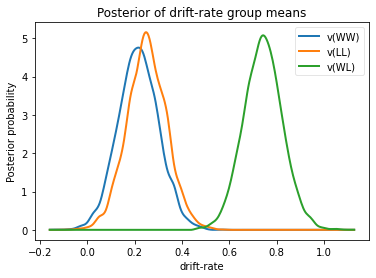

In [20]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [21]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.37975
P(LL > WL) =  0.0


In [22]:
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10970.330687
Stimulus model DIC: 10781.483680


## Within-subject effects

In [23]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [25]:
def run_m_reg(id, data=None, samples=None, burn=None, save_name="cavanagh2011_reg"): 
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
#     m = hddm.HDDMRegressor(data,
#                            "v ~ C(stim, Treatment('WL'))")
    
    m = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))", 
                                   include = ['v', 'a', 't', 'z'],
                                   informative = True,
                                   is_group_model = True)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [26]:
m_reg_list = p_map(partial(run_m_reg, data=data, samples=5000, burn=1000),
                   range(chains))

  0%|          | 0/4 [00:00<?, ?it/s]

No model attribute --> setting up standard HDDM

Set model to ddmNo model attribute --> setting up standard HDDM
No model attribute --> setting up standard HDDMSet model to ddm
Set model to ddm

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


                   0%                  ] 30 of 5000 complete in 17.5 sec [                  0%                  ] 2 of 5000 complete in 1.4 sec[                  0%                  ] 2 of 5000 complete in 1.4 sec[                  0%                  ] 2 of 5000 complete in 1.5 sec[                  0%                  ] 3 of 5000 complete in 2.2 sec[                  0%                  ] 3 of 5000 complete in 2.1 sec[                  0%                  ] 3 of 5000 complete in 2.2 sec[                  0%                  ] 3 of 5000 complete in 2.3 sec[                  0%                  ] 4 of 5000 complete in 2.7 sec[                  0%                  ] 4 of 5000 complete in 2.8 sec[                  0%                  ] 4 of 5000 complete in 2.8 sec[                  0%                  ] 4 of 5000 complete in 3.2 sec[                  0%                  ] 5 of 5000 complete in 3.2 sec[                  0%                  ] 5 of 5000 complete in 3.5 sec[                

[                  1%                  ] 65 of 5000 complete in 37.8 secc[                  0%                  ] 32 of 5000 complete in 19.9 sec[                  0%                  ] 34 of 5000 complete in 20.1 sec[                  0%                  ] 34 of 5000 complete in 20.3 sec[                  0%                  ] 34 of 5000 complete in 20.3 sec[                  0%                  ] 35 of 5000 complete in 20.6 sec  [                  0%                  ] 35 of 5000 complete in 20.9 sec[                  0%                  ] 35 of 5000 complete in 20.8 sec[                  0%                  ] 34 of 5000 complete in 20.9 sec[                  0%                  ] 36 of 5000 complete in 21.4 sec[                  0%                  ] 36 of 5000 complete in 21.3 sec[                  0%                  ] 37 of 5000 complete in 21.6 sec[                  0%                  ] 37 of 5000 complete in 21.9 sec[                  0%                  ] 37 of 5000 complete 

                   1%                  ] 67 of 5000 complete in 40.5 secc  [                  1%                  ] 63 of 5000 complete in 38.3 sec[                  1%                  ] 66 of 5000 complete in 38.3 sec[                  1%                  ] 65 of 5000 complete in 38.4 sec[                  1%                  ] 65 of 5000 complete in 38.7 sec[                  1%                  ] 66 of 5000 complete in 38.9 sec[                  1%                  ] 64 of 5000 complete in 38.8 sec[                  1%                  ] 67 of 5000 complete in 38.8 sec[                  1%                  ] 66 of 5000 complete in 39.3 sec[                  1%                  ] 68 of 5000 complete in 39.4 sec[                  1%                  ] 65 of 5000 complete in 39.4 sec[                  1%                  ] 67 of 5000 complete in 39.5 sec[                  1%                  ] 67 of 5000 complete in 39.9 sec[                  1%                  ] 69 of 5000 complete 

                   2%                  ] 131 of 5000 complete in 74.2 secc[                  1%                  ] 99 of 5000 complete in 57.3 sec[                  2%                  ] 102 of 5000 complete in 57.4 sec[                  2%                  ] 103 of 5000 complete in 57.8 sec[                  2%                  ] 100 of 5000 complete in 57.9 sec[                  2%                  ] 103 of 5000 complete in 57.9 sec[                  2%                  ] 100 of 5000 complete in 58.0 sec[                  2%                  ] 101 of 5000 complete in 58.4 sec[                  2%                  ] 105 of 5000 complete in 58.9 sec[                  2%                  ] 105 of 5000 complete in 58.9 sec[                  2%                  ] 102 of 5000 complete in 58.9 sec[                  2%                  ] 102 of 5000 complete in 59.0 sec[                  2%                  ] 106 of 5000 complete in 59.4 sec  [                  2%                  ] 103 of 5

 -                 3%                  ] 161 of 5000 complete in 89.8 secc[-                 2%                  ] 141 of 5000 complete in 77.5 sec[-                 2%                  ] 137 of 5000 complete in 77.4 sec[-                 2%                  ] 137 of 5000 complete in 77.6 sec[-                 2%                  ] 142 of 5000 complete in 78.0 sec[-                 2%                  ] 139 of 5000 complete in 78.3 sec[-                 2%                  ] 142 of 5000 complete in 78.4 sec[-                 2%                  ] 139 of 5000 complete in 78.5 sec[-                 2%                  ] 144 of 5000 complete in 79.0 sec[-                 2%                  ] 140 of 5000 complete in 78.9 sec[-                 2%                  ] 143 of 5000 complete in 78.9 sec[-                 2%                  ] 140 of 5000 complete in 79.0 sec[-                 2%                  ] 144 of 5000 complete in 79.4 sec[-                 2%                  ] 141 of 50

 [-                 3%                  ] 174 of 5000 complete in 96.6 sec[-                 3%                  ] 177 of 5000 complete in 96.7 sec[-                 3%                  ] 174 of 5000 complete in 96.7 sec[-                 3%                  ] 178 of 5000 complete in 97.1 sec[-                 3%                  ] 175 of 5000 complete in 97.2 sec[-                 3%                  ] 178 of 5000 complete in 97.3 sec[-                 3%                  ] 175 of 5000 complete in 97.4 sec[-                 3%                  ] 179 of 5000 complete in 97.6 sec[-                 3%                  ] 179 of 5000 complete in 97.9 sec[-                 3%                  ] 177 of 5000 complete in 98.2 sec[-                 3%                  ] 177 of 5000 complete in 98.3 sec[-                 3%                  ] 180 of 5000 complete in 98.4 sec[-                 3%                  ] 181 of 5000 complete in 98.6 sec[-                 3%                  ] 178 of 50

 -                 5%                  ] 250 of 5000 complete in 134.0 secc[-                 4%                  ] 213 of 5000 complete in 116.5 sec[-                 4%                  ] 213 of 5000 complete in 116.8 sec[-                 4%                  ] 217 of 5000 complete in 117.0 sec[-                 4%                  ] 214 of 5000 complete in 117.0 sec[-                 4%                  ] 217 of 5000 complete in 117.2 sec[-                 4%                  ] 214 of 5000 complete in 117.3 sec[-                 4%                  ] 218 of 5000 complete in 117.5 sec[-                 4%                  ] 215 of 5000 complete in 117.6 sec[-                 4%                  ] 218 of 5000 complete in 117.7 sec[-                 4%                  ] 215 of 5000 complete in 117.9 sec[-                 4%                  ] 219 of 5000 complete in 118.0 sec[-                 4%                  ] 216 of 5000 complete in 118.1 sec[-                 4%                

 [-                 5%                  ] 251 of 5000 complete in 134.5 sec[-                 4%                  ] 247 of 5000 complete in 134.5 sec[-                 4%                  ] 247 of 5000 complete in 134.7 sec[-                 5%                  ] 252 of 5000 complete in 135.4 sec[-                 4%                  ] 248 of 5000 complete in 135.3 sec[-                 5%                  ] 253 of 5000 complete in 135.4 sec[-                 4%                  ] 249 of 5000 complete in 135.5 sec[-                 5%                  ] 253 of 5000 complete in 135.9 sec[-                 4%                  ] 249 of 5000 complete in 135.8 sec[-                 5%                  ] 250 of 5000 complete in 136.0 sec[-                 5%                  ] 255 of 5000 complete in 136.4 sec[-                 5%                  ] 250 of 5000 complete in 136.4 sec[-                 5%                  ] 251 of 5000 complete in 136.5 sec[-                 5%                

 [--                5%                  ] 286 of 5000 complete in 154.4 sec[--                5%                  ] 290 of 5000 complete in 154.6 sec[--                5%                  ] 286 of 5000 complete in 154.6 sec[--                5%                  ] 290 of 5000 complete in 154.8 sec[--                5%                  ] 287 of 5000 complete in 154.9 sec[--                5%                  ] 291 of 5000 complete in 155.1 sec[--                5%                  ] 287 of 5000 complete in 155.1 sec[--                5%                  ] 291 of 5000 complete in 155.4 sec[--                5%                  ] 288 of 5000 complete in 155.6 sec[--                5%                  ] 292 of 5000 complete in 155.8 sec[--                5%                  ] 288 of 5000 complete in 155.9 sec[--                5%                  ] 292 of 5000 complete in 156.1 sec[--                5%                  ] 289 of 5000 complete in 156.2 sec[--                5%                

 --                6%                  ] 334 of 5000 complete in 177.8 secc[--                6%                  ] 327 of 5000 complete in 174.0 sec[--                6%                  ] 323 of 5000 complete in 174.1 sec[--                6%                  ] 323 of 5000 complete in 174.1 sec[--                6%                  ] 326 of 5000 complete in 174.4 sec[--                6%                  ] 328 of 5000 complete in 174.6 sec[--                6%                  ] 324 of 5000 complete in 174.7 sec[--                6%                  ] 324 of 5000 complete in 174.8 sec[--                6%                  ] 327 of 5000 complete in 174.9 sec[--                6%                  ] 329 of 5000 complete in 175.1 sec[--                6%                  ] 325 of 5000 complete in 175.2 sec[--                6%                  ] 325 of 5000 complete in 175.3 sec[--                6%                  ] 328 of 5000 complete in 175.5 sec[--                6%                

 --                7%                  ] 386 of 5000 complete in 205.8 secc[--                7%                  ] 358 of 5000 complete in 192.7 sec[--                7%                  ] 358 of 5000 complete in 192.8 sec[--                7%                  ] 361 of 5000 complete in 192.8 sec[--                7%                  ] 364 of 5000 complete in 193.2 sec[--                7%                  ] 359 of 5000 complete in 193.2 sec[--                7%                  ] 359 of 5000 complete in 193.3 sec[--                7%                  ] 360 of 5000 complete in 193.7 sec  [--                7%                  ] 360 of 5000 complete in 193.8 sec[--                7%                  ] 363 of 5000 complete in 193.8 sec[--                7%                  ] 366 of 5000 complete in 194.1 sec[--                7%                  ] 361 of 5000 complete in 194.3 sec[--                7%                  ] 361 of 5000 complete in 194.4 sec[--                7%              

 ---               8%                  ] 406 of 5000 complete in 218.4 secc[---               7%                  ] 397 of 5000 complete in 211.8 sec  [--                7%                  ] 394 of 5000 complete in 211.8 sec[---               8%                  ] 400 of 5000 complete in 211.9 sec[--                7%                  ] 394 of 5000 complete in 211.9 sec[---               7%                  ] 395 of 5000 complete in 212.4 sec[---               7%                  ] 398 of 5000 complete in 212.4 sec[---               7%                  ] 395 of 5000 complete in 212.4 sec[---               8%                  ] 402 of 5000 complete in 212.8 sec[---               7%                  ] 396 of 5000 complete in 213.0 sec[---               7%                  ] 399 of 5000 complete in 213.0 sec[---               7%                  ] 397 of 5000 complete in 213.3 sec[---               8%                  ] 400 of 5000 complete in 213.6 sec[---               8%              

 [---               8%                  ] 429 of 5000 complete in 229.1 sec[---               8%                  ] 425 of 5000 complete in 229.2 sec[---               8%                  ] 427 of 5000 complete in 229.3 sec[---               8%                  ] 435 of 5000 complete in 229.6 sec[---               8%                  ] 430 of 5000 complete in 229.6 sec[---               8%                  ] 426 of 5000 complete in 229.7 sec[---               8%                  ] 428 of 5000 complete in 229.8 sec[---               8%                  ] 429 of 5000 complete in 230.4 sec[---               8%                  ] 437 of 5000 complete in 230.6 sec[---               8%                  ] 432 of 5000 complete in 230.6 sec[---               8%                  ] 428 of 5000 complete in 230.8 sec[---               8%                  ] 430 of 5000 complete in 230.9 sec[---               8%                  ] 433 of 5000 complete in 231.2 sec[---               8%                

 [---               9%                  ] 464 of 5000 complete in 247.8 sec[---               9%                  ] 463 of 5000 complete in 247.8 sec[---               9%                  ] 472 of 5000 complete in 248.4 sec[---               9%                  ] 464 of 5000 complete in 248.3 sec[---               9%                  ] 460 of 5000 complete in 248.6 sec[---               9%                  ] 466 of 5000 complete in 248.7 sec[---               9%                  ] 465 of 5000 complete in 248.8 sec[---               9%                  ] 461 of 5000 complete in 249.1 sec[---               9%                  ] 474 of 5000 complete in 249.4 sec[---               9%                  ] 466 of 5000 complete in 249.4 sec[---               9%                  ] 462 of 5000 complete in 249.7 sec[---               9%                  ] 468 of 5000 complete in 249.7 sec[---               9%                  ] 475 of 5000 complete in 249.9 sec[---               9%                

 ---              10%                  ] 520 of 5000 complete in 273.1 secc[---               9%                  ] 494 of 5000 complete in 266.3 sec[---               9%                  ] 499 of 5000 complete in 266.4 sec[---               9%                  ] 499 of 5000 complete in 266.5 sec[---              10%                  ] 508 of 5000 complete in 266.8 sec[---               9%                  ] 495 of 5000 complete in 266.8 sec[---              10%                  ] 500 of 5000 complete in 267.0 sec[---              10%                  ] 500 of 5000 complete in 267.0 sec[---              10%                  ] 509 of 5000 complete in 267.4 sec[---               9%                  ] 496 of 5000 complete in 267.3 sec[---              10%                  ] 501 of 5000 complete in 267.5 sec[---              10%                  ] 501 of 5000 complete in 267.6 sec[---              10%                  ] 510 of 5000 complete in 267.9 sec[---               9%                

 ----             11%                  ] 555 of 5000 complete in 298.3 secc[----             10%                  ] 532 of 5000 complete in 284.8 sec[----             10%                  ] 534 of 5000 complete in 284.9 sec[----             10%                  ] 529 of 5000 complete in 285.1 sec [----             10%                  ] 543 of 5000 complete in 285.5 sec[----             10%                  ] 536 of 5000 complete in 285.8 sec[----             10%                  ] 544 of 5000 complete in 286.0 sec[----             10%                  ] 531 of 5000 complete in 286.0 sec[----             10%                  ] 535 of 5000 complete in 286.3 sec[----             10%                  ] 545 of 5000 complete in 286.6 sec[----             10%                  ] 538 of 5000 complete in 286.8 sec[----             10%                  ] 536 of 5000 complete in 286.9 sec[----             10%                  ] 546 of 5000 complete in 287.1 sec[----             10%               

 ----             11%                  ] 596 of 5000 complete in 320.6 secc[----             11%                  ] 566 of 5000 complete in 303.2 sec[----             11%                  ] 565 of 5000 complete in 303.5 sec[----             11%                  ] 569 of 5000 complete in 303.7 sec[----             11%                  ] 578 of 5000 complete in 304.0 sec[----             11%                  ] 567 of 5000 complete in 304.1 sec[----             11%                  ] 566 of 5000 complete in 304.2 sec[----             11%                  ] 570 of 5000 complete in 304.4 sec[----             11%                  ] 579 of 5000 complete in 304.8 sec[----             11%                  ] 568 of 5000 complete in 304.8 sec[----             11%                  ] 567 of 5000 complete in 304.8 sec[----             11%                  ] 571 of 5000 complete in 304.9 sec[----             11%                  ] 580 of 5000 complete in 305.5 sec[----             11%                

 ----             12%                  ] 619 of 5000 complete in 332.9 secc[----             12%                  ] 612 of 5000 complete in 323.0 sec[----             12%                  ] 601 of 5000 complete in 323.1 sec[----             12%                  ] 601 of 5000 complete in 323.3 sec[----             12%                  ] 604 of 5000 complete in 323.3 sec[----             12%                  ] 613 of 5000 complete in 323.6 sec[----             12%                  ] 602 of 5000 complete in 323.6 sec[----             12%                  ] 605 of 5000 complete in 323.9 sec[----             12%                  ] 614 of 5000 complete in 324.1 sec[----             12%                  ] 603 of 5000 complete in 324.1 sec[----             12%                  ] 603 of 5000 complete in 324.3 sec[----             12%                  ] 606 of 5000 complete in 324.5 sec[----             12%                  ] 615 of 5000 complete in 324.7 sec[----             12%                

 -----            13%                  ] 664 of 5000 complete in 358.0 secc[----             12%                  ] 632 of 5000 complete in 339.9 sec[----             12%                  ] 633 of 5000 complete in 340.1 sec[----             12%                  ] 635 of 5000 complete in 340.1 sec[----             12%                  ] 645 of 5000 complete in 340.5 sec[----             12%                  ] 633 of 5000 complete in 340.5 sec[----             12%                  ] 634 of 5000 complete in 340.6 sec[----             12%                  ] 636 of 5000 complete in 340.7 sec[----             12%                  ] 634 of 5000 complete in 341.0 sec[----             12%                  ] 647 of 5000 complete in 341.4 sec[----             12%                  ] 636 of 5000 complete in 341.5 sec[----             12%                  ] 638 of 5000 complete in 341.7 sec[----             12%                  ] 648 of 5000 complete in 341.9 sec[----             12%                

 [-----            13%                  ] 666 of 5000 complete in 359.3 sec[-----            13%                  ] 666 of 5000 complete in 359.7 sec[-----            13%                  ] 679 of 5000 complete in 360.0 sec  [-----            13%                  ] 667 of 5000 complete in 360.0 sec[-----            13%                  ] 668 of 5000 complete in 360.0 sec[-----            13%                  ] 667 of 5000 complete in 360.3 sec[-----            13%                  ] 668 of 5000 complete in 360.5 sec  [-----            13%                  ] 669 of 5000 complete in 360.5 sec[-----            13%                  ] 680 of 5000 complete in 360.7 sec[-----            13%                  ] 669 of 5000 complete in 361.0 sec[-----            13%                  ] 670 of 5000 complete in 361.1 sec[-----            13%                  ] 681 of 5000 complete in 361.3 sec[-----            13%                  ] 669 of 5000 complete in 361.3 sec[-----            13%            

 -----            14%                  ] 730 of 5000 complete in 391.5 secc[-----            13%                  ] 695 of 5000 complete in 377.6 sec[-----            14%                  ] 708 of 5000 complete in 377.9 sec[-----            13%                  ] 697 of 5000 complete in 378.2 sec [-----            13%                  ] 696 of 5000 complete in 378.3 sec[-----            14%                  ] 709 of 5000 complete in 378.6 sec[-----            13%                  ] 698 of 5000 complete in 378.7 sec[-----            13%                  ] 697 of 5000 complete in 378.8 sec[-----            13%                  ] 697 of 5000 complete in 378.8 sec[-----            14%                  ] 710 of 5000 complete in 379.2 sec[-----            13%                  ] 699 of 5000 complete in 379.3 sec[-----            13%                  ] 698 of 5000 complete in 379.3 sec[-----            13%                  ] 698 of 5000 complete in 379.3 sec[-----            14%               

 -----            14%                  ] 744 of 5000 complete in 409.1 secc[-----            14%                  ] 738 of 5000 complete in 396.9 sec[-----            14%                  ] 726 of 5000 complete in 396.9 sec[-----            14%                  ] 726 of 5000 complete in 397.0 sec[-----            14%                  ] 725 of 5000 complete in 397.3 sec[-----            14%                  ] 739 of 5000 complete in 397.8 sec[-----            14%                  ] 727 of 5000 complete in 397.8 sec[-----            14%                  ] 727 of 5000 complete in 397.9 sec[-----            14%                  ] 726 of 5000 complete in 398.0 sec[-----            14%                  ] 740 of 5000 complete in 398.3 sec[-----            14%                  ] 728 of 5000 complete in 398.4 sec[-----            14%                  ] 728 of 5000 complete in 398.5 sec[-----            14%                  ] 727 of 5000 complete in 398.6 sec[-----            14%                

 -----            15%                  ] 768 of 5000 complete in 424.4 secc[-----            15%                  ] 754 of 5000 complete in 415.4 sec[-----            15%                  ] 767 of 5000 complete in 415.6 sec  [-----            15%                  ] 753 of 5000 complete in 415.5 sec[-----            15%                  ] 754 of 5000 complete in 415.6 sec[-----            15%                  ] 755 of 5000 complete in 416.0 sec[-----            15%                  ] 768 of 5000 complete in 416.2 sec[-----            15%                  ] 754 of 5000 complete in 416.1 sec[-----            15%                  ] 755 of 5000 complete in 416.2 sec[-----            15%                  ] 756 of 5000 complete in 416.6 sec[-----            15%                  ] 769 of 5000 complete in 416.7 sec[-----            15%                  ] 755 of 5000 complete in 416.7 sec[-----            15%                  ] 756 of 5000 complete in 416.7 sec[-----            15%              

 ------           16%                  ] 819 of 5000 complete in 448.9 secc[-----            15%                  ] 782 of 5000 complete in 433.7 sec[------           15%                  ] 795 of 5000 complete in 433.9 sec[-----            15%                  ] 781 of 5000 complete in 434.1 sec[-----            15%                  ] 783 of 5000 complete in 434.2 sec[-----            15%                  ] 783 of 5000 complete in 434.3 sec[------           15%                  ] 796 of 5000 complete in 434.5 sec[-----            15%                  ] 782 of 5000 complete in 434.6 sec[-----            15%                  ] 784 of 5000 complete in 434.8 sec[-----            15%                  ] 784 of 5000 complete in 434.9 sec[------           15%                  ] 797 of 5000 complete in 435.1 sec[-----            15%                  ] 783 of 5000 complete in 435.2 sec[-----            15%                  ] 785 of 5000 complete in 435.5 sec[-----            15%                

 ------           16%                  ] 836 of 5000 complete in 460.0 sec [------           16%                  ] 810 of 5000 complete in 452.4 sec[------           16%                  ] 825 of 5000 complete in 452.8 sec[------           16%                  ] 810 of 5000 complete in 452.9 sec[------           16%                  ] 811 of 5000 complete in 453.0 sec[------           16%                  ] 811 of 5000 complete in 453.1 sec[------           16%                  ] 826 of 5000 complete in 453.4 sec[------           16%                  ] 811 of 5000 complete in 453.6 sec[------           16%                  ] 812 of 5000 complete in 453.6 sec[------           16%                  ] 812 of 5000 complete in 453.6 sec[------           16%                  ] 827 of 5000 complete in 453.9 sec [------           16%                  ] 813 of 5000 complete in 454.2 sec[------           16%                  ] 813 of 5000 complete in 454.2 sec[------           16%               

 ------           17%                  ] 881 of 5000 complete in 487.8 secc[------           16%                  ] 838 of 5000 complete in 471.0 sec[------           16%                  ] 839 of 5000 complete in 471.1 sec[------           16%                  ] 839 of 5000 complete in 471.3 sec[------           17%                  ] 855 of 5000 complete in 471.6 sec[------           16%                  ] 839 of 5000 complete in 471.5 sec[------           16%                  ] 840 of 5000 complete in 471.7 sec[------           16%                  ] 840 of 5000 complete in 471.9 sec[------           16%                  ] 840 of 5000 complete in 472.2 sec[------           17%                  ] 856 of 5000 complete in 472.3 sec[------           16%                  ] 841 of 5000 complete in 472.3 sec[------           16%                  ] 841 of 5000 complete in 472.5 sec[------           16%                  ] 841 of 5000 complete in 472.7 sec[------           17%                

 [------           17%                  ] 883 of 5000 complete in 489.2 sec[------           17%                  ] 869 of 5000 complete in 489.5 sec[------           17%                  ] 868 of 5000 complete in 489.5 sec[------           17%                  ] 884 of 5000 complete in 489.8 sec[------           17%                  ] 868 of 5000 complete in 489.8 sec[------           17%                  ] 870 of 5000 complete in 490.1 sec[------           17%                  ] 869 of 5000 complete in 490.2 sec[------           17%                  ] 885 of 5000 complete in 490.4 sec[------           17%                  ] 869 of 5000 complete in 490.3 sec[------           17%                  ] 870 of 5000 complete in 490.7 sec[------           17%                  ] 886 of 5000 complete in 490.9 sec[------           17%                  ] 870 of 5000 complete in 490.9 sec[------           17%                  ] 872 of 5000 complete in 491.3 sec[------           17%                

 ------           18%                  ] 915 of 5000 complete in 519.1 secc[------           17%                  ] 896 of 5000 complete in 506.9 sec [------           17%                  ] 899 of 5000 complete in 507.3 sec[------           17%                  ] 897 of 5000 complete in 507.4 sec[------           17%                  ] 897 of 5000 complete in 507.5 sec[------           18%                  ] 914 of 5000 complete in 508.0 sec[------           18%                  ] 900 of 5000 complete in 508.0 sec[------           17%                  ] 898 of 5000 complete in 508.0 sec[------           17%                  ] 898 of 5000 complete in 508.1 sec[------           18%                  ] 915 of 5000 complete in 508.5 sec[------           18%                  ] 901 of 5000 complete in 508.5 sec[------           17%                  ] 899 of 5000 complete in 508.6 sec[------           17%                  ] 899 of 5000 complete in 508.6 sec[------           18%               

 -------          18%                  ] 946 of 5000 complete in 538.0 secc[-------          18%                  ] 928 of 5000 complete in 525.6 sec[-------          18%                  ] 925 of 5000 complete in 525.8 sec[-------          18%                  ] 943 of 5000 complete in 526.0 sec[-------          18%                  ] 926 of 5000 complete in 526.0 sec[-------          18%                  ] 929 of 5000 complete in 526.2 sec[-------          18%                  ] 926 of 5000 complete in 526.3 sec[-------          18%                  ] 944 of 5000 complete in 526.6 sec[-------          18%                  ] 927 of 5000 complete in 526.6 sec[-------          18%                  ] 930 of 5000 complete in 526.8 sec[-------          18%                  ] 927 of 5000 complete in 526.9 sec[-------          18%                  ] 945 of 5000 complete in 527.2 sec[-------          18%                  ] 928 of 5000 complete in 527.2 sec[-------          18%                

 -------          19%                  ] 976 of 5000 complete in 556.8 secc[-------          19%                  ] 957 of 5000 complete in 542.9 sec[-------          19%                  ] 971 of 5000 complete in 543.3 sec[-------          19%                  ] 954 of 5000 complete in 543.2 sec[-------          19%                  ] 955 of 5000 complete in 543.5 sec[-------          19%                  ] 958 of 5000 complete in 543.6 sec[-------          19%                  ] 972 of 5000 complete in 544.1 sec[-------          19%                  ] 955 of 5000 complete in 544.0 sec[-------          19%                  ] 959 of 5000 complete in 544.2 sec[-------          19%                  ] 956 of 5000 complete in 544.2 sec[-------          19%                  ] 973 of 5000 complete in 544.6 sec[-------          19%                  ] 956 of 5000 complete in 544.7 sec[-------          19%                  ] 957 of 5000 complete in 544.8 sec[-------          19%                

 [-------          19%                  ] 983 of 5000 complete in 560.3 sec[-------          19%                  ] 982 of 5000 complete in 560.3 sec[-------          19%                  ] 987 of 5000 complete in 560.8 sec[-------          19%                  ] 984 of 5000 complete in 560.8 sec[-------          20%                  ] 1000 of 5000 complete in 561.0 sec[-------          19%                  ] 983 of 5000 complete in 560.9 sec[-------          19%                  ] 985 of 5000 complete in 561.3 sec[-------          19%                  ] 984 of 5000 complete in 561.4 sec[-------          19%                  ] 989 of 5000 complete in 562.0 sec[-------          20%                  ] 1002 of 5000 complete in 562.1 sec[-------          19%                  ] 986 of 5000 complete in 562.0 sec[-------          19%                  ] 985 of 5000 complete in 562.2 sec[-------          20%                  ] 1003 of 5000 complete in 562.7 sec[-------          19%             

 -------          20%                  ] 1034 of 5000 complete in 588.7 secc[-------          20%                  ] 1029 of 5000 complete in 578.2 sec[-------          20%                  ] 1017 of 5000 complete in 578.6 sec[-------          20%                  ] 1030 of 5000 complete in 578.7 sec[-------          20%                  ] 1011 of 5000 complete in 578.7 sec[-------          20%                  ] 1014 of 5000 complete in 579.0 sec[-------          20%                  ] 1018 of 5000 complete in 579.2 sec[-------          20%                  ] 1031 of 5000 complete in 579.4 sec[-------          20%                  ] 1012 of 5000 complete in 579.3 sec[-------          20%                  ] 1019 of 5000 complete in 579.8 sec[-------          20%                  ] 1013 of 5000 complete in 579.8 sec[-------          20%                  ] 1016 of 5000 complete in 580.0 sec[-------          20%                  ] 1033 of 5000 complete in 580.4 sec[-------          20%   

 [-------          20%                  ] 1047 of 5000 complete in 596.4 sec[-------          20%                  ] 1043 of 5000 complete in 596.6 sec[--------         21%                  ] 1060 of 5000 complete in 596.8 sec[-------          20%                  ] 1040 of 5000 complete in 596.9 sec[-------          20%                  ] 1048 of 5000 complete in 597.0 sec[-------          20%                  ] 1044 of 5000 complete in 597.2 sec[--------         21%                  ] 1061 of 5000 complete in 597.4 sec[-------          20%                  ] 1041 of 5000 complete in 597.4 sec[-------          20%                  ] 1049 of 5000 complete in 597.6 sec[-------          20%                  ] 1045 of 5000 complete in 597.7 sec[--------         21%                  ] 1062 of 5000 complete in 597.9 sec[-------          20%                  ] 1042 of 5000 complete in 598.0 sec[-------          21%                  ] 1050 of 5000 complete in 598.1 sec[-------          20%   

 [--------         21%                  ] 1076 of 5000 complete in 614.4 sec[--------         21%                  ] 1088 of 5000 complete in 614.5 sec[--------         21%                  ] 1067 of 5000 complete in 614.8 sec[--------         21%                  ] 1072 of 5000 complete in 615.0 sec[--------         21%                  ] 1077 of 5000 complete in 615.1 sec[--------         21%                  ] 1089 of 5000 complete in 615.3 sec[--------         21%                  ] 1068 of 5000 complete in 615.5 sec[--------         21%                  ] 1073 of 5000 complete in 615.7 sec[--------         21%                  ] 1078 of 5000 complete in 615.7 sec[--------         21%                  ] 1090 of 5000 complete in 616.0 sec[--------         21%                  ] 1069 of 5000 complete in 616.1 sec[--------         21%                  ] 1079 of 5000 complete in 616.3 sec[--------         21%                  ] 1074 of 5000 complete in 616.3 sec[--------         21%   

 --------         22%                  ] 1122 of 5000 complete in 646.4 sec[--------         22%                  ] 1100 of 5000 complete in 632.5 sec[--------         21%                  ] 1096 of 5000 complete in 632.7 sec[--------         22%                  ] 1117 of 5000 complete in 632.9 sec[--------         22%                  ] 1106 of 5000 complete in 632.9 sec[--------         22%                  ] 1101 of 5000 complete in 633.0 sec[--------         21%                  ] 1097 of 5000 complete in 633.3 sec[--------         22%                  ] 1118 of 5000 complete in 633.4 sec[--------         22%                  ] 1107 of 5000 complete in 633.5 sec[--------         22%                  ] 1102 of 5000 complete in 633.5 sec[--------         21%                  ] 1098 of 5000 complete in 634.0 sec[--------         22%                  ] 1119 of 5000 complete in 634.1 sec  [--------         22%                  ] 1103 of 5000 complete in 634.2 sec[--------         22%  

 --------         23%                  ] 1164 of 5000 complete in 661.9 secc[--------         22%                  ] 1135 of 5000 complete in 651.1 sec[--------         22%                  ] 1146 of 5000 complete in 651.2 sec[--------         22%                  ] 1131 of 5000 complete in 651.5 sec[--------         22%                  ] 1136 of 5000 complete in 651.7 sec[--------         22%                  ] 1147 of 5000 complete in 651.9 sec[--------         22%                  ] 1127 of 5000 complete in 651.8 sec[--------         22%                  ] 1132 of 5000 complete in 652.3 sec[--------         22%                  ] 1137 of 5000 complete in 652.4 sec[--------         22%                  ] 1148 of 5000 complete in 652.6 sec[--------         22%                  ] 1128 of 5000 complete in 652.6 sec[--------         22%                  ] 1133 of 5000 complete in 653.0 sec[--------         22%                  ] 1138 of 5000 complete in 653.1 sec[--------         22%   

 ---------        23%                  ] 1188 of 5000 complete in 683.4 secc[--------         23%                  ] 1175 of 5000 complete in 669.0 sec[--------         23%                  ] 1154 of 5000 complete in 668.9 sec[--------         23%                  ] 1165 of 5000 complete in 669.2 sec[--------         23%                  ] 1160 of 5000 complete in 669.3 sec[--------         23%                  ] 1176 of 5000 complete in 669.5 sec[--------         23%                  ] 1155 of 5000 complete in 669.5 sec[--------         23%                  ] 1166 of 5000 complete in 669.8 sec[--------         23%                  ] 1161 of 5000 complete in 669.9 sec[--------         23%                  ] 1177 of 5000 complete in 670.1 sec[--------         23%                  ] 1156 of 5000 complete in 670.0 sec[--------         23%                  ] 1167 of 5000 complete in 670.3 sec[--------         23%                  ] 1162 of 5000 complete in 670.4 sec[--------         23%   

 [---------        23%                  ] 1188 of 5000 complete in 685.8 sec[--------         23%                  ] 1182 of 5000 complete in 686.0 sec[---------        23%                  ] 1193 of 5000 complete in 686.3 sec[---------        24%                  ] 1204 of 5000 complete in 686.5 sec[---------        23%                  ] 1189 of 5000 complete in 686.5 sec[--------         23%                  ] 1183 of 5000 complete in 686.8 sec[---------        24%                  ] 1205 of 5000 complete in 687.2 sec[---------        23%                  ] 1194 of 5000 complete in 687.1 sec[---------        23%                  ] 1190 of 5000 complete in 687.2 sec[--------         23%                  ] 1184 of 5000 complete in 687.5 sec[---------        23%                  ] 1195 of 5000 complete in 687.7 sec[---------        24%                  ] 1206 of 5000 complete in 687.8 sec[---------        23%                  ] 1191 of 5000 complete in 687.8 sec[---------        23%   

 ---------        24%                  ] 1214 of 5000 complete in 706.5 secc[---------        24%                  ] 1210 of 5000 complete in 703.9 sec[---------        24%                  ] 1218 of 5000 complete in 704.0 sec[---------        24%                  ] 1223 of 5000 complete in 704.2 sec[---------        24%                  ] 1234 of 5000 complete in 704.4 sec[---------        24%                  ] 1211 of 5000 complete in 704.4 sec  [---------        24%                  ] 1224 of 5000 complete in 704.7 sec[---------        24%                  ] 1219 of 5000 complete in 704.7 sec[---------        24%                  ] 1235 of 5000 complete in 704.9 sec[---------        24%                  ] 1212 of 5000 complete in 705.1 sec[---------        24%                  ] 1225 of 5000 complete in 705.3 sec[---------        24%                  ] 1220 of 5000 complete in 705.3 sec[---------        24%                  ] 1236 of 5000 complete in 705.6 sec[---------        24% 

 ---------        25%                  ] 1274 of 5000 complete in 734.3 secc[---------        24%                  ] 1237 of 5000 complete in 721.3 sec[---------        25%                  ] 1262 of 5000 complete in 721.5 sec[---------        24%                  ] 1247 of 5000 complete in 721.8 sec[---------        25%                  ] 1253 of 5000 complete in 721.8 sec[---------        24%                  ] 1238 of 5000 complete in 722.0 sec[---------        25%                  ] 1263 of 5000 complete in 722.1 sec[---------        24%                  ] 1248 of 5000 complete in 722.4 sec[---------        25%                  ] 1264 of 5000 complete in 722.6 sec[---------        24%                  ] 1239 of 5000 complete in 722.6 sec[---------        25%                  ] 1255 of 5000 complete in 722.9 sec[---------        24%                  ] 1249 of 5000 complete in 723.0 sec[---------        25%                  ] 1265 of 5000 complete in 723.2 sec[---------        24%   

 [---------        25%                  ] 1281 of 5000 complete in 738.6 sec[---------        25%                  ] 1265 of 5000 complete in 738.6 sec[---------        25%                  ] 1276 of 5000 complete in 738.8 sec[---------        25%                  ] 1292 of 5000 complete in 739.1 sec[---------        25%                  ] 1282 of 5000 complete in 739.1 sec[---------        25%                  ] 1266 of 5000 complete in 739.1 sec[---------        25%                  ] 1277 of 5000 complete in 739.5 sec[---------        25%                  ] 1293 of 5000 complete in 739.7 sec[---------        25%                  ] 1267 of 5000 complete in 739.8 sec[---------        25%                  ] 1283 of 5000 complete in 739.8 sec[---------        25%                  ] 1278 of 5000 complete in 740.2 sec[---------        25%                  ] 1284 of 5000 complete in 740.4 sec[---------        25%                  ] 1268 of 5000 complete in 740.5 sec[---------        25%   

 ----------       26%                  ] 1326 of 5000 complete in 767.3 secc[---------        26%                  ] 1309 of 5000 complete in 756.3 sec[----------       26%                  ] 1320 of 5000 complete in 756.4 sec[---------        26%                  ] 1305 of 5000 complete in 756.5 sec[---------        25%                  ] 1294 of 5000 complete in 756.8 sec[---------        26%                  ] 1310 of 5000 complete in 756.9 sec[----------       26%                  ] 1321 of 5000 complete in 757.0 sec[---------        26%                  ] 1306 of 5000 complete in 757.1 sec[---------        25%                  ] 1295 of 5000 complete in 757.6 sec[----------       26%                  ] 1322 of 5000 complete in 757.7 sec[---------        26%                  ] 1311 of 5000 complete in 757.7 sec[---------        26%                  ] 1307 of 5000 complete in 757.8 sec[---------        25%                  ] 1296 of 5000 complete in 758.1 sec[---------        26%   

 ----------       26%                  ] 1348 of 5000 complete in 780.7 secc[----------       26%                  ] 1321 of 5000 complete in 773.6 sec[----------       26%                  ] 1349 of 5000 complete in 773.8 sec[----------       26%                  ] 1334 of 5000 complete in 774.0 sec[----------       26%                  ] 1337 of 5000 complete in 774.0 sec[----------       26%                  ] 1322 of 5000 complete in 774.2 sec[----------       27%                  ] 1350 of 5000 complete in 774.4 sec  [----------       26%                  ] 1338 of 5000 complete in 774.8 sec[----------       26%                  ] 1335 of 5000 complete in 774.8 sec[----------       26%                  ] 1323 of 5000 complete in 774.9 sec[----------       27%                  ] 1351 of 5000 complete in 775.2 sec[----------       26%                  ] 1339 of 5000 complete in 775.4 sec[----------       26%                  ] 1336 of 5000 complete in 775.4 sec[----------       26% 

 ----------       27%                  ] 1354 of 5000 complete in 794.6 secc[----------       27%                  ] 1379 of 5000 complete in 792.0 sec[----------       27%                  ] 1363 of 5000 complete in 792.4 sec[----------       27%                  ] 1367 of 5000 complete in 792.6 sec [----------       27%                  ] 1380 of 5000 complete in 792.7 sec[----------       27%                  ] 1364 of 5000 complete in 792.9 sec[----------       27%                  ] 1368 of 5000 complete in 793.1 sec[----------       27%                  ] 1352 of 5000 complete in 793.2 sec[----------       27%                  ] 1365 of 5000 complete in 793.6 sec [----------       27%                  ] 1369 of 5000 complete in 793.9 sec[----------       27%                  ] 1382 of 5000 complete in 794.1 sec[----------       27%                  ] 1366 of 5000 complete in 794.4 sec [----------       27%                  ] 1383 of 5000 complete in 794.7 sec[----------       27%

 ----------       28%                  ] 1404 of 5000 complete in 817.7 secc[----------       28%                  ] 1410 of 5000 complete in 810.7 sec[----------       27%                  ] 1397 of 5000 complete in 810.8 sec[----------       27%                  ] 1381 of 5000 complete in 811.0 sec[----------       27%                  ] 1394 of 5000 complete in 811.1 sec[----------       28%                  ] 1411 of 5000 complete in 811.3 sec[----------       27%                  ] 1398 of 5000 complete in 811.4 sec[----------       27%                  ] 1382 of 5000 complete in 811.6 sec[----------       27%                  ] 1395 of 5000 complete in 811.7 sec[----------       28%                  ] 1412 of 5000 complete in 811.9 sec[----------       27%                  ] 1383 of 5000 complete in 812.1 sec[----------       27%                  ] 1396 of 5000 complete in 812.2 sec [----------       28%                  ] 1400 of 5000 complete in 812.5 sec[----------       27%  

 ----------       28%                  ] 1425 of 5000 complete in 838.1 secc[----------       28%                  ] 1440 of 5000 complete in 829.7 sec[----------       28%                  ] 1411 of 5000 complete in 829.8 sec[----------       28%                  ] 1423 of 5000 complete in 829.9 sec[----------       28%                  ] 1428 of 5000 complete in 830.0 sec[----------       28%                  ] 1441 of 5000 complete in 830.2 sec[----------       28%                  ] 1412 of 5000 complete in 830.4 sec[----------       28%                  ] 1424 of 5000 complete in 830.4 sec[----------       28%                  ] 1429 of 5000 complete in 830.6 sec[----------       28%                  ] 1442 of 5000 complete in 830.8 sec[----------       28%                  ] 1413 of 5000 complete in 831.0 sec[----------       28%                  ] 1425 of 5000 complete in 831.0 sec[----------       28%                  ] 1443 of 5000 complete in 831.4 sec[----------       28%   

 [-----------      29%                  ] 1469 of 5000 complete in 847.2 sec[----------       28%                  ] 1440 of 5000 complete in 847.4 sec[-----------      29%                  ] 1452 of 5000 complete in 847.4 sec[-----------      29%                  ] 1458 of 5000 complete in 847.6 sec[-----------      29%                  ] 1470 of 5000 complete in 847.9 sec[----------       28%                  ] 1441 of 5000 complete in 848.0 sec[-----------      29%                  ] 1453 of 5000 complete in 848.1 sec[-----------      29%                  ] 1459 of 5000 complete in 848.3 sec[-----------      29%                  ] 1471 of 5000 complete in 848.6 sec[----------       28%                  ] 1442 of 5000 complete in 848.6 sec[-----------      29%                  ] 1454 of 5000 complete in 848.7 sec[-----------      29%                  ] 1460 of 5000 complete in 849.0 sec[-----------      29%                  ] 1472 of 5000 complete in 849.2 sec[----------       28%   

 [-----------      29%                  ] 1481 of 5000 complete in 865.3 sec[-----------      29%                  ] 1469 of 5000 complete in 865.4 sec[-----------      29%                  ] 1499 of 5000 complete in 865.7 sec[-----------      29%                  ] 1488 of 5000 complete in 865.6 sec[-----------      29%                  ] 1482 of 5000 complete in 865.9 sec[-----------      29%                  ] 1470 of 5000 complete in 866.0 sec[-----------      30%                  ] 1500 of 5000 complete in 866.5 sec[-----------      29%                  ] 1489 of 5000 complete in 866.5 sec[-----------      29%                  ] 1483 of 5000 complete in 866.9 sec[-----------      29%                  ] 1471 of 5000 complete in 867.0 sec[-----------      30%                  ] 1501 of 5000 complete in 867.5 sec[-----------      29%                  ] 1490 of 5000 complete in 867.4 sec[-----------      29%                  ] 1472 of 5000 complete in 868.0 sec[-----------      29%   

  [-----------      30%                  ] 1509 of 5000 complete in 885.2 sec[-----------      30%                  ] 1527 of 5000 complete in 885.3 sec[-----------      30%                  ] 1516 of 5000 complete in 885.3 sec[-----------      29%                  ] 1497 of 5000 complete in 885.8 sec[-----------      30%                  ] 1528 of 5000 complete in 885.9 sec[-----------      30%                  ] 1510 of 5000 complete in 885.9 sec[-----------      30%                  ] 1517 of 5000 complete in 885.9 sec[-----------      30%                  ] 1529 of 5000 complete in 886.5 sec[-----------      30%                  ] 1518 of 5000 complete in 886.4 sec[-----------      30%                  ] 1511 of 5000 complete in 886.5 sec[-----------      29%                  ] 1499 of 5000 complete in 886.8 sec[-----------      30%                  ] 1530 of 5000 complete in 887.0 sec[-----------      30%                  ] 1519 of 5000 complete in 887.0 sec[-----------      30%  

 -----------      31%                  ] 1563 of 5000 complete in 913.3 secc[-----------      30%                  ] 1546 of 5000 complete in 902.9 sec[-----------      30%                  ] 1539 of 5000 complete in 902.9 sec[-----------      30%                  ] 1524 of 5000 complete in 902.9 sec[-----------      31%                  ] 1558 of 5000 complete in 903.2 sec[-----------      30%                  ] 1547 of 5000 complete in 903.5 sec[-----------      30%                  ] 1540 of 5000 complete in 903.6 sec[-----------      30%                  ] 1525 of 5000 complete in 903.7 sec[-----------      31%                  ] 1559 of 5000 complete in 904.0 sec[-----------      30%                  ] 1548 of 5000 complete in 904.4 sec  [-----------      30%                  ] 1541 of 5000 complete in 904.5 sec[-----------      30%                  ] 1526 of 5000 complete in 904.5 sec[-----------      31%                  ] 1560 of 5000 complete in 904.8 sec[-----------      30% 

 -----------      31%                  ] 1573 of 5000 complete in 923.9 secc[-----------      31%                  ] 1568 of 5000 complete in 920.7 sec[------------     31%                  ] 1587 of 5000 complete in 921.0 sec[-----------      31%                  ] 1576 of 5000 complete in 921.0 sec[-----------      31%                  ] 1569 of 5000 complete in 921.3 sec[-----------      31%                  ] 1552 of 5000 complete in 921.3 sec[------------     31%                  ] 1588 of 5000 complete in 921.5 sec[-----------      31%                  ] 1577 of 5000 complete in 921.5 sec[-----------      31%                  ] 1570 of 5000 complete in 921.9 sec[-----------      31%                  ] 1553 of 5000 complete in 921.9 sec[------------     31%                  ] 1589 of 5000 complete in 922.1 sec[-----------      31%                  ] 1578 of 5000 complete in 922.1 sec[-----------      31%                  ] 1571 of 5000 complete in 922.5 sec[------------     31%   

 ------------     32%                  ] 1615 of 5000 complete in 949.0 secc[-----------      31%                  ] 1578 of 5000 complete in 939.0 sec[------------     31%                  ] 1598 of 5000 complete in 939.1 sec[------------     32%                  ] 1606 of 5000 complete in 939.3 sec[------------     32%                  ] 1618 of 5000 complete in 939.6 sec[------------     31%                  ] 1579 of 5000 complete in 939.6 sec[------------     31%                  ] 1599 of 5000 complete in 939.7 sec[------------     32%                  ] 1607 of 5000 complete in 939.9 sec[------------     32%                  ] 1619 of 5000 complete in 940.1 sec[------------     31%                  ] 1580 of 5000 complete in 940.3 sec[------------     32%                  ] 1608 of 5000 complete in 940.4 sec[------------     32%                  ] 1620 of 5000 complete in 940.7 sec[------------     32%                  ] 1601 of 5000 complete in 940.7 sec[------------     31%   

 [------------     32%                  ] 1604 of 5000 complete in 956.8 sec[------------     32%                  ] 1628 of 5000 complete in 957.1 sec[------------     32%                  ] 1636 of 5000 complete in 957.2 sec[------------     32%                  ] 1648 of 5000 complete in 957.5 sec[------------     32%                  ] 1605 of 5000 complete in 957.6 sec[------------     32%                  ] 1629 of 5000 complete in 957.8 sec[------------     32%                  ] 1637 of 5000 complete in 957.9 sec[------------     32%                  ] 1649 of 5000 complete in 958.1 sec[------------     32%                  ] 1606 of 5000 complete in 958.3 sec[------------     32%                  ] 1630 of 5000 complete in 958.3 sec[------------     32%                  ] 1638 of 5000 complete in 958.4 sec[------------     33%                  ] 1650 of 5000 complete in 958.6 sec[------------     32%                  ] 1639 of 5000 complete in 959.0 sec[------------     32%   

 ------------     33%                  ] 1682 of 5000 complete in 990.6 secc[------------     33%                  ] 1677 of 5000 complete in 974.8 sec[------------     33%                  ] 1665 of 5000 complete in 974.7 sec[------------     33%                  ] 1658 of 5000 complete in 975.2 sec[------------     32%                  ] 1630 of 5000 complete in 975.2 sec[------------     33%                  ] 1666 of 5000 complete in 975.3 sec[------------     33%                  ] 1678 of 5000 complete in 975.5 sec[------------     33%                  ] 1659 of 5000 complete in 975.8 sec[------------     32%                  ] 1631 of 5000 complete in 975.9 sec[------------     33%                  ] 1667 of 5000 complete in 976.0 sec[------------     33%                  ] 1679 of 5000 complete in 976.2 sec[------------     33%                  ] 1660 of 5000 complete in 976.6 sec[------------     33%                  ] 1668 of 5000 complete in 976.8 sec[------------     32%   

 [------------     33%                  ] 1686 of 5000 complete in 992.8 sec[------------     33%                  ] 1694 of 5000 complete in 993.0 sec[------------     34%                  ] 1706 of 5000 complete in 993.3 sec[------------     33%                  ] 1654 of 5000 complete in 993.3 sec[------------     33%                  ] 1687 of 5000 complete in 993.4 sec[------------     33%                  ] 1695 of 5000 complete in 993.5 sec[------------     34%                  ] 1707 of 5000 complete in 993.8 sec[------------     33%                  ] 1688 of 5000 complete in 994.0 sec[------------     33%                  ] 1696 of 5000 complete in 994.1 sec[------------     33%                  ] 1655 of 5000 complete in 994.2 sec[------------     34%                  ] 1708 of 5000 complete in 994.5 sec[------------     33%                  ] 1697 of 5000 complete in 994.8 sec[------------     33%                  ] 1689 of 5000 complete in 994.8 sec[------------     33%   

 [-------------    34%                  ] 1734 of 5000 complete in 1010.4 sec[-------------    34%                  ] 1714 of 5000 complete in 1010.4 sec[-------------    34%                  ] 1723 of 5000 complete in 1010.5 sec[-------------    34%                  ] 1735 of 5000 complete in 1010.9 sec[------------     33%                  ] 1679 of 5000 complete in 1010.9 sec[-------------    34%                  ] 1724 of 5000 complete in 1011.0 sec[-------------    34%                  ] 1715 of 5000 complete in 1011.0 sec[-------------    34%                  ] 1736 of 5000 complete in 1011.6 sec[-------------    34%                  ] 1725 of 5000 complete in 1011.6 sec[-------------    34%                  ] 1716 of 5000 complete in 1011.6 sec[------------     33%                  ] 1680 of 5000 complete in 1011.8 sec[-------------    34%                  ] 1737 of 5000 complete in 1012.3 sec[-------------    34%                  ] 1726 of 5000 complete in 1012.3 sec[----------

 ------------     34%                  ] 1706 of 5000 complete in 1028.8 secc[-------------    35%                  ] 1755 of 5000 complete in 1027.6 sec[-------------    35%                  ] 1765 of 5000 complete in 1027.8 sec[-------------    34%                  ] 1745 of 5000 complete in 1027.8 sec[-------------    35%                  ] 1756 of 5000 complete in 1028.1 sec[------------     34%                  ] 1705 of 5000 complete in 1028.2 sec[-------------    35%                  ] 1766 of 5000 complete in 1028.3 sec[-------------    34%                  ] 1746 of 5000 complete in 1028.3 sec[-------------    35%                  ] 1767 of 5000 complete in 1028.9 sec [-------------    34%                  ] 1747 of 5000 complete in 1028.8 sec[-------------    35%                  ] 1758 of 5000 complete in 1029.1 sec[-------------    34%                  ] 1748 of 5000 complete in 1029.3 sec[------------     34%                  ] 1707 of 5000 complete in 1029.4 sec[---------

 -------------    36%                  ] 1814 of 5000 complete in 1053.7 secc[-------------    34%                  ] 1732 of 5000 complete in 1044.8 sec[-------------    35%                  ] 1777 of 5000 complete in 1045.1 sec[-------------    35%                  ] 1789 of 5000 complete in 1045.2 sec[-------------    35%                  ] 1798 of 5000 complete in 1045.4 sec[-------------    34%                  ] 1733 of 5000 complete in 1045.4 sec[-------------    35%                  ] 1778 of 5000 complete in 1045.6 sec[-------------    35%                  ] 1790 of 5000 complete in 1045.8 sec[-------------    35%                  ] 1799 of 5000 complete in 1046.0 sec[-------------    34%                  ] 1734 of 5000 complete in 1046.1 sec[-------------    35%                  ] 1791 of 5000 complete in 1046.3 sec[-------------    36%                  ] 1800 of 5000 complete in 1046.5 sec[-------------    35%                  ] 1780 of 5000 complete in 1046.6 sec[----------

 -------------    36%                  ] 1830 of 5000 complete in 1066.9 secc[-------------    36%                  ] 1808 of 5000 complete in 1061.8 sec[-------------    35%                  ] 1760 of 5000 complete in 1062.2 sec[-------------    36%                  ] 1830 of 5000 complete in 1062.3 sec[-------------    36%                  ] 1821 of 5000 complete in 1062.3 sec[-------------    36%                  ] 1809 of 5000 complete in 1062.4 sec[-------------    35%                  ] 1761 of 5000 complete in 1062.8 sec[-------------    36%                  ] 1823 of 5000 complete in 1063.2 sec[-------------    36%                  ] 1832 of 5000 complete in 1063.3 sec[-------------    35%                  ] 1762 of 5000 complete in 1063.3 sec[-------------    36%                  ] 1811 of 5000 complete in 1063.4 sec[-------------    36%                  ] 1824 of 5000 complete in 1063.7 sec[-------------    36%                  ] 1833 of 5000 complete in 1063.9 sec[----------

 -------------    36%                  ] 1818 of 5000 complete in 1096.8 secc[-------------    36%                  ] 1842 of 5000 complete in 1079.9 sec[--------------   37%                  ] 1864 of 5000 complete in 1080.1 sec[-------------    35%                  ] 1789 of 5000 complete in 1080.1 sec[--------------   37%                  ] 1856 of 5000 complete in 1080.4 sec[--------------   36%                  ] 1843 of 5000 complete in 1080.4 sec[--------------   37%                  ] 1865 of 5000 complete in 1080.6 sec[-------------    35%                  ] 1790 of 5000 complete in 1080.7 sec[--------------   37%                  ] 1857 of 5000 complete in 1080.9 sec[--------------   37%                  ] 1866 of 5000 complete in 1081.1 sec[-------------    35%                  ] 1791 of 5000 complete in 1081.3 sec[--------------   37%                  ] 1858 of 5000 complete in 1081.4 sec[--------------   36%                  ] 1845 of 5000 complete in 1081.5 sec[----------

 [--------------   37%                  ] 1874 of 5000 complete in 1097.3 sec[-------------    36%                  ] 1819 of 5000 complete in 1097.4 sec[--------------   37%                  ] 1888 of 5000 complete in 1097.5 sec[--------------   37%                  ] 1898 of 5000 complete in 1097.6 sec[--------------   37%                  ] 1875 of 5000 complete in 1097.9 sec[-------------    36%                  ] 1820 of 5000 complete in 1098.0 sec[--------------   37%                  ] 1889 of 5000 complete in 1098.0 sec[--------------   37%                  ] 1899 of 5000 complete in 1098.2 sec[--------------   37%                  ] 1876 of 5000 complete in 1098.5 sec[-------------    36%                  ] 1821 of 5000 complete in 1098.5 sec[--------------   38%                  ] 1900 of 5000 complete in 1098.8 sec[--------------   37%                  ] 1891 of 5000 complete in 1099.0 sec[--------------   37%                  ] 1877 of 5000 complete in 1099.0 sec[----------

 --------------   38%                  ] 1915 of 5000 complete in 1119.6 secc[--------------   36%                  ] 1848 of 5000 complete in 1114.3 sec[--------------   38%                  ] 1906 of 5000 complete in 1114.5 sec[--------------   38%                  ] 1921 of 5000 complete in 1114.7 sec[--------------   36%                  ] 1849 of 5000 complete in 1114.8 sec[--------------   38%                  ] 1930 of 5000 complete in 1114.9 sec[--------------   38%                  ] 1907 of 5000 complete in 1115.0 sec[--------------   38%                  ] 1922 of 5000 complete in 1115.2 sec[--------------   38%                  ] 1931 of 5000 complete in 1115.5 sec[--------------   37%                  ] 1850 of 5000 complete in 1115.5 sec[--------------   38%                  ] 1908 of 5000 complete in 1115.6 sec[--------------   38%                  ] 1923 of 5000 complete in 1116.0 sec[--------------   38%                  ] 1932 of 5000 complete in 1116.2 sec[----------

 [--------------   37%                  ] 1878 of 5000 complete in 1132.1 sec[--------------   38%                  ] 1939 of 5000 complete in 1132.4 sec[--------------   39%                  ] 1954 of 5000 complete in 1132.6 sec[--------------   39%                  ] 1963 of 5000 complete in 1132.7 sec[--------------   37%                  ] 1880 of 5000 complete in 1133.0 sec[--------------   39%                  ] 1964 of 5000 complete in 1133.2 sec[--------------   39%                  ] 1955 of 5000 complete in 1133.1 sec[--------------   38%                  ] 1941 of 5000 complete in 1133.3 sec[--------------   37%                  ] 1881 of 5000 complete in 1133.7 sec[--------------   39%                  ] 1956 of 5000 complete in 1133.7 sec[--------------   38%                  ] 1942 of 5000 complete in 1133.9 sec[--------------   39%                  ] 1966 of 5000 complete in 1134.1 sec[--------------   39%                  ] 1957 of 5000 complete in 1134.2 sec[----------

 [---------------  39%                  ] 1988 of 5000 complete in 1149.9 sec[---------------  39%                  ] 1997 of 5000 complete in 1150.1 sec[--------------   39%                  ] 1972 of 5000 complete in 1150.3 sec[--------------   38%                  ] 1912 of 5000 complete in 1150.4 sec[---------------  39%                  ] 1989 of 5000 complete in 1150.4 sec[---------------  39%                  ] 1998 of 5000 complete in 1150.6 sec[--------------   39%                  ] 1973 of 5000 complete in 1150.9 sec[--------------   38%                  ] 1913 of 5000 complete in 1150.9 sec[---------------  39%                  ] 1990 of 5000 complete in 1151.0 sec[---------------  39%                  ] 1974 of 5000 complete in 1151.4 sec[---------------  40%                  ] 2000 of 5000 complete in 1151.6 sec[--------------   38%                  ] 1914 of 5000 complete in 1151.6 sec[---------------  39%                  ] 1992 of 5000 complete in 1151.9 sec[----------

 ---------------  39%                  ] 1975 of 5000 complete in 1183.7 secc[--------------   38%                  ] 1945 of 5000 complete in 1167.9 sec[---------------  40%                  ] 2005 of 5000 complete in 1168.1 sec[---------------  40%                  ] 2033 of 5000 complete in 1168.5 sec[---------------  40%                  ] 2024 of 5000 complete in 1168.5 sec[---------------  40%                  ] 2006 of 5000 complete in 1168.7 sec[--------------   38%                  ] 1947 of 5000 complete in 1168.9 sec[---------------  40%                  ] 2034 of 5000 complete in 1169.1 sec[---------------  40%                  ] 2025 of 5000 complete in 1169.1 sec[---------------  40%                  ] 2007 of 5000 complete in 1169.3 sec[--------------   38%                  ] 1948 of 5000 complete in 1169.5 sec[---------------  40%                  ] 2008 of 5000 complete in 1169.8 sec[---------------  40%                  ] 2036 of 5000 complete in 1170.0 sec[----------

 ---------------  41%                  ] 2050 of 5000 complete in 1192.1 secc[---------------  39%                  ] 1982 of 5000 complete in 1187.2 sec[---------------  41%                  ] 2060 of 5000 complete in 1187.3 sec[---------------  41%                  ] 2070 of 5000 complete in 1187.5 sec[---------------  40%                  ] 2041 of 5000 complete in 1187.4 sec[---------------  41%                  ] 2061 of 5000 complete in 1187.8 sec[---------------  39%                  ] 1983 of 5000 complete in 1187.8 sec[---------------  41%                  ] 2071 of 5000 complete in 1188.0 sec[---------------  40%                  ] 2042 of 5000 complete in 1188.0 sec  [---------------  39%                  ] 1984 of 5000 complete in 1188.4 sec[---------------  41%                  ] 2062 of 5000 complete in 1188.4 sec[---------------  41%                  ] 2073 of 5000 complete in 1189.0 sec[---------------  39%                  ] 1985 of 5000 complete in 1188.9 sec[--------

 ---------------- 42%                  ] 2113 of 5000 complete in 1217.9 secc[---------------  40%                  ] 2015 of 5000 complete in 1205.4 sec [---------------  41%                  ] 2094 of 5000 complete in 1205.8 sec[---------------  41%                  ] 2074 of 5000 complete in 1205.9 sec[---------------  40%                  ] 2016 of 5000 complete in 1206.0 sec  [---------------  42%                  ] 2105 of 5000 complete in 1206.5 sec[---------------  41%                  ] 2095 of 5000 complete in 1206.4 sec[---------------  40%                  ] 2017 of 5000 complete in 1206.6 sec[---------------  41%                  ] 2075 of 5000 complete in 1206.6 sec[---------------  41%                  ] 2096 of 5000 complete in 1207.1 sec[---------------- 42%                  ] 2106 of 5000 complete in 1207.3 sec[---------------  40%                  ] 2018 of 5000 complete in 1207.2 sec[---------------  41%                  ] 2076 of 5000 complete in 1207.3 sec[-------

 ---------------  41%                  ] 2068 of 5000 complete in 1236.4 secc[---------------- 42%                  ] 2122 of 5000 complete in 1223.0 sec[---------------- 42%                  ] 2132 of 5000 complete in 1223.5 sec [---------------- 42%                  ] 2123 of 5000 complete in 1223.6 sec [---------------  40%                  ] 2045 of 5000 complete in 1223.6 sec[---------------  42%                  ] 2103 of 5000 complete in 1223.8 sec[---------------- 42%                  ] 2133 of 5000 complete in 1224.0 sec[---------------- 42%                  ] 2124 of 5000 complete in 1224.1 sec[---------------  40%                  ] 2046 of 5000 complete in 1224.2 sec[---------------  42%                  ] 2105 of 5000 complete in 1224.9 sec[---------------- 42%                  ] 2135 of 5000 complete in 1225.1 sec[---------------- 42%                  ] 2126 of 5000 complete in 1225.1 sec[---------------  40%                  ] 2048 of 5000 complete in 1225.2 sec[--------

 ---------------- 42%                  ] 2107 of 5000 complete in 1257.0 secc[---------------- 43%                  ] 2167 of 5000 complete in 1242.4 sec[---------------- 43%                  ] 2158 of 5000 complete in 1242.4 sec[---------------- 42%                  ] 2137 of 5000 complete in 1242.5 sec[---------------  41%                  ] 2080 of 5000 complete in 1242.7 sec[---------------- 43%                  ] 2168 of 5000 complete in 1242.9 sec[---------------- 43%                  ] 2159 of 5000 complete in 1243.0 sec[---------------- 42%                  ] 2138 of 5000 complete in 1243.0 sec[---------------  41%                  ] 2081 of 5000 complete in 1243.3 sec[---------------- 43%                  ] 2169 of 5000 complete in 1243.5 sec[---------------- 43%                  ] 2160 of 5000 complete in 1243.5 sec[---------------  41%                  ] 2082 of 5000 complete in 1243.8 sec[---------------- 43%                  ] 2170 of 5000 complete in 1244.1 sec[----------

 [---------------- 42%                  ] 2113 of 5000 complete in 1260.2 sec[---------------- 44%                  ] 2201 of 5000 complete in 1260.4 sec[---------------- 43%                  ] 2171 of 5000 complete in 1260.5 sec[---------------- 43%                  ] 2192 of 5000 complete in 1260.6 sec[---------------- 44%                  ] 2202 of 5000 complete in 1261.0 sec[---------------- 43%                  ] 2172 of 5000 complete in 1261.0 sec[---------------- 42%                  ] 2115 of 5000 complete in 1261.1 sec[---------------- 43%                  ] 2193 of 5000 complete in 1261.2 sec[---------------- 42%                  ] 2116 of 5000 complete in 1261.6 sec[---------------- 43%                  ] 2194 of 5000 complete in 1261.7 sec[---------------- 44%                  ] 2204 of 5000 complete in 1262.0 sec[---------------- 43%                  ] 2174 of 5000 complete in 1261.9 sec[---------------- 42%                  ] 2117 of 5000 complete in 1262.2 sec[----------

[---------------- 43%                  ] 2182 of 5000 complete in 1295.7 secc[---------------- 44%                  ] 2205 of 5000 complete in 1278.4 sec[---------------- 44%                  ] 2235 of 5000 complete in 1278.6 sec[---------------- 44%                  ] 2226 of 5000 complete in 1278.7 sec[---------------- 42%                  ] 2149 of 5000 complete in 1278.7 sec[---------------- 44%                  ] 2236 of 5000 complete in 1279.2 sec[---------------- 43%                  ] 2150 of 5000 complete in 1279.2 sec[---------------- 44%                  ] 2207 of 5000 complete in 1279.3 sec[-----------------44%                  ] 2237 of 5000 complete in 1279.7 sec[---------------- 44%                  ] 2228 of 5000 complete in 1279.6 sec[---------------- 44%                  ] 2208 of 5000 complete in 1279.9 sec  [---------------- 44%                  ] 2229 of 5000 complete in 1280.2 sec[-----------------44%                  ] 2238 of 5000 complete in 1280.3 sec[--------

[---------------- 44%                  ] 2220 of 5000 complete in 1315.2 secc[---------------- 43%                  ] 2183 of 5000 complete in 1296.3 sec[-----------------45%                  ] 2260 of 5000 complete in 1296.3 sec[-----------------45%                  ] 2268 of 5000 complete in 1296.4 sec[-----------------44%                  ] 2240 of 5000 complete in 1296.5 sec[---------------- 43%                  ] 2184 of 5000 complete in 1296.8 sec[-----------------45%                  ] 2261 of 5000 complete in 1296.8 sec[-----------------45%                  ] 2270 of 5000 complete in 1297.4 sec[-----------------44%                  ] 2242 of 5000 complete in 1297.5 sec[---------------- 43%                  ] 2186 of 5000 complete in 1297.7 sec[-----------------45%                  ] 2271 of 5000 complete in 1297.9 sec[-----------------45%                  ] 2263 of 5000 complete in 1297.9 sec[---------------- 43%                  ] 2187 of 5000 complete in 1298.2 sec[----------

 -----------------46%                  ] 2320 of 5000 complete in 1324.0 secc[-----------------45%                  ] 2296 of 5000 complete in 1315.4 sec[---------------- 44%                  ] 2221 of 5000 complete in 1315.8 sec[-----------------46%                  ] 2305 of 5000 complete in 1315.9 sec[-----------------45%                  ] 2297 of 5000 complete in 1315.9 sec[-----------------45%                  ] 2277 of 5000 complete in 1315.9 sec[---------------- 44%                  ] 2222 of 5000 complete in 1316.3 sec[-----------------45%                  ] 2278 of 5000 complete in 1316.4 sec[-----------------45%                  ] 2298 of 5000 complete in 1316.5 sec[---------------- 44%                  ] 2223 of 5000 complete in 1316.8 sec[-----------------46%                  ] 2307 of 5000 complete in 1316.9 sec[-----------------45%                  ] 2279 of 5000 complete in 1317.0 sec[-----------------45%                  ] 2299 of 5000 complete in 1317.0 sec[----------

 -----------------45%                  ] 2289 of 5000 complete in 1351.0 secc[-----------------45%                  ] 2255 of 5000 complete in 1333.4 sec[-----------------45%                  ] 2256 of 5000 complete in 1333.9 sec[-----------------46%                  ] 2332 of 5000 complete in 1334.0 sec[-----------------46%                  ] 2340 of 5000 complete in 1334.2 sec[-----------------46%                  ] 2312 of 5000 complete in 1334.3 sec[-----------------45%                  ] 2257 of 5000 complete in 1334.4 sec[-----------------46%                  ] 2333 of 5000 complete in 1334.6 sec[-----------------46%                  ] 2341 of 5000 complete in 1334.8 sec[-----------------46%                  ] 2313 of 5000 complete in 1334.9 sec[-----------------45%                  ] 2258 of 5000 complete in 1335.0 sec[-----------------46%                  ] 2342 of 5000 complete in 1335.3 sec[-----------------46%                  ] 2334 of 5000 complete in 1335.2 sec[----------

 -----------------47%                  ] 2397 of 5000 complete in 1368.4 secc[-----------------45%                  ] 2292 of 5000 complete in 1352.6 sec[-----------------46%                  ] 2347 of 5000 complete in 1352.6 sec[-----------------47%                  ] 2377 of 5000 complete in 1353.0 sec[-----------------47%                  ] 2368 of 5000 complete in 1353.0 sec[-----------------45%                  ] 2293 of 5000 complete in 1353.1 sec[-----------------46%                  ] 2349 of 5000 complete in 1353.6 sec[-----------------47%                  ] 2379 of 5000 complete in 1354.0 sec[-----------------47%                  ] 2370 of 5000 complete in 1354.0 sec[-----------------45%                  ] 2295 of 5000 complete in 1354.1 sec[-----------------47%                  ] 2350 of 5000 complete in 1354.2 sec[-----------------47%                  ] 2371 of 5000 complete in 1354.5 sec[-----------------45%                  ] 2296 of 5000 complete in 1354.6 sec[----------

 -----------------48%                  ] 2430 of 5000 complete in 1385.1 secc[-----------------48%                  ] 2412 of 5000 complete in 1371.5 sec[-----------------48%                  ] 2403 of 5000 complete in 1371.4 sec[-----------------46%                  ] 2327 of 5000 complete in 1371.4 sec[-----------------47%                  ] 2382 of 5000 complete in 1371.4 sec[-----------------48%                  ] 2413 of 5000 complete in 1372.0 sec[-----------------46%                  ] 2328 of 5000 complete in 1371.9 sec[-----------------48%                  ] 2405 of 5000 complete in 1372.4 sec[-----------------47%                  ] 2384 of 5000 complete in 1372.4 sec[-----------------46%                  ] 2329 of 5000 complete in 1372.5 sec[-----------------48%                  ] 2414 of 5000 complete in 1372.6 sec[-----------------48%                  ] 2406 of 5000 complete in 1373.0 sec[-----------------47%                  ] 2385 of 5000 complete in 1373.0 sec[----------

 [-----------------48%                  ] 2446 of 5000 complete in 1389.5 sec[-----------------48%                  ] 2439 of 5000 complete in 1389.6 sec[-----------------48%                  ] 2418 of 5000 complete in 1389.8 sec[-----------------47%                  ] 2362 of 5000 complete in 1389.9 sec[-----------------48%                  ] 2447 of 5000 complete in 1390.1 sec[-----------------48%                  ] 2440 of 5000 complete in 1390.2 sec[-----------------48%                  ] 2419 of 5000 complete in 1390.3 sec[-----------------48%                  ] 2448 of 5000 complete in 1390.6 sec[-----------------47%                  ] 2364 of 5000 complete in 1390.9 sec[-----------------48%                  ] 2449 of 5000 complete in 1391.1 sec[-----------------48%                  ] 2442 of 5000 complete in 1391.2 sec[-----------------48%                  ] 2421 of 5000 complete in 1391.3 sec[-----------------47%                  ] 2365 of 5000 complete in 1391.5 sec[----------

 -----------------49%                  ] 2496 of 5000 complete in 1415.7 secc[-----------------49%                  ] 2481 of 5000 complete in 1407.6 sec[-----------------49%                  ] 2452 of 5000 complete in 1407.6 sec[-----------------47%                  ] 2396 of 5000 complete in 1407.6 sec[-----------------49%                  ] 2482 of 5000 complete in 1408.1 sec[-----------------49%                  ] 2453 of 5000 complete in 1408.1 sec[-----------------47%                  ] 2397 of 5000 complete in 1408.2 sec[-----------------49%                  ] 2475 of 5000 complete in 1408.2 sec[-----------------49%                  ] 2483 of 5000 complete in 1408.7 sec[-----------------49%                  ] 2454 of 5000 complete in 1408.7 sec[-----------------47%                  ] 2398 of 5000 complete in 1408.7 sec[-----------------49%                  ] 2476 of 5000 complete in 1408.8 sec[-----------------49%                  ] 2484 of 5000 complete in 1409.2 sec[----------

 -----------------49%                  ] 2488 of 5000 complete in 1427.5 secc[-----------------50%                  ] 2506 of 5000 complete in 1425.6 sec[-----------------50%                  ] 2515 of 5000 complete in 1425.7 sec[-----------------49%                  ] 2485 of 5000 complete in 1425.9 sec[-----------------48%                  ] 2430 of 5000 complete in 1426.0 sec[-----------------50%                  ] 2516 of 5000 complete in 1426.2 sec[-----------------49%                  ] 2486 of 5000 complete in 1426.4 sec[-----------------50%                  ] 2508 of 5000 complete in 1426.5 sec[-----------------48%                  ] 2431 of 5000 complete in 1426.5 sec[-----------------50%                  ] 2517 of 5000 complete in 1426.7 sec[-----------------48%                  ] 2432 of 5000 complete in 1427.0 sec[-----------------50%                  ] 2509 of 5000 complete in 1427.0 sec[-----------------49%                  ] 2487 of 5000 complete in 1427.0 sec[----------

 [-----------------50%                  ] 2549 of 5000 complete in 1443.0 sec[-----------------49%                  ] 2462 of 5000 complete in 1443.3 sec[-----------------50%                  ] 2517 of 5000 complete in 1443.3 sec[-----------------51%                  ] 2550 of 5000 complete in 1443.6 sec[-----------------50%                  ] 2541 of 5000 complete in 1443.5 sec[-----------------50%                  ] 2518 of 5000 complete in 1443.9 sec[-----------------51%                  ] 2551 of 5000 complete in 1444.1 sec[-----------------49%                  ] 2464 of 5000 complete in 1444.3 sec[-----------------50%                  ] 2519 of 5000 complete in 1444.4 sec[-----------------50%                  ] 2543 of 5000 complete in 1444.5 sec[-----------------49%                  ] 2465 of 5000 complete in 1444.9 sec[-----------------50%                  ] 2520 of 5000 complete in 1444.9 sec  [-----------------50%                  ] 2544 of 5000 complete in 1445.0 sec[--------

 -----------------52%                  ] 2605 of 5000 complete in 1476.4 secc[-----------------51%                  ] 2577 of 5000 complete in 1462.0 sec[-----------------51%                  ] 2553 of 5000 complete in 1462.0 sec[-----------------51%                  ] 2587 of 5000 complete in 1462.6 sec[-----------------51%                  ] 2578 of 5000 complete in 1462.6 sec[-----------------51%                  ] 2554 of 5000 complete in 1462.7 sec[-----------------50%                  ] 2500 of 5000 complete in 1462.7 sec[-----------------51%                  ] 2588 of 5000 complete in 1463.2 sec[-----------------51%                  ] 2579 of 5000 complete in 1463.2 sec[-----------------51%                  ] 2555 of 5000 complete in 1463.2 sec[-----------------51%                  ] 2589 of 5000 complete in 1463.8 sec[-----------------50%                  ] 2502 of 5000 complete in 1463.8 sec[-----------------51%                  ] 2556 of 5000 complete in 1463.8 sec[----------

 -----------------52%                  ] 2635 of 5000 complete in 1493.0 secc[-----------------52%                  ] 2613 of 5000 complete in 1480.8 sec[-----------------52%                  ] 2623 of 5000 complete in 1481.3 sec[-----------------52%                  ] 2614 of 5000 complete in 1481.4 sec[-----------------51%                  ] 2588 of 5000 complete in 1481.4 sec[-----------------50%                  ] 2536 of 5000 complete in 1481.7 sec[-----------------52%                  ] 2624 of 5000 complete in 1481.9 sec[-----------------51%                  ] 2589 of 5000 complete in 1481.9 sec[-----------------50%                  ] 2537 of 5000 complete in 1482.3 sec[-----------------52%                  ] 2625 of 5000 complete in 1482.4 sec[-----------------52%                  ] 2616 of 5000 complete in 1482.4 sec[-----------------51%                  ] 2590 of 5000 complete in 1482.5 sec[-----------------50%                  ] 2538 of 5000 complete in 1482.8 sec[----------

 -----------------53%                  ] 2668 of 5000 complete in 1506.4 secc[-----------------52%                  ] 2616 of 5000 complete in 1497.4 sec[-----------------51%                  ] 2564 of 5000 complete in 1497.5 sec[-----------------53%                  ] 2652 of 5000 complete in 1497.7 sec[-----------------52%                  ] 2643 of 5000 complete in 1497.7 sec[-----------------52%                  ] 2617 of 5000 complete in 1497.9 sec[-----------------51%                  ] 2565 of 5000 complete in 1498.1 sec[-----------------53%                  ] 2653 of 5000 complete in 1498.2 sec[-----------------52%                  ] 2644 of 5000 complete in 1498.3 sec[-----------------52%                  ] 2618 of 5000 complete in 1498.4 sec[-----------------51%                  ] 2566 of 5000 complete in 1498.6 sec[-----------------53%                  ] 2654 of 5000 complete in 1498.8 sec[-----------------52%                  ] 2645 of 5000 complete in 1498.8 sec[----------

 -----------------53%                  ] 2662 of 5000 complete in 1521.2 secc[-----------------53%                  ] 2685 of 5000 complete in 1515.2 sec[-----------------53%                  ] 2677 of 5000 complete in 1515.5 sec[-----------------53%                  ] 2686 of 5000 complete in 1515.7 sec[-----------------53%                  ] 2651 of 5000 complete in 1515.8 sec[-----------------51%                  ] 2599 of 5000 complete in 1515.9 sec[-----------------53%                  ] 2678 of 5000 complete in 1516.0 sec[-----------------52%                  ] 2600 of 5000 complete in 1516.4 sec[-----------------53%                  ] 2679 of 5000 complete in 1516.6 sec[-----------------53%                  ] 2688 of 5000 complete in 1516.7 sec[-----------------53%                  ] 2653 of 5000 complete in 1516.8 sec[-----------------52%                  ] 2601 of 5000 complete in 1516.9 sec[-----------------53%                  ] 2680 of 5000 complete in 1517.1 sec[----------

 -----------------54%                  ] 2734 of 5000 complete in 1545.3 secc[-----------------52%                  ] 2633 of 5000 complete in 1533.7 sec[-----------------53%                  ] 2686 of 5000 complete in 1533.9 sec[-----------------54%                  ] 2722 of 5000 complete in 1534.3 sec[-----------------53%                  ] 2687 of 5000 complete in 1534.4 sec[-----------------54%                  ] 2714 of 5000 complete in 1534.5 sec[-----------------54%                  ] 2723 of 5000 complete in 1534.8 sec[-----------------52%                  ] 2635 of 5000 complete in 1534.7 sec[-----------------54%                  ] 2715 of 5000 complete in 1535.0 sec[-----------------54%                  ] 2724 of 5000 complete in 1535.5 sec[-----------------52%                  ] 2636 of 5000 complete in 1535.4 sec[-----------------53%                  ] 2689 of 5000 complete in 1535.5 sec[-----------------54%                  ] 2716 of 5000 complete in 1535.6 sec[----------

 -----------------55%                  ] 2752 of 5000 complete in 1568.9 secc[-----------------54%                  ] 2748 of 5000 complete in 1552.6 sec[-----------------55%                  ] 2757 of 5000 complete in 1552.7 sec[-----------------53%                  ] 2669 of 5000 complete in 1552.6 sec[-----------------54%                  ] 2749 of 5000 complete in 1553.1 sec[-----------------55%                  ] 2758 of 5000 complete in 1553.3 sec[-----------------54%                  ] 2723 of 5000 complete in 1553.3 sec[-----------------55%                  ] 2750 of 5000 complete in 1553.7 sec[-----------------55%                  ] 2759 of 5000 complete in 1553.8 sec[-----------------53%                  ] 2671 of 5000 complete in 1553.7 sec[-----------------54%                  ] 2724 of 5000 complete in 1553.9 sec[-----------------53%                  ] 2672 of 5000 complete in 1554.2 sec[-----------------54%                  ] 2725 of 5000 complete in 1554.4 sec[----------

 [-----------------55%                  ] 2754 of 5000 complete in 1570.0 sec  [-----------------55%-                 ] 2781 of 5000 complete in 1570.0 sec[-----------------55%-                 ] 2790 of 5000 complete in 1570.1 sec[-----------------54%                  ] 2702 of 5000 complete in 1570.2 sec[-----------------55%                  ] 2756 of 5000 complete in 1570.9 sec[-----------------55%-                 ] 2783 of 5000 complete in 1571.0 sec[-----------------55%-                 ] 2792 of 5000 complete in 1571.1 sec[-----------------54%                  ] 2704 of 5000 complete in 1571.3 sec[-----------------55%                  ] 2757 of 5000 complete in 1571.4 sec[-----------------55%-                 ] 2784 of 5000 complete in 1571.5 sec[-----------------55%-                 ] 2793 of 5000 complete in 1571.6 sec[-----------------55%                  ] 2758 of 5000 complete in 1572.0 sec[-----------------54%                  ] 2706 of 5000 complete in 1572.3 sec[--------

 -----------------55%-                 ] 2798 of 5000 complete in 1592.9 secc[-----------------54%                  ] 2737 of 5000 complete in 1588.8 sec[-----------------56%-                 ] 2827 of 5000 complete in 1589.0 sec[-----------------56%-                 ] 2819 of 5000 complete in 1589.3 sec[-----------------54%                  ] 2738 of 5000 complete in 1589.3 sec[-----------------56%-                 ] 2828 of 5000 complete in 1589.5 sec[-----------------55%-                 ] 2792 of 5000 complete in 1589.6 sec[-----------------56%-                 ] 2820 of 5000 complete in 1589.8 sec[-----------------56%-                 ] 2829 of 5000 complete in 1590.1 sec[-----------------55%-                 ] 2793 of 5000 complete in 1590.2 sec[-----------------56%-                 ] 2821 of 5000 complete in 1590.3 sec[-----------------54%                  ] 2740 of 5000 complete in 1590.3 sec[-----------------55%-                 ] 2794 of 5000 complete in 1590.7 sec[----------

 -----------------57%-                 ] 2873 of 5000 complete in 1613.6 secc[-----------------56%-                 ] 2824 of 5000 complete in 1606.9 sec[-----------------55%-                 ] 2771 of 5000 complete in 1607.1 sec[-----------------57%-                 ] 2853 of 5000 complete in 1607.4 sec[-----------------57%-                 ] 2861 of 5000 complete in 1607.5 sec[-----------------56%-                 ] 2825 of 5000 complete in 1607.5 sec[-----------------55%-                 ] 2772 of 5000 complete in 1607.7 sec[-----------------57%-                 ] 2854 of 5000 complete in 1608.0 sec[-----------------57%-                 ] 2862 of 5000 complete in 1608.1 sec[-----------------56%-                 ] 2826 of 5000 complete in 1608.1 sec[-----------------57%-                 ] 2855 of 5000 complete in 1608.5 sec[-----------------57%-                 ] 2863 of 5000 complete in 1608.6 sec[-----------------55%-                 ] 2774 of 5000 complete in 1608.7 sec[----------

 -----------------58%--                ] 2905 of 5000 complete in 1634.9 secc[-----------------57%-                 ] 2887 of 5000 complete in 1625.1 sec[-----------------57%--                ] 2895 of 5000 complete in 1625.3 sec[-----------------56%-                 ] 2806 of 5000 complete in 1625.3 sec[-----------------57%--                ] 2896 of 5000 complete in 1625.8 sec[-----------------57%-                 ] 2861 of 5000 complete in 1626.0 sec[-----------------57%-                 ] 2889 of 5000 complete in 1626.1 sec[-----------------56%-                 ] 2808 of 5000 complete in 1626.3 sec[-----------------57%--                ] 2898 of 5000 complete in 1626.8 sec[-----------------56%-                 ] 2809 of 5000 complete in 1626.9 sec  [-----------------57%-                 ] 2863 of 5000 complete in 1627.1 sec[-----------------57%-                 ] 2891 of 5000 complete in 1627.1 sec[-----------------57%--                ] 2899 of 5000 complete in 1627.4 sec[--------

 -----------------58%--                ] 2928 of 5000 complete in 1661.0 secc[-----------------58%--                ] 2932 of 5000 complete in 1644.2 sec[-----------------57%--                ] 2897 of 5000 complete in 1644.6 sec[-----------------58%--                ] 2924 of 5000 complete in 1644.7 sec[-----------------58%--                ] 2933 of 5000 complete in 1644.8 sec[-----------------56%-                 ] 2843 of 5000 complete in 1644.8 sec[-----------------57%--                ] 2898 of 5000 complete in 1645.1 sec[-----------------58%--                ] 2934 of 5000 complete in 1645.3 sec[-----------------56%-                 ] 2844 of 5000 complete in 1645.3 sec[-----------------58%--                ] 2926 of 5000 complete in 1645.6 sec[-----------------57%--                ] 2899 of 5000 complete in 1645.7 sec[-----------------58%--                ] 2935 of 5000 complete in 1645.8 sec[-----------------56%-                 ] 2845 of 5000 complete in 1645.9 sec[----------

 -----------------59%--                ] 2973 of 5000 complete in 1670.1 secc[-----------------59%--                ] 2966 of 5000 complete in 1662.5 sec[-----------------57%-                 ] 2877 of 5000 complete in 1662.5 sec[-----------------58%--                ] 2931 of 5000 complete in 1662.6 sec[-----------------59%--                ] 2959 of 5000 complete in 1662.6 sec[-----------------59%--                ] 2967 of 5000 complete in 1663.0 sec[-----------------59%--                ] 2960 of 5000 complete in 1663.2 sec[-----------------59%--                ] 2968 of 5000 complete in 1663.5 sec[-----------------57%-                 ] 2879 of 5000 complete in 1663.5 sec[-----------------58%--                ] 2933 of 5000 complete in 1663.6 sec[-----------------57%-                 ] 2880 of 5000 complete in 1664.0 sec[-----------------59%--                ] 2962 of 5000 complete in 1664.1 sec[-----------------59%--                ] 2970 of 5000 complete in 1664.5 sec [---------

 -----------------58%--                ] 2928 of 5000 complete in 1692.9 secc[-----------------59%--                ] 2962 of 5000 complete in 1680.7 sec[-----------------59%--                ] 2998 of 5000 complete in 1681.1 sec  [-----------------59%--                ] 2963 of 5000 complete in 1681.2 sec[-----------------58%--                ] 2909 of 5000 complete in 1681.2 sec[-----------------59%--                ] 2992 of 5000 complete in 1681.7 sec[-----------------59%--                ] 2999 of 5000 complete in 1681.8 sec[-----------------59%--                ] 2964 of 5000 complete in 1681.9 sec[-----------------58%--                ] 2910 of 5000 complete in 1682.0 sec[-----------------59%--                ] 2993 of 5000 complete in 1682.4 sec[-----------------60%--                ] 3000 of 5000 complete in 1682.6 sec[-----------------59%--                ] 2965 of 5000 complete in 1682.6 sec[-----------------58%--                ] 2911 of 5000 complete in 1682.7 sec[--------

 -----------------60%---               ] 3034 of 5000 complete in 1707.1 secc[-----------------58%--                ] 2937 of 5000 complete in 1698.4 sec[-----------------60%--                ] 3020 of 5000 complete in 1698.6 sec[-----------------59%--                ] 2991 of 5000 complete in 1698.7 sec[-----------------60%---               ] 3027 of 5000 complete in 1699.1 sec[-----------------58%--                ] 2938 of 5000 complete in 1699.1 sec[-----------------60%--                ] 3021 of 5000 complete in 1699.1 sec[-----------------59%--                ] 2992 of 5000 complete in 1699.2 sec[-----------------60%---               ] 3028 of 5000 complete in 1699.7 sec[-----------------58%--                ] 2939 of 5000 complete in 1699.6 sec[-----------------60%--                ] 3022 of 5000 complete in 1699.7 sec[-----------------59%--                ] 2993 of 5000 complete in 1699.8 sec[-----------------60%---               ] 3029 of 5000 complete in 1700.3 sec[----------

 -----------------61%---               ] 3059 of 5000 complete in 1719.4 secc[-----------------61%---               ] 3054 of 5000 complete in 1716.1 sec[-----------------59%--                ] 2966 of 5000 complete in 1716.3 sec[-----------------61%---               ] 3050 of 5000 complete in 1716.5 sec[-----------------60%--                ] 3021 of 5000 complete in 1716.6 sec[-----------------61%---               ] 3055 of 5000 complete in 1716.8 sec[-----------------59%--                ] 2967 of 5000 complete in 1717.1 sec[-----------------61%---               ] 3051 of 5000 complete in 1717.2 sec[-----------------61%---               ] 3056 of 5000 complete in 1717.5 sec[-----------------60%--                ] 3022 of 5000 complete in 1717.4 sec[-----------------59%--                ] 2968 of 5000 complete in 1717.8 sec[-----------------61%---               ] 3052 of 5000 complete in 1717.9 sec[-----------------59%--                ] 2969 of 5000 complete in 1718.5 sec[----------

 -----------------59%--                ] 2997 of 5000 complete in 1736.4 secc[-----------------61%---               ] 3083 of 5000 complete in 1734.2 sec[-----------------61%---               ] 3078 of 5000 complete in 1734.2 sec[-----------------60%---               ] 3048 of 5000 complete in 1734.4 sec[-----------------59%--                ] 2994 of 5000 complete in 1734.5 sec[-----------------61%---               ] 3084 of 5000 complete in 1734.8 sec[-----------------61%---               ] 3079 of 5000 complete in 1734.8 sec[-----------------60%---               ] 3049 of 5000 complete in 1734.9 sec[-----------------59%--                ] 2995 of 5000 complete in 1735.2 sec[-----------------61%---               ] 3085 of 5000 complete in 1735.4 sec[-----------------61%---               ] 3080 of 5000 complete in 1735.4 sec[-----------------61%---               ] 3050 of 5000 complete in 1735.6 sec[-----------------59%--                ] 2996 of 5000 complete in 1735.8 sec[----------

 -----------------60%---               ] 3041 of 5000 complete in 1761.8 secc[-----------------61%---               ] 3076 of 5000 complete in 1750.9 sec [-----------------62%---               ] 3107 of 5000 complete in 1751.3 sec[-----------------62%---               ] 3113 of 5000 complete in 1751.5 sec[-----------------60%--                ] 3023 of 5000 complete in 1751.8 sec[-----------------62%---               ] 3108 of 5000 complete in 1751.8 sec[-----------------61%---               ] 3078 of 5000 complete in 1751.9 sec[-----------------62%---               ] 3114 of 5000 complete in 1752.1 sec[-----------------60%--                ] 3024 of 5000 complete in 1752.3 sec[-----------------62%---               ] 3109 of 5000 complete in 1752.4 sec[-----------------61%---               ] 3079 of 5000 complete in 1752.4 sec[-----------------62%---               ] 3115 of 5000 complete in 1752.7 sec[-----------------60%--                ] 3025 of 5000 complete in 1752.9 sec[---------

 [-----------------62%---               ] 3136 of 5000 complete in 1767.3 sec[-----------------62%---               ] 3106 of 5000 complete in 1767.6 sec[-----------------61%---               ] 3052 of 5000 complete in 1767.8 sec[-----------------62%---               ] 3142 of 5000 complete in 1767.9 sec  [-----------------62%---               ] 3143 of 5000 complete in 1768.4 sec[-----------------61%---               ] 3053 of 5000 complete in 1768.3 sec[-----------------62%---               ] 3138 of 5000 complete in 1768.3 sec[-----------------62%---               ] 3108 of 5000 complete in 1768.6 sec[-----------------61%---               ] 3054 of 5000 complete in 1768.8 sec[-----------------62%---               ] 3144 of 5000 complete in 1769.0 sec[-----------------62%---               ] 3109 of 5000 complete in 1769.2 sec[-----------------61%---               ] 3055 of 5000 complete in 1769.3 sec[-----------------62%---               ] 3140 of 5000 complete in 1769.4 sec[--------

 -----------------63%---               ] 3154 of 5000 complete in 1795.4 secc[-----------------63%----              ] 3165 of 5000 complete in 1784.0 sec[-----------------61%---               ] 3080 of 5000 complete in 1784.0 sec[-----------------62%---               ] 3135 of 5000 complete in 1784.1 sec[-----------------63%----              ] 3170 of 5000 complete in 1784.3 sec[-----------------63%----              ] 3166 of 5000 complete in 1784.5 sec[-----------------61%---               ] 3081 of 5000 complete in 1784.6 sec[-----------------62%---               ] 3136 of 5000 complete in 1784.7 sec[-----------------63%----              ] 3171 of 5000 complete in 1784.8 sec[-----------------63%----              ] 3167 of 5000 complete in 1785.1 sec  [-----------------62%---               ] 3137 of 5000 complete in 1785.2 sec[-----------------61%---               ] 3082 of 5000 complete in 1785.2 sec[-----------------63%----              ] 3172 of 5000 complete in 1785.4 sec[--------

 -----------------63%----              ] 3188 of 5000 complete in 1813.4 secc[-----------------63%----              ] 3166 of 5000 complete in 1801.8 sec[-----------------64%----              ] 3203 of 5000 complete in 1802.0 sec[-----------------62%---               ] 3112 of 5000 complete in 1802.2 sec[-----------------63%----              ] 3198 of 5000 complete in 1802.5 sec[-----------------64%----              ] 3204 of 5000 complete in 1802.6 sec[-----------------62%---               ] 3113 of 5000 complete in 1802.8 sec[-----------------63%----              ] 3168 of 5000 complete in 1802.9 sec[-----------------63%----              ] 3199 of 5000 complete in 1803.0 sec[-----------------64%----              ] 3205 of 5000 complete in 1803.1 sec[-----------------62%---               ] 3114 of 5000 complete in 1803.4 sec[-----------------63%----              ] 3169 of 5000 complete in 1803.5 sec[-----------------64%----              ] 3200 of 5000 complete in 1803.7 sec[----------

 [-----------------64%----              ] 3233 of 5000 complete in 1820.5 sec[-----------------64%----              ] 3239 of 5000 complete in 1820.7 sec[-----------------62%---               ] 3147 of 5000 complete in 1820.8 sec[-----------------64%----              ] 3203 of 5000 complete in 1820.9 sec[-----------------64%----              ] 3234 of 5000 complete in 1821.0 sec[-----------------64%----              ] 3240 of 5000 complete in 1821.2 sec[-----------------64%----              ] 3241 of 5000 complete in 1821.7 sec[-----------------62%---               ] 3149 of 5000 complete in 1821.8 sec[-----------------64%----              ] 3205 of 5000 complete in 1821.8 sec[-----------------64%----              ] 3236 of 5000 complete in 1821.9 sec[-----------------64%----              ] 3242 of 5000 complete in 1822.3 sec[-----------------64%----              ] 3206 of 5000 complete in 1822.3 sec[-----------------63%---               ] 3150 of 5000 complete in 1822.4 sec[----------

 -----------------65%----              ] 3253 of 5000 complete in 1847.6 secc[-----------------65%----              ] 3273 of 5000 complete in 1838.9 sec[-----------------63%----              ] 3181 of 5000 complete in 1839.2 sec[-----------------64%----              ] 3237 of 5000 complete in 1839.2 sec[-----------------65%----              ] 3269 of 5000 complete in 1839.3 sec[-----------------65%----              ] 3274 of 5000 complete in 1839.5 sec[-----------------64%----              ] 3238 of 5000 complete in 1839.8 sec[-----------------63%----              ] 3182 of 5000 complete in 1839.8 sec[-----------------65%----              ] 3270 of 5000 complete in 1839.8 sec[-----------------65%----              ] 3275 of 5000 complete in 1840.0 sec [-----------------64%----              ] 3240 of 5000 complete in 1840.8 sec [-----------------65%----              ] 3272 of 5000 complete in 1840.8 sec [-----------------65%----              ] 3277 of 5000 complete in 1840.9 sec[-------

 -----------------66%-----             ] 3310 of 5000 complete in 1860.5 secc[-----------------66%-----             ] 3311 of 5000 complete in 1858.4 sec[-----------------66%-----             ] 3306 of 5000 complete in 1858.4 sec[-----------------64%----              ] 3218 of 5000 complete in 1858.5 sec[-----------------65%----              ] 3274 of 5000 complete in 1858.5 sec[-----------------66%-----             ] 3312 of 5000 complete in 1858.9 sec[-----------------65%----              ] 3275 of 5000 complete in 1859.1 sec [-----------------64%----              ] 3220 of 5000 complete in 1859.4 sec[-----------------66%-----             ] 3308 of 5000 complete in 1859.4 sec[-----------------65%----              ] 3276 of 5000 complete in 1859.6 sec[-----------------64%----              ] 3221 of 5000 complete in 1859.9 sec[-----------------66%-----             ] 3309 of 5000 complete in 1860.0 sec[-----------------65%----              ] 3277 of 5000 complete in 1860.1 sec[---------

 -----------------65%----              ] 3269 of 5000 complete in 1885.1 secc[-----------------66%-----             ] 3308 of 5000 complete in 1876.5 sec[-----------------66%-----             ] 3341 of 5000 complete in 1876.6 sec[-----------------65%----              ] 3253 of 5000 complete in 1876.6 sec[-----------------66%-----             ] 3346 of 5000 complete in 1876.8 sec[-----------------66%-----             ] 3342 of 5000 complete in 1877.2 sec[-----------------66%-----             ] 3347 of 5000 complete in 1877.3 sec[-----------------66%-----             ] 3310 of 5000 complete in 1877.5 sec[-----------------65%----              ] 3255 of 5000 complete in 1877.7 sec[-----------------66%-----             ] 3343 of 5000 complete in 1877.7 sec[-----------------66%-----             ] 3348 of 5000 complete in 1877.9 sec[-----------------66%-----             ] 3311 of 5000 complete in 1878.1 sec[-----------------65%----              ] 3256 of 5000 complete in 1878.2 sec[----------

 -----------------68%-----             ] 3405 of 5000 complete in 1909.8 secc[-----------------67%-----             ] 3373 of 5000 complete in 1893.7 sec[-----------------67%-----             ] 3378 of 5000 complete in 1893.9 sec[-----------------65%----              ] 3285 of 5000 complete in 1894.0 sec[-----------------66%-----             ] 3341 of 5000 complete in 1894.1 sec[-----------------67%-----             ] 3374 of 5000 complete in 1894.2 sec[-----------------65%----              ] 3286 of 5000 complete in 1894.6 sec[-----------------66%-----             ] 3342 of 5000 complete in 1894.6 sec[-----------------67%-----             ] 3375 of 5000 complete in 1894.7 sec[-----------------67%-----             ] 3380 of 5000 complete in 1894.9 sec[-----------------66%-----             ] 3343 of 5000 complete in 1895.2 sec [-----------------67%-----             ] 3376 of 5000 complete in 1895.3 sec[-----------------67%-----             ] 3381 of 5000 complete in 1895.6 sec  [-------

 [-----------------67%-----             ] 3370 of 5000 complete in 1911.6 sec[-----------------68%-----             ] 3409 of 5000 complete in 1911.8 sec[-----------------68%-----             ] 3405 of 5000 complete in 1911.8 sec[-----------------66%-----             ] 3315 of 5000 complete in 1911.8 sec[-----------------68%-----             ] 3410 of 5000 complete in 1912.4 sec[-----------------68%-----             ] 3406 of 5000 complete in 1912.3 sec[-----------------67%-----             ] 3372 of 5000 complete in 1912.6 sec[-----------------68%-----             ] 3411 of 5000 complete in 1912.9 sec[-----------------68%-----             ] 3407 of 5000 complete in 1912.9 sec[-----------------66%-----             ] 3317 of 5000 complete in 1912.9 sec[-----------------68%-----             ] 3412 of 5000 complete in 1913.5 sec[-----------------68%-----             ] 3408 of 5000 complete in 1913.5 sec[-----------------66%-----             ] 3318 of 5000 complete in 1913.5 sec[----------

 -----------------67%-----             ] 3358 of 5000 complete in 1935.0 secc[-----------------66%-----             ] 3347 of 5000 complete in 1929.1 sec[-----------------68%------            ] 3438 of 5000 complete in 1929.3 sec  [-----------------68%------            ] 3442 of 5000 complete in 1929.7 sec[-----------------68%-----             ] 3403 of 5000 complete in 1929.6 sec[-----------------66%-----             ] 3348 of 5000 complete in 1929.7 sec  [-----------------68%------            ] 3443 of 5000 complete in 1930.2 sec[-----------------68%-----             ] 3404 of 5000 complete in 1930.1 sec[-----------------66%-----             ] 3349 of 5000 complete in 1930.2 sec[-----------------68%------            ] 3440 of 5000 complete in 1930.3 sec[-----------------68%------            ] 3444 of 5000 complete in 1930.7 sec[-----------------68%------            ] 3441 of 5000 complete in 1930.8 sec[-----------------68%-----             ] 3406 of 5000 complete in 1931.1 sec[------

 -----------------68%-----             ] 3407 of 5000 complete in 1960.8 secc[-----------------68%------            ] 3435 of 5000 complete in 1947.8 sec[-----------------69%------            ] 3477 of 5000 complete in 1948.1 sec[-----------------67%-----             ] 3383 of 5000 complete in 1948.0 sec[-----------------68%------            ] 3436 of 5000 complete in 1948.4 sec[-----------------67%-----             ] 3384 of 5000 complete in 1948.6 sec[-----------------69%------            ] 3476 of 5000 complete in 1948.6 sec[-----------------69%------            ] 3479 of 5000 complete in 1949.1 sec[-----------------68%------            ] 3437 of 5000 complete in 1949.0 sec[-----------------69%------            ] 3480 of 5000 complete in 1949.6 sec[-----------------68%------            ] 3438 of 5000 complete in 1949.6 sec[-----------------67%-----             ] 3386 of 5000 complete in 1949.6 sec[-----------------69%------            ] 3478 of 5000 complete in 1949.7 sec[----------

 -----------------69%------            ] 3490 of 5000 complete in 1981.1 secc[-----------------70%------            ] 3513 of 5000 complete in 1966.9 sec[-----------------69%------            ] 3467 of 5000 complete in 1967.2 sec[-----------------70%------            ] 3514 of 5000 complete in 1967.4 sec[-----------------68%-----             ] 3420 of 5000 complete in 1967.4 sec[-----------------70%------            ] 3513 of 5000 complete in 1967.9 sec  [-----------------70%------            ] 3515 of 5000 complete in 1968.0 sec[-----------------69%------            ] 3468 of 5000 complete in 1967.9 sec[-----------------68%-----             ] 3421 of 5000 complete in 1968.1 sec[-----------------70%------            ] 3514 of 5000 complete in 1968.5 sec[-----------------70%------            ] 3516 of 5000 complete in 1968.6 sec[-----------------69%------            ] 3469 of 5000 complete in 1968.5 sec[-----------------68%------            ] 3422 of 5000 complete in 1968.6 sec[--------

 -----------------71%-------           ] 3566 of 5000 complete in 1995.0 secc[-----------------70%------            ] 3547 of 5000 complete in 1985.0 sec[-----------------69%------            ] 3453 of 5000 complete in 1985.3 sec[-----------------69%------            ] 3497 of 5000 complete in 1985.4 sec[-----------------70%------            ] 3546 of 5000 complete in 1985.5 sec[-----------------70%------            ] 3548 of 5000 complete in 1985.6 sec[-----------------69%------            ] 3454 of 5000 complete in 1985.9 sec[-----------------69%------            ] 3498 of 5000 complete in 1986.0 sec[-----------------69%------            ] 3455 of 5000 complete in 1986.4 sec[-----------------70%------            ] 3548 of 5000 complete in 1986.5 sec[-----------------71%------            ] 3550 of 5000 complete in 1986.6 sec[-----------------69%------            ] 3499 of 5000 complete in 1986.6 sec[-----------------69%------            ] 3456 of 5000 complete in 1986.9 sec[----------

 -----------------71%-------           ] 3599 of 5000 complete in 2013.8 secc[-----------------70%------            ] 3525 of 5000 complete in 2002.1 sec[-----------------71%-------           ] 3580 of 5000 complete in 2002.3 sec[-----------------71%-------           ] 3578 of 5000 complete in 2002.6 sec[-----------------69%------            ] 3486 of 5000 complete in 2002.6 sec[-----------------70%------            ] 3526 of 5000 complete in 2002.7 sec[-----------------71%-------           ] 3581 of 5000 complete in 2002.9 sec[-----------------71%-------           ] 3579 of 5000 complete in 2003.2 sec[-----------------69%------            ] 3487 of 5000 complete in 2003.2 sec[-----------------70%------            ] 3527 of 5000 complete in 2003.4 sec[-----------------71%-------           ] 3582 of 5000 complete in 2003.5 sec[-----------------71%-------           ] 3580 of 5000 complete in 2003.7 sec[-----------------69%------            ] 3488 of 5000 complete in 2003.7 sec[----------

 -----------------72%-------           ] 3608 of 5000 complete in 2022.3 secc[-----------------70%------            ] 3514 of 5000 complete in 2021.7 sec[-----------------72%-------           ] 3609 of 5000 complete in 2022.0 sec[-----------------71%------            ] 3551 of 5000 complete in 2022.0 sec [-----------------70%------            ] 3515 of 5000 complete in 2022.3 sec[-----------------72%-------           ] 3610 of 5000 complete in 2022.7 sec[-----------------71%------            ] 3552 of 5000 complete in 2022.7 sec[-----------------72%-------           ] 3609 of 5000 complete in 2023.0 sec[-----------------70%------            ] 3516 of 5000 complete in 2023.1 sec[-----------------72%-------           ] 3611 of 5000 complete in 2023.3 sec[-----------------71%-------           ] 3553 of 5000 complete in 2023.5 sec[-----------------72%-------           ] 3610 of 5000 complete in 2023.7 sec  [-----------------72%-------           ] 3612 of 5000 complete in 2024.0 sec[-------

 [-----------------72%-------           ] 3636 of 5000 complete in 2040.1 sec[-----------------72%-------           ] 3638 of 5000 complete in 2040.5 sec[-----------------70%------            ] 3542 of 5000 complete in 2040.5 sec[-----------------71%-------           ] 3577 of 5000 complete in 2040.6 sec[-----------------72%-------           ] 3637 of 5000 complete in 2040.8 sec[-----------------72%-------           ] 3639 of 5000 complete in 2041.4 sec[-----------------70%------            ] 3543 of 5000 complete in 2041.3 sec[-----------------71%-------           ] 3578 of 5000 complete in 2041.5 sec[-----------------72%-------           ] 3638 of 5000 complete in 2041.7 sec[-----------------72%-------           ] 3640 of 5000 complete in 2042.0 sec[-----------------70%------            ] 3544 of 5000 complete in 2042.0 sec[-----------------71%-------           ] 3579 of 5000 complete in 2042.1 sec[-----------------72%-------           ] 3639 of 5000 complete in 2042.3 sec[----------

 -----------------72%-------           ] 3622 of 5000 complete in 2072.1 secc[-----------------72%-------           ] 3602 of 5000 complete in 2059.1 sec[-----------------71%-------           ] 3570 of 5000 complete in 2059.3 sec[-----------------73%-------           ] 3665 of 5000 complete in 2059.3 sec[-----------------73%-------           ] 3668 of 5000 complete in 2059.7 sec[-----------------72%-------           ] 3603 of 5000 complete in 2059.7 sec[-----------------73%-------           ] 3666 of 5000 complete in 2059.9 sec[-----------------73%-------           ] 3669 of 5000 complete in 2060.3 sec[-----------------71%-------           ] 3572 of 5000 complete in 2060.3 sec [-----------------72%-------           ] 3604 of 5000 complete in 2060.4 sec[-----------------73%-------           ] 3670 of 5000 complete in 2061.0 sec[-----------------73%-------           ] 3668 of 5000 complete in 2060.9 sec[-----------------71%-------           ] 3573 of 5000 complete in 2061.0 sec[---------

 -----------------72%-------           ] 3616 of 5000 complete in 2086.7 secc[-----------------71%-------           ] 3599 of 5000 complete in 2076.5 sec[-----------------73%--------          ] 3696 of 5000 complete in 2076.7 sec[-----------------73%--------          ] 3695 of 5000 complete in 2076.9 sec[-----------------72%-------           ] 3629 of 5000 complete in 2077.0 sec[-----------------72%-------           ] 3600 of 5000 complete in 2077.2 sec[-----------------73%--------          ] 3697 of 5000 complete in 2077.4 sec[-----------------73%--------          ] 3696 of 5000 complete in 2077.6 sec[-----------------72%-------           ] 3630 of 5000 complete in 2077.8 sec[-----------------72%-------           ] 3601 of 5000 complete in 2077.9 sec[-----------------73%--------          ] 3698 of 5000 complete in 2078.1 sec[-----------------73%--------          ] 3697 of 5000 complete in 2078.2 sec [-----------------72%-------           ] 3631 of 5000 complete in 2078.5 sec[---------

 [-----------------73%-------           ] 3655 of 5000 complete in 2094.5 sec[-----------------72%-------           ] 3629 of 5000 complete in 2094.8 sec[-----------------74%--------          ] 3726 of 5000 complete in 2095.1 sec[-----------------74%--------          ] 3725 of 5000 complete in 2095.1 sec[-----------------73%-------           ] 3656 of 5000 complete in 2095.2 sec[-----------------72%-------           ] 3630 of 5000 complete in 2095.4 sec  [-----------------74%--------          ] 3726 of 5000 complete in 2095.6 sec[-----------------74%--------          ] 3727 of 5000 complete in 2095.7 sec[-----------------73%-------           ] 3657 of 5000 complete in 2095.8 sec[-----------------72%-------           ] 3631 of 5000 complete in 2095.9 sec[-----------------74%--------          ] 3727 of 5000 complete in 2096.3 sec[-----------------74%--------          ] 3728 of 5000 complete in 2096.5 sec[-----------------73%-------           ] 3658 of 5000 complete in 2096.5 sec[--------

 -----------------75%--------          ] 3767 of 5000 complete in 2118.8 secc[-----------------75%--------          ] 3755 of 5000 complete in 2111.9 sec[-----------------75%--------          ] 3754 of 5000 complete in 2112.1 sec[-----------------73%-------           ] 3681 of 5000 complete in 2112.2 sec[-----------------73%-------           ] 3659 of 5000 complete in 2112.3 sec[-----------------75%--------          ] 3756 of 5000 complete in 2112.4 sec[-----------------75%--------          ] 3755 of 5000 complete in 2112.7 sec[-----------------73%-------           ] 3660 of 5000 complete in 2112.9 sec[-----------------75%--------          ] 3757 of 5000 complete in 2113.0 sec[-----------------73%-------           ] 3682 of 5000 complete in 2113.0 sec[-----------------75%--------          ] 3756 of 5000 complete in 2113.3 sec[-----------------73%-------           ] 3661 of 5000 complete in 2113.5 sec[-----------------75%--------          ] 3758 of 5000 complete in 2113.7 sec[----------

 -----------------74%--------          ] 3705 of 5000 complete in 2137.8 secc[-----------------75%--------          ] 3783 of 5000 complete in 2128.4 sec[-----------------73%--------          ] 3688 of 5000 complete in 2128.6 sec[-----------------75%--------          ] 3785 of 5000 complete in 2128.8 sec[-----------------75%--------          ] 3784 of 5000 complete in 2128.9 sec[-----------------74%--------          ] 3707 of 5000 complete in 2129.0 sec[-----------------73%--------          ] 3689 of 5000 complete in 2129.1 sec[-----------------75%--------          ] 3786 of 5000 complete in 2129.4 sec[-----------------75%--------          ] 3785 of 5000 complete in 2129.5 sec[-----------------74%--------          ] 3708 of 5000 complete in 2129.6 sec[-----------------73%--------          ] 3690 of 5000 complete in 2129.7 sec[-----------------75%--------          ] 3786 of 5000 complete in 2130.0 sec [-----------------73%--------          ] 3691 of 5000 complete in 2130.2 sec[---------

 -----------------76%---------         ] 3822 of 5000 complete in 2149.3 secc[-----------------74%--------          ] 3720 of 5000 complete in 2146.0 sec[-----------------74%--------          ] 3735 of 5000 complete in 2146.1 sec[-----------------76%---------         ] 3817 of 5000 complete in 2146.4 sec[-----------------74%--------          ] 3736 of 5000 complete in 2146.8 sec[-----------------76%---------         ] 3818 of 5000 complete in 2147.0 sec[-----------------76%---------         ] 3817 of 5000 complete in 2147.1 sec[-----------------74%--------          ] 3722 of 5000 complete in 2147.0 sec[-----------------76%---------         ] 3819 of 5000 complete in 2147.6 sec[-----------------74%--------          ] 3737 of 5000 complete in 2147.6 sec[-----------------74%--------          ] 3723 of 5000 complete in 2147.7 sec[-----------------76%---------         ] 3818 of 5000 complete in 2147.8 sec[-----------------76%---------         ] 3820 of 5000 complete in 2148.2 sec[----------

 -----------------75%--------          ] 3779 of 5000 complete in 2180.8 secc[-----------------75%--------          ] 3761 of 5000 complete in 2164.0 sec[-----------------76%---------         ] 3846 of 5000 complete in 2164.1 sec[-----------------76%---------         ] 3846 of 5000 complete in 2164.5 sec[-----------------75%--------          ] 3751 of 5000 complete in 2164.5 sec[-----------------76%---------         ] 3847 of 5000 complete in 2164.8 sec[-----------------75%--------          ] 3762 of 5000 complete in 2164.8 sec[-----------------76%---------         ] 3847 of 5000 complete in 2165.2 sec[-----------------75%--------          ] 3752 of 5000 complete in 2165.2 sec[-----------------76%---------         ] 3848 of 5000 complete in 2165.4 sec[-----------------75%--------          ] 3763 of 5000 complete in 2165.5 sec[-----------------76%---------         ] 3848 of 5000 complete in 2165.9 sec[-----------------75%--------          ] 3753 of 5000 complete in 2165.9 sec[----------

 -----------------76%--------          ] 3809 of 5000 complete in 2200.2 secec[-----------------75%--------          ] 3787 of 5000 complete in 2182.0 sec[-----------------75%--------          ] 3781 of 5000 complete in 2182.1 sec[-----------------77%---------         ] 3877 of 5000 complete in 2182.3 sec [-----------------77%---------         ] 3876 of 5000 complete in 2182.9 sec[-----------------75%--------          ] 3788 of 5000 complete in 2182.9 sec[-----------------77%---------         ] 3878 of 5000 complete in 2183.1 sec[-----------------77%---------         ] 3877 of 5000 complete in 2183.8 sec[-----------------75%--------          ] 3783 of 5000 complete in 2183.8 sec[-----------------75%--------          ] 3789 of 5000 complete in 2184.0 sec[-----------------77%---------         ] 3879 of 5000 complete in 2184.1 sec[-----------------77%---------         ] 3878 of 5000 complete in 2184.6 sec[-----------------75%--------          ] 3784 of 5000 complete in 2184.7 sec[--------

 -----------------76%---------         ] 3836 of 5000 complete in 2217.1 secc[-----------------76%--------          ] 3812 of 5000 complete in 2201.0 sec[-----------------78%---------         ] 3906 of 5000 complete in 2201.3 sec[-----------------78%---------         ] 3905 of 5000 complete in 2201.4 sec[-----------------76%--------          ] 3811 of 5000 complete in 2201.4 sec[-----------------76%--------          ] 3813 of 5000 complete in 2201.7 sec[-----------------78%---------         ] 3907 of 5000 complete in 2202.0 sec[-----------------78%---------         ] 3906 of 5000 complete in 2202.0 sec[-----------------76%--------          ] 3812 of 5000 complete in 2202.1 sec[-----------------76%--------          ] 3814 of 5000 complete in 2202.5 sec[-----------------78%---------         ] 3908 of 5000 complete in 2202.7 sec[-----------------76%--------          ] 3813 of 5000 complete in 2202.7 sec[-----------------78%---------         ] 3907 of 5000 complete in 2202.7 sec[----------

 [-----------------76%---------         ] 3838 of 5000 complete in 2218.3 sec[-----------------78%---------         ] 3935 of 5000 complete in 2218.5 sec[-----------------78%---------         ] 3933 of 5000 complete in 2218.4 sec[-----------------76%---------         ] 3841 of 5000 complete in 2218.8 sec[-----------------76%---------         ] 3839 of 5000 complete in 2218.9 sec[-----------------78%---------         ] 3936 of 5000 complete in 2219.1 sec[-----------------78%---------         ] 3934 of 5000 complete in 2219.0 sec[-----------------76%---------         ] 3842 of 5000 complete in 2219.4 sec[-----------------76%---------         ] 3840 of 5000 complete in 2219.5 sec[-----------------78%---------         ] 3937 of 5000 complete in 2219.6 sec[-----------------78%---------         ] 3935 of 5000 complete in 2219.7 sec[-----------------76%---------         ] 3843 of 5000 complete in 2220.0 sec[-----------------76%---------         ] 3841 of 5000 complete in 2220.1 sec[----------

 [-----------------77%---------         ] 3872 of 5000 complete in 2235.4 sec[-----------------77%---------         ] 3868 of 5000 complete in 2235.5 sec[-----------------79%----------        ] 3965 of 5000 complete in 2235.7 sec[-----------------77%---------         ] 3873 of 5000 complete in 2236.0 sec[-----------------79%----------        ] 3967 of 5000 complete in 2236.1 sec[-----------------77%---------         ] 3869 of 5000 complete in 2236.2 sec[-----------------79%----------        ] 3966 of 5000 complete in 2236.2 sec[-----------------77%---------         ] 3874 of 5000 complete in 2236.5 sec[-----------------79%----------        ] 3968 of 5000 complete in 2236.7 sec[-----------------79%----------        ] 3967 of 5000 complete in 2236.8 sec[-----------------77%---------         ] 3870 of 5000 complete in 2236.8 sec[-----------------77%---------         ] 3875 of 5000 complete in 2237.0 sec[-----------------79%----------        ] 3969 of 5000 complete in 2237.2 sec[----------

 [-----------------77%---------         ] 3896 of 5000 complete in 2252.3 sec[-----------------79%----------        ] 3994 of 5000 complete in 2252.6 sec[-----------------78%---------         ] 3902 of 5000 complete in 2252.6 sec[-----------------79%----------        ] 3995 of 5000 complete in 2252.8 sec[-----------------77%---------         ] 3897 of 5000 complete in 2253.7 sec[-----------------79%----------        ] 3995 of 5000 complete in 2253.8 sec[-----------------78%---------         ] 3903 of 5000 complete in 2254.0 sec[-----------------79%----------        ] 3996 of 5000 complete in 2254.1 sec[-----------------77%---------         ] 3898 of 5000 complete in 2255.0 sec[-----------------79%----------        ] 3996 of 5000 complete in 2255.4 sec[-----------------79%----------        ] 3997 of 5000 complete in 2255.7 sec[-----------------78%---------         ] 3904 of 5000 complete in 2255.7 sec[-----------------77%---------         ] 3899 of 5000 complete in 2256.9 sec[----------

 -----------------78%---------         ] 3947 of 5000 complete in 2287.1 secc[-----------------80%----------        ] 4022 of 5000 complete in 2275.8 sec[-----------------78%---------         ] 3923 of 5000 complete in 2275.8 sec[-----------------80%----------        ] 4022 of 5000 complete in 2275.9 sec[-----------------78%---------         ] 3930 of 5000 complete in 2276.3 sec[-----------------80%----------        ] 4023 of 5000 complete in 2276.4 sec[-----------------78%---------         ] 3924 of 5000 complete in 2276.4 sec[-----------------80%----------        ] 4023 of 5000 complete in 2276.5 sec[-----------------78%---------         ] 3931 of 5000 complete in 2276.8 sec[-----------------80%----------        ] 4024 of 5000 complete in 2277.0 sec[-----------------78%---------         ] 3925 of 5000 complete in 2277.0 sec[-----------------80%----------        ] 4024 of 5000 complete in 2277.1 sec[-----------------80%----------        ] 4025 of 5000 complete in 2277.6 sec[----------

 [-----------------79%----------        ] 3957 of 5000 complete in 2293.2 sec[-----------------81%----------        ] 4050 of 5000 complete in 2293.4 sec[-----------------81%----------        ] 4050 of 5000 complete in 2293.7 sec[-----------------79%----------        ] 3952 of 5000 complete in 2293.8 sec[-----------------79%----------        ] 3958 of 5000 complete in 2293.9 sec[-----------------81%----------        ] 4051 of 5000 complete in 2294.0 sec[-----------------81%----------        ] 4051 of 5000 complete in 2294.2 sec[-----------------79%----------        ] 3953 of 5000 complete in 2294.4 sec[-----------------81%----------        ] 4052 of 5000 complete in 2294.6 sec[-----------------81%----------        ] 4052 of 5000 complete in 2294.8 sec[-----------------79%----------        ] 3960 of 5000 complete in 2294.9 sec[-----------------79%----------        ] 3954 of 5000 complete in 2295.1 sec[-----------------81%----------        ] 4053 of 5000 complete in 2295.2 sec[----------

 -----------------81%-----------       ] 4085 of 5000 complete in 2314.6 secc[-----------------81%----------        ] 4078 of 5000 complete in 2310.1 sec[-----------------79%----------        ] 3979 of 5000 complete in 2310.1 sec[-----------------79%----------        ] 3985 of 5000 complete in 2310.2 sec[-----------------81%----------        ] 4078 of 5000 complete in 2310.3 sec[-----------------81%-----------       ] 4079 of 5000 complete in 2310.7 sec[-----------------79%----------        ] 3980 of 5000 complete in 2310.6 sec[-----------------79%----------        ] 3986 of 5000 complete in 2310.8 sec[-----------------81%-----------       ] 4079 of 5000 complete in 2310.9 sec[-----------------81%-----------       ] 4080 of 5000 complete in 2311.2 sec[-----------------79%----------        ] 3981 of 5000 complete in 2311.2 sec[-----------------79%----------        ] 3987 of 5000 complete in 2311.4 sec[-----------------81%-----------       ] 4080 of 5000 complete in 2311.5 sec[----------

 -----------------82%-----------       ] 4126 of 5000 complete in 2343.3 secc[-----------------82%-----------       ] 4105 of 5000 complete in 2328.2 sec[-----------------82%-----------       ] 4107 of 5000 complete in 2328.4 sec[-----------------80%----------        ] 4008 of 5000 complete in 2328.6 sec[-----------------80%----------        ] 4014 of 5000 complete in 2328.8 sec[-----------------82%-----------       ] 4108 of 5000 complete in 2328.9 sec[-----------------82%-----------       ] 4106 of 5000 complete in 2328.8 sec[-----------------80%----------        ] 4009 of 5000 complete in 2329.1 sec[-----------------82%-----------       ] 4109 of 5000 complete in 2329.4 sec[-----------------80%----------        ] 4015 of 5000 complete in 2329.3 sec[-----------------82%-----------       ] 4107 of 5000 complete in 2329.4 sec[-----------------80%----------        ] 4010 of 5000 complete in 2329.6 sec[-----------------80%----------        ] 4016 of 5000 complete in 2330.0 sec[----------

 [-----------------80%----------        ] 4041 of 5000 complete in 2347.7 sec[-----------------82%-----------       ] 4136 of 5000 complete in 2348.3 sec[-----------------82%-----------       ] 4133 of 5000 complete in 2348.2 sec[-----------------80%----------        ] 4036 of 5000 complete in 2348.2 sec[-----------------80%----------        ] 4042 of 5000 complete in 2348.5 sec[-----------------82%-----------       ] 4137 of 5000 complete in 2348.9 sec[-----------------80%----------        ] 4037 of 5000 complete in 2348.9 sec[-----------------82%-----------       ] 4134 of 5000 complete in 2348.9 sec[-----------------80%----------        ] 4043 of 5000 complete in 2349.1 sec[-----------------82%-----------       ] 4138 of 5000 complete in 2349.5 sec[-----------------80%----------        ] 4038 of 5000 complete in 2349.4 sec[-----------------80%----------        ] 4044 of 5000 complete in 2349.6 sec  [-----------------82%-----------       ] 4139 of 5000 complete in 2350.1 sec[--------

 [-----------------83%-----------       ] 4163 of 5000 complete in 2366.0 sec[-----------------83%-----------       ] 4166 of 5000 complete in 2366.2 sec[-----------------81%----------        ] 4073 of 5000 complete in 2366.3 sec[-----------------83%-----------       ] 4164 of 5000 complete in 2366.6 sec[-----------------83%-----------       ] 4167 of 5000 complete in 2366.8 sec[-----------------81%----------        ] 4068 of 5000 complete in 2366.7 sec[-----------------83%-----------       ] 4168 of 5000 complete in 2367.3 sec[-----------------81%----------        ] 4069 of 5000 complete in 2367.2 sec[-----------------81%----------        ] 4075 of 5000 complete in 2367.3 sec[-----------------83%-----------       ] 4166 of 5000 complete in 2367.6 sec[-----------------83%-----------       ] 4169 of 5000 complete in 2367.9 sec[-----------------81%----------        ] 4076 of 5000 complete in 2367.8 sec[-----------------83%-----------       ] 4167 of 5000 complete in 2368.2 sec[----------

 -----------------82%-----------       ] 4127 of 5000 complete in 2399.8 secc[-----------------83%-----------       ] 4194 of 5000 complete in 2383.1 sec[-----------------82%-----------       ] 4102 of 5000 complete in 2383.3 sec[-----------------83%-----------       ] 4195 of 5000 complete in 2383.6 sec [-----------------81%-----------       ] 4098 of 5000 complete in 2383.8 sec[-----------------83%-----------       ] 4194 of 5000 complete in 2383.9 sec[-----------------83%-----------       ] 4196 of 5000 complete in 2384.2 sec[-----------------81%-----------       ] 4099 of 5000 complete in 2384.4 sec[-----------------83%-----------       ] 4195 of 5000 complete in 2384.5 sec[-----------------83%-----------       ] 4197 of 5000 complete in 2384.7 sec[-----------------82%-----------       ] 4105 of 5000 complete in 2384.8 sec[-----------------83%-----------       ] 4196 of 5000 complete in 2385.0 sec[-----------------82%-----------       ] 4100 of 5000 complete in 2385.0 sec[---------

 -----------------82%-----------       ] 4141 of 5000 complete in 2404.4 secc[-----------------82%-----------       ] 4135 of 5000 complete in 2401.0 sec[-----------------84%------------      ] 4227 of 5000 complete in 2401.2 sec[-----------------84%------------      ] 4226 of 5000 complete in 2401.3 sec[-----------------82%-----------       ] 4130 of 5000 complete in 2401.5 sec[-----------------82%-----------       ] 4136 of 5000 complete in 2401.5 sec[-----------------84%------------      ] 4227 of 5000 complete in 2401.8 sec[-----------------82%-----------       ] 4131 of 5000 complete in 2402.0 sec [-----------------84%------------      ] 4229 of 5000 complete in 2402.2 sec [-----------------82%-----------       ] 4137 of 5000 complete in 2402.1 sec[-----------------84%------------      ] 4228 of 5000 complete in 2402.4 sec[-----------------82%-----------       ] 4132 of 5000 complete in 2402.6 sec[-----------------82%-----------       ] 4138 of 5000 complete in 2402.7 sec[--------

 -----------------85%------------      ] 4286 of 5000 complete in 2433.2 secc[-----------------83%-----------       ] 4165 of 5000 complete in 2417.6 sec[-----------------83%-----------       ] 4160 of 5000 complete in 2418.0 sec[-----------------85%------------      ] 4259 of 5000 complete in 2418.2 sec[-----------------85%------------      ] 4258 of 5000 complete in 2418.5 sec[-----------------83%-----------       ] 4167 of 5000 complete in 2418.6 sec [-----------------85%------------      ] 4259 of 5000 complete in 2419.1 sec[-----------------83%-----------       ] 4168 of 5000 complete in 2419.2 sec[-----------------85%------------      ] 4261 of 5000 complete in 2419.3 sec [-----------------83%-----------       ] 4169 of 5000 complete in 2419.7 sec[-----------------85%------------      ] 4262 of 5000 complete in 2419.8 sec[-----------------83%-----------       ] 4164 of 5000 complete in 2420.0 sec[-----------------85%------------      ] 4261 of 5000 complete in 2420.2 sec[--------

 -----------------84%-----------       ] 4209 of 5000 complete in 2444.4 secc[-----------------83%-----------       ] 4199 of 5000 complete in 2436.2 sec [-----------------83%-----------       ] 4194 of 5000 complete in 2436.6 sec [-----------------85%------------      ] 4290 of 5000 complete in 2436.6 sec[-----------------85%------------      ] 4293 of 5000 complete in 2436.8 sec[-----------------84%-----------       ] 4200 of 5000 complete in 2436.7 sec[-----------------85%------------      ] 4291 of 5000 complete in 2437.2 sec[-----------------83%-----------       ] 4195 of 5000 complete in 2437.2 sec[-----------------85%------------      ] 4294 of 5000 complete in 2437.4 sec[-----------------84%-----------       ] 4201 of 5000 complete in 2437.3 sec[-----------------83%-----------       ] 4196 of 5000 complete in 2437.8 sec[-----------------85%------------      ] 4295 of 5000 complete in 2437.9 sec[-----------------85%------------      ] 4293 of 5000 complete in 2438.1 sec[--------

 -----------------84%------------      ] 4239 of 5000 complete in 2460.2 secc[-----------------84%------------      ] 4234 of 5000 complete in 2454.7 sec[-----------------84%------------      ] 4229 of 5000 complete in 2454.7 sec[-----------------86%------------      ] 4326 of 5000 complete in 2454.9 sec[-----------------84%------------      ] 4230 of 5000 complete in 2455.3 sec[-----------------84%------------      ] 4235 of 5000 complete in 2455.4 sec[-----------------86%------------      ] 4329 of 5000 complete in 2455.5 sec[-----------------86%------------      ] 4327 of 5000 complete in 2455.5 sec[-----------------86%------------      ] 4330 of 5000 complete in 2456.0 sec[-----------------86%------------      ] 4328 of 5000 complete in 2456.1 sec[-----------------84%------------      ] 4232 of 5000 complete in 2456.3 sec[-----------------84%------------      ] 4237 of 5000 complete in 2456.4 sec[-----------------86%------------      ] 4331 of 5000 complete in 2456.5 sec[----------

 -----------------85%------------      ] 4284 of 5000 complete in 2486.9 secc  [-----------------87%-------------     ] 4359 of 5000 complete in 2472.7 sec[-----------------85%------------      ] 4264 of 5000 complete in 2472.6 sec[-----------------87%-------------     ] 4357 of 5000 complete in 2472.8 sec[-----------------85%------------      ] 4260 of 5000 complete in 2473.0 sec[-----------------85%------------      ] 4265 of 5000 complete in 2473.2 sec[-----------------87%-------------     ] 4358 of 5000 complete in 2473.4 sec[-----------------87%-------------     ] 4361 of 5000 complete in 2473.7 sec[-----------------87%-------------     ] 4359 of 5000 complete in 2473.9 sec[-----------------85%------------      ] 4262 of 5000 complete in 2473.9 sec[-----------------85%------------      ] 4267 of 5000 complete in 2474.1 sec[-----------------87%-------------     ] 4362 of 5000 complete in 2474.3 sec[-----------------85%------------      ] 4263 of 5000 complete in 2474.5 sec[--------

 -----------------86%------------      ] 4315 of 5000 complete in 2503.7 secc[-----------------85%------------      ] 4289 of 5000 complete in 2489.7 sec[-----------------87%-------------     ] 4387 of 5000 complete in 2490.1 sec[-----------------85%------------      ] 4294 of 5000 complete in 2490.2 sec[-----------------87%-------------     ] 4390 of 5000 complete in 2490.4 sec[-----------------85%------------      ] 4290 of 5000 complete in 2490.3 sec[-----------------87%-------------     ] 4388 of 5000 complete in 2490.6 sec[-----------------85%------------      ] 4295 of 5000 complete in 2490.8 sec[-----------------87%-------------     ] 4391 of 5000 complete in 2490.9 sec[-----------------85%------------      ] 4291 of 5000 complete in 2490.9 sec[-----------------87%-------------     ] 4389 of 5000 complete in 2491.2 sec[-----------------87%-------------     ] 4392 of 5000 complete in 2491.4 sec[-----------------85%------------      ] 4296 of 5000 complete in 2491.3 sec[----------

 -----------------88%-------------     ] 4426 of 5000 complete in 2509.7 secc[-----------------86%------------      ] 4322 of 5000 complete in 2507.7 sec[-----------------86%------------      ] 4327 of 5000 complete in 2508.0 sec[-----------------88%-------------     ] 4421 of 5000 complete in 2508.1 sec[-----------------88%-------------     ] 4424 of 5000 complete in 2508.4 sec[-----------------86%------------      ] 4323 of 5000 complete in 2508.3 sec[-----------------86%------------      ] 4328 of 5000 complete in 2508.7 sec[-----------------88%-------------     ] 4422 of 5000 complete in 2508.7 sec[-----------------88%-------------     ] 4425 of 5000 complete in 2509.1 sec[-----------------86%------------      ] 4324 of 5000 complete in 2509.0 sec[-----------------86%------------      ] 4329 of 5000 complete in 2509.3 sec[-----------------88%-------------     ] 4423 of 5000 complete in 2509.4 sec [-----------------86%------------      ] 4325 of 5000 complete in 2509.6 sec[---------

 -----------------87%-------------     ] 4376 of 5000 complete in 2541.2 secc[-----------------89%-------------     ] 4452 of 5000 complete in 2524.9 sec[-----------------87%-------------     ] 4351 of 5000 complete in 2524.9 sec[-----------------87%-------------     ] 4357 of 5000 complete in 2525.4 sec[-----------------89%-------------     ] 4453 of 5000 complete in 2525.5 sec[-----------------87%-------------     ] 4352 of 5000 complete in 2525.6 sec[-----------------89%-------------     ] 4451 of 5000 complete in 2525.7 sec[-----------------87%-------------     ] 4358 of 5000 complete in 2525.9 sec[-----------------89%-------------     ] 4454 of 5000 complete in 2526.0 sec[-----------------87%-------------     ] 4353 of 5000 complete in 2526.4 sec[-----------------89%-------------     ] 4452 of 5000 complete in 2526.5 sec[-----------------87%-------------     ] 4359 of 5000 complete in 2526.6 sec[-----------------89%-------------     ] 4455 of 5000 complete in 2526.8 sec[----------

 -----------------88%-------------     ] 4403 of 5000 complete in 2553.4 secc[-----------------89%--------------    ] 4482 of 5000 complete in 2543.1 sec[-----------------89%--------------    ] 4479 of 5000 complete in 2543.1 sec[-----------------87%-------------     ] 4386 of 5000 complete in 2543.4 sec[-----------------87%-------------     ] 4380 of 5000 complete in 2543.5 sec[-----------------89%--------------    ] 4483 of 5000 complete in 2543.7 sec[-----------------89%--------------    ] 4480 of 5000 complete in 2543.8 sec[-----------------87%-------------     ] 4387 of 5000 complete in 2543.9 sec[-----------------89%--------------    ] 4484 of 5000 complete in 2544.3 sec[-----------------89%--------------    ] 4481 of 5000 complete in 2544.4 sec[-----------------87%-------------     ] 4382 of 5000 complete in 2544.5 sec[-----------------87%-------------     ] 4388 of 5000 complete in 2544.6 sec[-----------------89%--------------    ] 4485 of 5000 complete in 2544.9 sec[----------

 -----------------88%-------------     ] 4423 of 5000 complete in 2565.6 secc [-----------------88%-------------     ] 4414 of 5000 complete in 2560.4 sec[-----------------90%--------------    ] 4508 of 5000 complete in 2560.7 sec[-----------------90%--------------    ] 4512 of 5000 complete in 2561.0 sec[-----------------90%--------------    ] 4509 of 5000 complete in 2561.2 sec[-----------------88%-------------     ] 4410 of 5000 complete in 2561.3 sec[-----------------88%-------------     ] 4416 of 5000 complete in 2561.5 sec[-----------------90%--------------    ] 4513 of 5000 complete in 2561.6 sec[-----------------90%--------------    ] 4510 of 5000 complete in 2561.7 sec[-----------------88%-------------     ] 4411 of 5000 complete in 2561.8 sec[-----------------88%-------------     ] 4417 of 5000 complete in 2562.0 sec[-----------------90%--------------    ] 4514 of 5000 complete in 2562.2 sec[-----------------90%--------------    ] 4511 of 5000 complete in 2562.3 sec[---------

 -----------------91%--------------    ] 4563 of 5000 complete in 2589.7 secc[-----------------88%-------------     ] 4447 of 5000 complete in 2578.6 sec[-----------------88%-------------     ] 4443 of 5000 complete in 2578.7 sec[-----------------90%--------------    ] 4546 of 5000 complete in 2579.2 sec[-----------------88%-------------     ] 4448 of 5000 complete in 2579.2 sec[-----------------88%-------------     ] 4444 of 5000 complete in 2579.2 sec[-----------------90%--------------    ] 4544 of 5000 complete in 2579.5 sec[-----------------90%--------------    ] 4547 of 5000 complete in 2579.8 sec  [-----------------88%-------------     ] 4445 of 5000 complete in 2579.7 sec[-----------------88%-------------     ] 4449 of 5000 complete in 2579.7 sec[-----------------90%--------------    ] 4548 of 5000 complete in 2580.3 sec[-----------------88%-------------     ] 4446 of 5000 complete in 2580.3 sec[-----------------89%-------------     ] 4450 of 5000 complete in 2580.4 sec[--------

 -----------------91%--------------    ] 4592 of 5000 complete in 2606.8 secc[-----------------91%--------------    ] 4579 of 5000 complete in 2596.8 sec[-----------------89%--------------    ] 4476 of 5000 complete in 2596.9 sec[-----------------91%--------------    ] 4576 of 5000 complete in 2596.9 sec[-----------------89%--------------    ] 4480 of 5000 complete in 2597.0 sec[-----------------91%--------------    ] 4580 of 5000 complete in 2597.5 sec[-----------------91%--------------    ] 4577 of 5000 complete in 2597.5 sec[-----------------89%--------------    ] 4477 of 5000 complete in 2597.5 sec[-----------------89%--------------    ] 4481 of 5000 complete in 2597.6 sec[-----------------91%--------------    ] 4581 of 5000 complete in 2598.0 sec  [-----------------91%--------------    ] 4578 of 5000 complete in 2598.1 sec[-----------------89%--------------    ] 4478 of 5000 complete in 2598.1 sec[-----------------91%--------------    ] 4582 of 5000 complete in 2598.6 sec[--------

 [-----------------92%--------------    ] 4605 of 5000 complete in 2614.9 sec[-----------------90%--------------    ] 4505 of 5000 complete in 2615.0 sec[-----------------92%---------------   ] 4609 of 5000 complete in 2615.2 sec[-----------------90%--------------    ] 4510 of 5000 complete in 2615.5 sec[-----------------92%---------------   ] 4606 of 5000 complete in 2615.7 sec[-----------------90%--------------    ] 4506 of 5000 complete in 2615.8 sec[-----------------92%---------------   ] 4610 of 5000 complete in 2616.1 sec[-----------------90%--------------    ] 4511 of 5000 complete in 2616.2 sec[-----------------92%---------------   ] 4607 of 5000 complete in 2616.4 sec[-----------------90%--------------    ] 4507 of 5000 complete in 2616.5 sec[-----------------92%---------------   ] 4611 of 5000 complete in 2616.7 sec[-----------------90%--------------    ] 4512 of 5000 complete in 2617.0 sec[-----------------92%---------------   ] 4608 of 5000 complete in 2617.1 sec[----------

 [-----------------92%---------------   ] 4640 of 5000 complete in 2632.6 sec[-----------------90%--------------    ] 4541 of 5000 complete in 2632.8 sec[-----------------90%--------------    ] 4537 of 5000 complete in 2633.0 sec[-----------------92%---------------   ] 4641 of 5000 complete in 2633.2 sec[-----------------92%---------------   ] 4637 of 5000 complete in 2633.1 sec[-----------------90%--------------    ] 4542 of 5000 complete in 2633.4 sec[-----------------90%--------------    ] 4538 of 5000 complete in 2633.6 sec[-----------------92%---------------   ] 4642 of 5000 complete in 2633.7 sec[-----------------92%---------------   ] 4638 of 5000 complete in 2633.7 sec[-----------------90%--------------    ] 4543 of 5000 complete in 2633.9 sec[-----------------90%--------------    ] 4539 of 5000 complete in 2634.2 sec[-----------------92%---------------   ] 4643 of 5000 complete in 2634.3 sec[-----------------92%---------------   ] 4639 of 5000 complete in 2634.2 sec[----------

 [-----------------93%---------------   ] 4666 of 5000 complete in 2649.7 sec[-----------------91%--------------    ] 4571 of 5000 complete in 2649.9 sec[-----------------91%--------------    ] 4567 of 5000 complete in 2650.0 sec[-----------------93%---------------   ] 4671 of 5000 complete in 2650.2 sec[-----------------93%---------------   ] 4667 of 5000 complete in 2650.3 sec[-----------------91%--------------    ] 4572 of 5000 complete in 2650.6 sec[-----------------93%---------------   ] 4672 of 5000 complete in 2650.7 sec[-----------------91%--------------    ] 4568 of 5000 complete in 2650.6 sec[-----------------93%---------------   ] 4668 of 5000 complete in 2650.8 sec[-----------------91%--------------    ] 4573 of 5000 complete in 2651.1 sec[-----------------91%--------------    ] 4569 of 5000 complete in 2651.2 sec[-----------------93%---------------   ] 4673 of 5000 complete in 2651.3 sec[-----------------93%---------------   ] 4669 of 5000 complete in 2651.3 sec[----------

 -----------------92%---------------   ] 4620 of 5000 complete in 2682.7 secc[-----------------92%--------------    ] 4602 of 5000 complete in 2667.6 sec[-----------------91%--------------    ] 4597 of 5000 complete in 2667.7 sec [-----------------94%---------------   ] 4702 of 5000 complete in 2668.0 sec[-----------------92%--------------    ] 4603 of 5000 complete in 2668.4 sec[-----------------91%--------------    ] 4598 of 5000 complete in 2668.5 sec[-----------------93%---------------   ] 4699 of 5000 complete in 2668.6 sec[-----------------94%---------------   ] 4703 of 5000 complete in 2668.8 sec[-----------------92%--------------    ] 4604 of 5000 complete in 2669.1 sec[-----------------91%--------------    ] 4599 of 5000 complete in 2669.3 sec[-----------------94%---------------   ] 4700 of 5000 complete in 2669.3 sec[-----------------94%---------------   ] 4704 of 5000 complete in 2669.5 sec[-----------------92%--------------    ] 4605 of 5000 complete in 2669.8 sec[---------

 -----------------95%----------------  ] 4753 of 5000 complete in 2700.0 secc[-----------------94%---------------   ] 4729 of 5000 complete in 2685.3 sec [-----------------92%---------------   ] 4630 of 5000 complete in 2685.3 sec [-----------------94%---------------   ] 4726 of 5000 complete in 2685.3 sec[-----------------92%---------------   ] 4624 of 5000 complete in 2685.3 sec[-----------------92%---------------   ] 4631 of 5000 complete in 2685.8 sec[-----------------94%---------------   ] 4730 of 5000 complete in 2686.0 sec[-----------------94%---------------   ] 4727 of 5000 complete in 2685.9 sec[-----------------92%---------------   ] 4625 of 5000 complete in 2685.9 sec[-----------------92%---------------   ] 4626 of 5000 complete in 2686.4 sec[-----------------92%---------------   ] 4632 of 5000 complete in 2686.4 sec  [-----------------94%---------------   ] 4728 of 5000 complete in 2686.4 sec[-----------------94%---------------   ] 4731 of 5000 complete in 2686.5 sec[------

 -----------------93%---------------   ] 4684 of 5000 complete in 2716.3 secc[-----------------95%----------------  ] 4754 of 5000 complete in 2701.8 sec[-----------------93%---------------   ] 4659 of 5000 complete in 2702.1 sec[-----------------95%----------------  ] 4757 of 5000 complete in 2702.3 sec[-----------------93%---------------   ] 4653 of 5000 complete in 2702.3 sec[-----------------95%----------------  ] 4755 of 5000 complete in 2702.4 sec[-----------------93%---------------   ] 4660 of 5000 complete in 2702.6 sec[-----------------95%----------------  ] 4758 of 5000 complete in 2702.8 sec[-----------------93%---------------   ] 4654 of 5000 complete in 2702.9 sec[-----------------95%----------------  ] 4756 of 5000 complete in 2703.0 sec[-----------------93%---------------   ] 4661 of 5000 complete in 2703.1 sec[-----------------93%---------------   ] 4655 of 5000 complete in 2703.6 sec[-----------------95%----------------  ] 4757 of 5000 complete in 2703.7 sec[----------

 -----------------93%---------------   ] 4688 of 5000 complete in 2719.1 sec[-----------------95%----------------  ] 4783 of 5000 complete in 2719.3 sec[-----------------93%---------------   ] 4681 of 5000 complete in 2719.3 sec[-----------------95%----------------  ] 4785 of 5000 complete in 2719.9 sec[-----------------93%---------------   ] 4689 of 5000 complete in 2719.8 sec[-----------------95%----------------  ] 4784 of 5000 complete in 2720.0 sec[-----------------93%---------------   ] 4682 of 5000 complete in 2720.0 sec[-----------------93%---------------   ] 4690 of 5000 complete in 2720.5 sec[-----------------95%----------------  ] 4786 of 5000 complete in 2720.6 sec[-----------------95%----------------  ] 4785 of 5000 complete in 2720.7 sec[-----------------93%---------------   ] 4683 of 5000 complete in 2720.9 sec[-----------------93%---------------   ] 4691 of 5000 complete in 2721.1 sec[-----------------95%----------------  ] 4787 of 5000 complete in 2721.3 sec[-----------

[-----------------94%----------------  ] 4741 of 5000 complete in 2755.3 secc[-----------------96%----------------  ] 4811 of 5000 complete in 2737.1 sec[-----------------96%----------------  ] 4811 of 5000 complete in 2737.2 sec[-----------------94%---------------   ] 4716 of 5000 complete in 2737.3 sec[-----------------96%----------------  ] 4812 of 5000 complete in 2737.7 sec[-----------------94%---------------   ] 4709 of 5000 complete in 2737.6 sec[-----------------96%----------------  ] 4812 of 5000 complete in 2737.8 sec[-----------------96%----------------  ] 4813 of 5000 complete in 2738.2 sec[-----------------94%---------------   ] 4710 of 5000 complete in 2738.2 sec[-----------------94%---------------   ] 4718 of 5000 complete in 2738.2 sec  [-----------------94%---------------   ] 4719 of 5000 complete in 2738.7 sec[-----------------94%---------------   ] 4711 of 5000 complete in 2738.7 sec[-----------------96%----------------  ] 4814 of 5000 complete in 2738.8 sec[--------

 -----------------97%----------------  ] 4866 of 5000 complete in 2766.4 secc[-----------------96%----------------  ] 4845 of 5000 complete in 2755.6 sec[-----------------96%----------------  ] 4846 of 5000 complete in 2755.9 sec[-----------------95%----------------  ] 4751 of 5000 complete in 2755.9 sec[-----------------96%----------------  ] 4846 of 5000 complete in 2756.1 sec[-----------------94%----------------  ] 4743 of 5000 complete in 2756.2 sec[-----------------95%----------------  ] 4752 of 5000 complete in 2756.4 sec[-----------------96%----------------  ] 4847 of 5000 complete in 2756.6 sec[-----------------96%----------------  ] 4848 of 5000 complete in 2756.9 sec[-----------------95%----------------  ] 4753 of 5000 complete in 2757.0 sec[-----------------96%----------------  ] 4848 of 5000 complete in 2757.1 sec[-----------------94%----------------  ] 4745 of 5000 complete in 2757.2 sec[-----------------95%----------------  ] 4754 of 5000 complete in 2757.5 sec[----------

 -----------------96%----------------  ] 4809 of 5000 complete in 2786.9 secc[-----------------95%----------------  ] 4785 of 5000 complete in 2773.7 sec[-----------------95%----------------  ] 4776 of 5000 complete in 2773.7 sec[-----------------97%----------------- ] 4880 of 5000 complete in 2773.8 sec[-----------------97%----------------- ] 4881 of 5000 complete in 2774.2 sec[-----------------95%----------------  ] 4786 of 5000 complete in 2774.2 sec[-----------------95%----------------  ] 4777 of 5000 complete in 2774.3 sec[-----------------97%----------------- ] 4882 of 5000 complete in 2774.8 sec[-----------------97%----------------- ] 4882 of 5000 complete in 2774.8 sec[-----------------95%----------------  ] 4787 of 5000 complete in 2774.8 sec[-----------------95%----------------  ] 4778 of 5000 complete in 2774.9 sec[-----------------97%----------------- ] 4883 of 5000 complete in 2775.3 sec[-----------------97%----------------- ] 4883 of 5000 complete in 2775.3 sec[----------

 [-----------------96%----------------  ] 4808 of 5000 complete in 2791.5 sec[-----------------98%----------------- ] 4913 of 5000 complete in 2791.9 sec[-----------------96%----------------  ] 4818 of 5000 complete in 2791.8 sec[-----------------98%----------------- ] 4914 of 5000 complete in 2791.9 sec[-----------------96%----------------  ] 4809 of 5000 complete in 2792.1 sec[-----------------98%----------------- ] 4914 of 5000 complete in 2792.5 sec[-----------------98%----------------- ] 4915 of 5000 complete in 2792.4 sec[-----------------96%----------------  ] 4810 of 5000 complete in 2792.6 sec[-----------------96%----------------  ] 4820 of 5000 complete in 2792.9 sec[-----------------98%----------------- ] 4915 of 5000 complete in 2793.1 sec[-----------------98%----------------- ] 4916 of 5000 complete in 2793.1 sec[-----------------96%----------------  ] 4811 of 5000 complete in 2793.2 sec[-----------------98%----------------- ] 4916 of 5000 complete in 2793.6 sec[----------

 -----------------96%----------------  ] 4845 of 5000 complete in 2814.9 secc[-----------------96%----------------  ] 4846 of 5000 complete in 2809.3 sec[-----------------98%----------------- ] 4940 of 5000 complete in 2809.6 sec[-----------------98%----------------- ] 4942 of 5000 complete in 2809.6 sec[-----------------96%----------------  ] 4837 of 5000 complete in 2809.6 sec[-----------------96%----------------  ] 4847 of 5000 complete in 2810.1 sec [-----------------98%----------------- ] 4943 of 5000 complete in 2810.3 sec [-----------------98%----------------- ] 4941 of 5000 complete in 2810.4 sec[-----------------96%----------------  ] 4838 of 5000 complete in 2810.4 sec[-----------------96%----------------  ] 4848 of 5000 complete in 2810.7 sec[-----------------98%----------------- ] 4944 of 5000 complete in 2811.0 sec[-----------------98%----------------- ] 4942 of 5000 complete in 2811.1 sec[-----------------96%----------------  ] 4839 of 5000 complete in 2811.0 sec[--------

 [-----------------99%----------------- ] 4972 of 5000 complete in 2827.1 sec[-----------------97%----------------  ] 4867 of 5000 complete in 2827.2 sec[-----------------97%----------------- ] 4876 of 5000 complete in 2827.4 sec[-----------------99%----------------- ] 4973 of 5000 complete in 2827.6 sec[-----------------99%----------------- ] 4968 of 5000 complete in 2827.7 sec[-----------------97%----------------  ] 4868 of 5000 complete in 2827.7 sec[-----------------97%----------------- ] 4877 of 5000 complete in 2828.0 sec[-----------------99%----------------- ] 4974 of 5000 complete in 2828.1 sec[-----------------99%----------------- ] 4969 of 5000 complete in 2828.3 sec[-----------------97%----------------- ] 4869 of 5000 complete in 2828.2 sec[-----------------97%----------------- ] 4878 of 5000 complete in 2828.6 sec[-----------------99%----------------- ] 4970 of 5000 complete in 2828.8 sec[-----------------97%----------------- ] 4870 of 5000 complete in 2828.8 sec[----------

 [-----------------99%----------------- ] 4996 of 5000 complete in 2844.6 sec[-----------------98%----------------- ] 4907 of 5000 complete in 2844.9 sec [-----------------97%----------------- ] 4899 of 5000 complete in 2844.9 sec [-----------------99%----------------- ] 4997 of 5000 complete in 2845.4 sec[-----------------98%----------------- ] 4908 of 5000 complete in 2845.5 sec[-----------------98%----------------- ] 4900 of 5000 complete in 2845.5 sec[-----------------99%----------------- ] 4998 of 5000 complete in 2845.9 sec[-----------------98%----------------- ] 4901 of 5000 complete in 2846.0 sec[-----------------99%----------------- ] 4999 of 5000 complete in 2846.5 sec[-----------------98%----------------- ] 4910 of 5000 complete in 2846.5 sec[-----------------98%----------------- ] 4902 of 5000 complete in 2846.6 sec[-----------------98%----------------- ] 4912 of 5000 complete in 2847.3 sec[-----------------100%-----------------] 5001 of 5000 complete in 2847.5 sec[--------

 [-----------------99%----------------- ] 4985 of 5000 complete in 2884.8 sec[-----------------99%----------------- ] 4995 of 5000 complete in 2885.2 sec[-----------------99%----------------- ] 4987 of 5000 complete in 2885.6 sec[-----------------99%----------------- ] 4997 of 5000 complete in 2885.9 sec[-----------------99%----------------- ] 4989 of 5000 complete in 2886.4 sec[-----------------99%----------------- ] 4999 of 5000 complete in 2886.7 sec[-----------------99%----------------- ] 4991 of 5000 complete in 2887.2 sec[-----------------100%-----------------] 5001 of 5000 complete in 2887.5 sec[-----------------99%----------------- ] 4993 of 5000 complete in 2888.1 sec[-----------------99%----------------- ] 4994 of 5000 complete in 2888.6 sec[-----------------99%----------------- ] 4996 of 5000 complete in 2889.5 sec[-----------------99%----------------- ] 4998 of 5000 complete in 2890.4 sec[-----------------100%-----------------] 5000 of 5000 complete in 2891.1 sec[----------

In [27]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

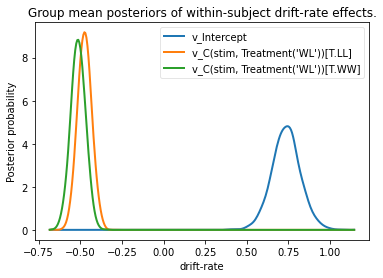

In [28]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                           "v_C(stim, Treatment('WL'))[T.LL]",
                                           "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [29]:
# m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
#                            "a ~ theta:C(conf, Treatment('LC'))",
#                            depends_on={'v': 'stim'})
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'},
                           include = ['v', 'a', 't', 'z'],
                           informative = True,
                           is_group_model = True)
m_reg.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 3083.8 sec

P(a_theta < 0) =  0.0565


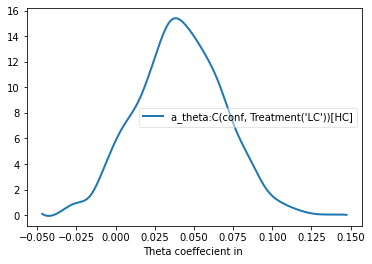

In [30]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [31]:
# m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
#                                "a ~ theta:C(conf, Treatment('LC'))",
#                                depends_on={'v': 'stim'})
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'},
                           include = ['v', 'a', 't', 'z'],
                           informative = True,
                           is_group_model = True)
m_reg_off.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5001 of 5000 complete in 3005.4 sec

P(a_theta > 0) =  0.051


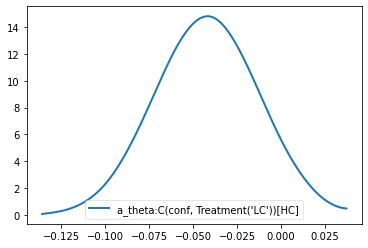

In [32]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

This part of the tutorial seems outdated because, since 0.6.0, HDDM has a default setting `p_outliers=.05`. 

In [33]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
# m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier = hddm.HDDM(outlier_data, p_outlier = 0.0,
                         include = ['v', 'a', 't', 'z'],
                         informative = True,
                         is_group_model = False)
m_no_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 13.4 sec

Text(0, 0.5, 'Probability density')

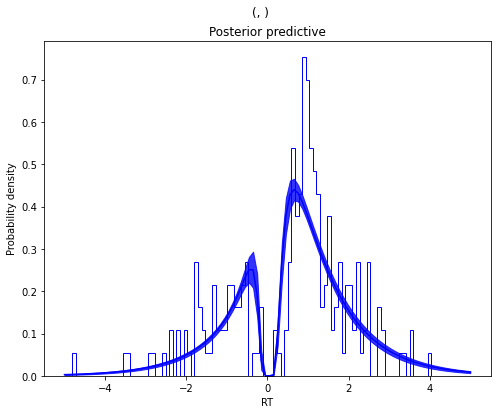

In [35]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [36]:
# m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05,
                      include = ['v', 'a', 't', 'z'],
                      informative = True,
                      is_group_model = False)
m_outlier.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 15.7 sec

Text(0, 0.5, 'Probability density')

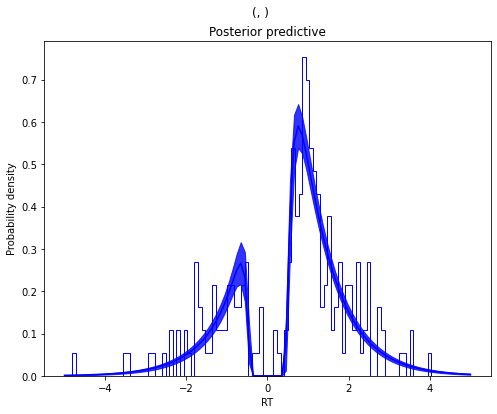

In [37]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')